# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [101]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [102]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [104]:
df.describe()

parcelid  airconditioningtypeid  architecturalstyletypeid  \
count  7.761300e+04           25007.000000                207.000000   
mean   1.300781e+07               1.812013                  7.386473   
std    3.518717e+06               2.965768                  2.728030   
min    1.071186e+07               1.000000                  2.000000   
25%    1.153821e+07               1.000000                  7.000000   
50%    1.253004e+07               1.000000                  7.000000   
75%    1.421101e+07               1.000000                  7.000000   
max    1.676893e+08              13.000000                 21.000000   

       basementsqft   bathroomcnt    bedroomcnt  buildingclasstypeid  \
count     50.000000  77579.000000  77579.000000            15.000000   
mean     679.720000      2.298496      3.053223             3.933333   
std      689.703546      0.996732      1.140480             0.258199   
min       38.000000      0.000000      0.000000             3.000000   
25%      273.000000      2.000000      2.000000             4.000000   
50%      515.000000      2.000000      3.000000             4.000000   
75%      796.500000      3.000000      4.000000             4.000000   
max     3560.000000     18.000000     16.000000             4.000000   

       buildingqualitytypeid  calculatedbathnbr  decktypeid  ...  \
count           49809.000000       76963.000000       614.0  ...   
mean                6.533779           2.316392        66.0  ...   
std                 1.722062           0.979689         0.0  ...   
min                 1.000000           1.000000        66.0  ...   
25%                 6.000000           2.000000        66.0  ...   
50%                 6.000000           2.000000        66.0  ...   
75%                 8.000000           3.000000        66.0  ...   
max                12.000000          18.000000        66.0  ...   

       typeconstructiontypeid       unitcnt  yardbuildingsqft17  \
count              223.000000  50703.000000         2393.000000   
mean                 6.040359      1.110309          305.460928   
std                  0.556035      1.169967          238.735241   
min                  4.000000      1.000000           11.000000   
25%                  6.000000      1.000000          170.000000   
50%                  6.000000      1.000000          250.000000   
75%                  6.000000      1.000000          364.000000   
max                 13.000000    237.000000         3191.000000   

       yardbuildingsqft26     yearbuilt  numberofstories  assessmentyear  \
count           70.000000  77309.000000     17599.000000         77579.0   
mean           216.385714   1968.611507         1.434286          2016.0   
std            190.177514     23.793171         0.544515             0.0   
min             12.000000   1824.000000         1.000000          2016.0   
25%             61.500000   1953.000000         1.000000          2016.0   
50%            164.500000   1970.000000         1.000000          2016.0   
75%            310.500000   1987.000000         2.000000          2016.0   
max            868.000000   2016.000000         6.000000          2016.0   

       taxdelinquencyyear  censustractandblock  taxvaluedollarcnt  
count         2900.000000         7.733200e+04       7.757800e+04  
mean            14.088276         6.049667e+13       4.901506e+05  
std              2.181281         1.533339e+12       6.537979e+05  
min              3.000000         6.037101e+13       1.000000e+03  
25%             14.000000         6.037311e+13       2.068985e+05  
50%             15.000000         6.037603e+13       3.588785e+05  
75%             15.000000         6.059042e+13       5.690000e+05  
max             99.000000         4.830301e+14       4.906124e+07  

[8 rows x 50 columns]

In [105]:
df.head()

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0                3.5         NaN  ...                 NaN                 NaN   
1                1.0         NaN  ...                 NaN                 NaN   
2                2.0         NaN  ...                 NaN                 NaN   
3                3.0         NaN  ...                 NaN                 NaN   
4                3.0         NaN  ...                 NaN                 NaN   

   yearbuilt  numberofstories  fireplaceflag  assessmentyear  \
0     1998.0              NaN            NaN          2016.0   
1     1967.0              1.0            NaN          2016.0   
2     1962.0              1.0            NaN          2016.0   
3     1970.0              NaN            NaN          2016.0   
4     1964.0              NaN            NaN          2016.0   

   taxdelinquencyflag  taxdelinquencyyear  censustractandblock  \
0                 NaN                 NaN         6.059063e+13   
1                 NaN                 NaN         6.111001e+13   
2                 NaN                 NaN         6.059022e+13   
3                 NaN                 NaN         6.037300e+13   
4                 NaN                 NaN         6.037124e+13   

   taxvaluedollarcnt  
0          1023282.0  
1           464000.0  
2           564778.0  
3           145143.0  
4           119407.0  

[5 rows x 55 columns]

In [129]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

Feature Histograms


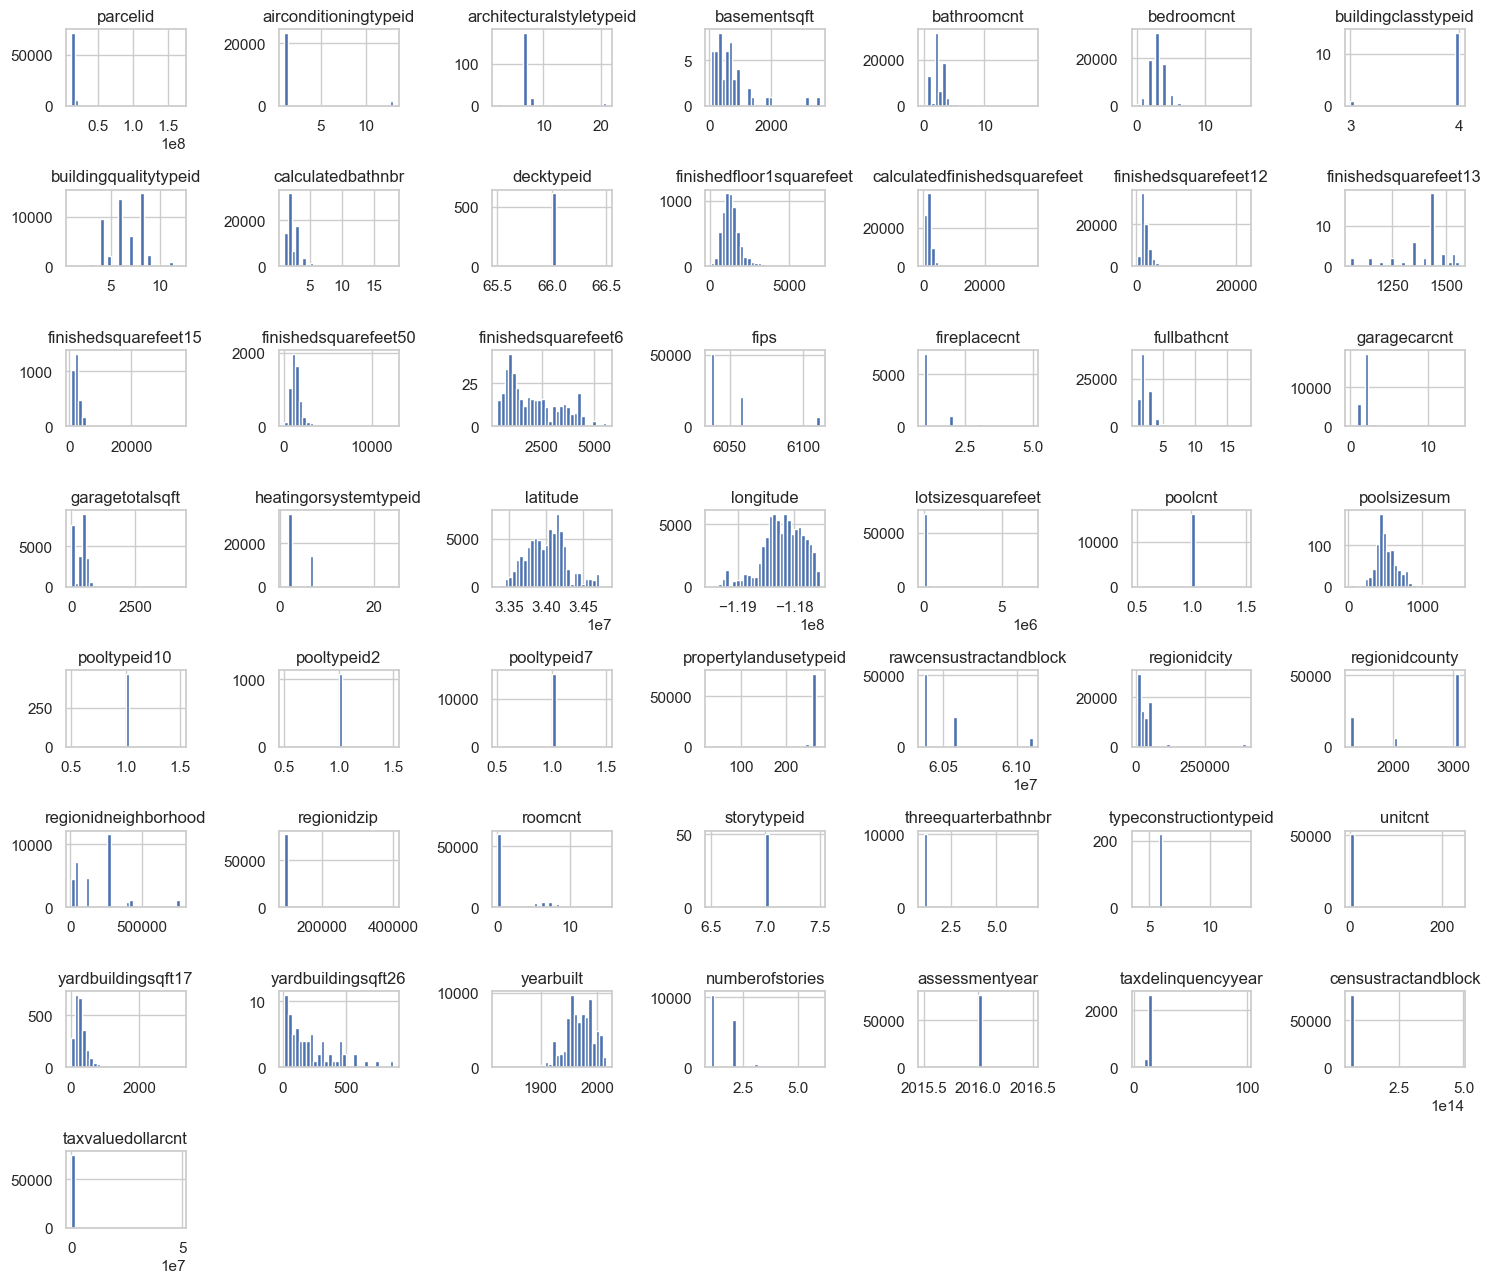

In [106]:
print("Feature Histograms")
df.hist(figsize=(15, 13), bins=30)  # Adjust figure size and number of bins
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [107]:

missing_values = df.isnull().sum() / len(df) * 100
print(missing_values.sort_values(ascending=False))

buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79

In [108]:
# Basic information
print(f"Dataset shape: {df.shape}")
print(df.info())
print(df.describe())

Dataset shape: (77613, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          739

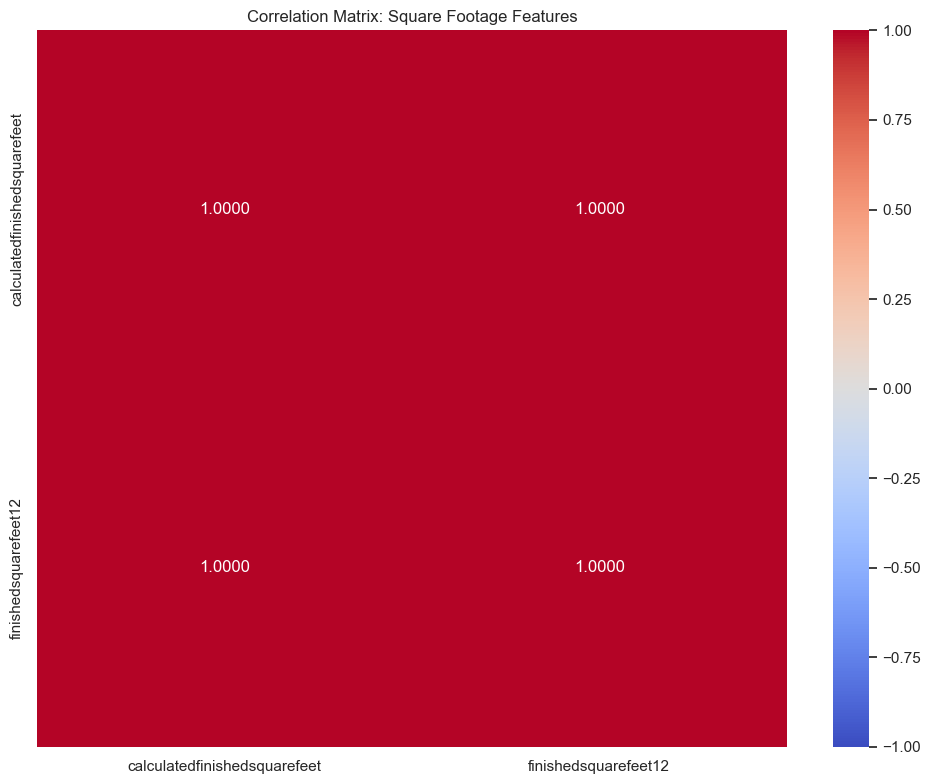

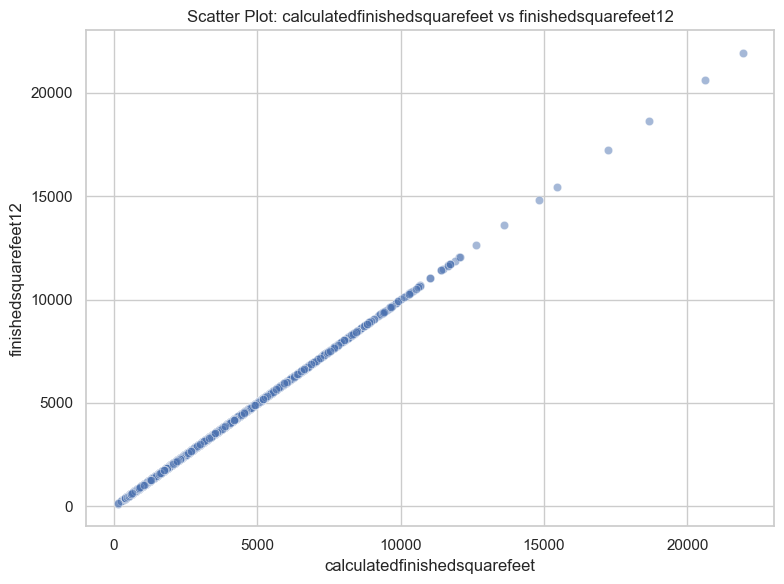

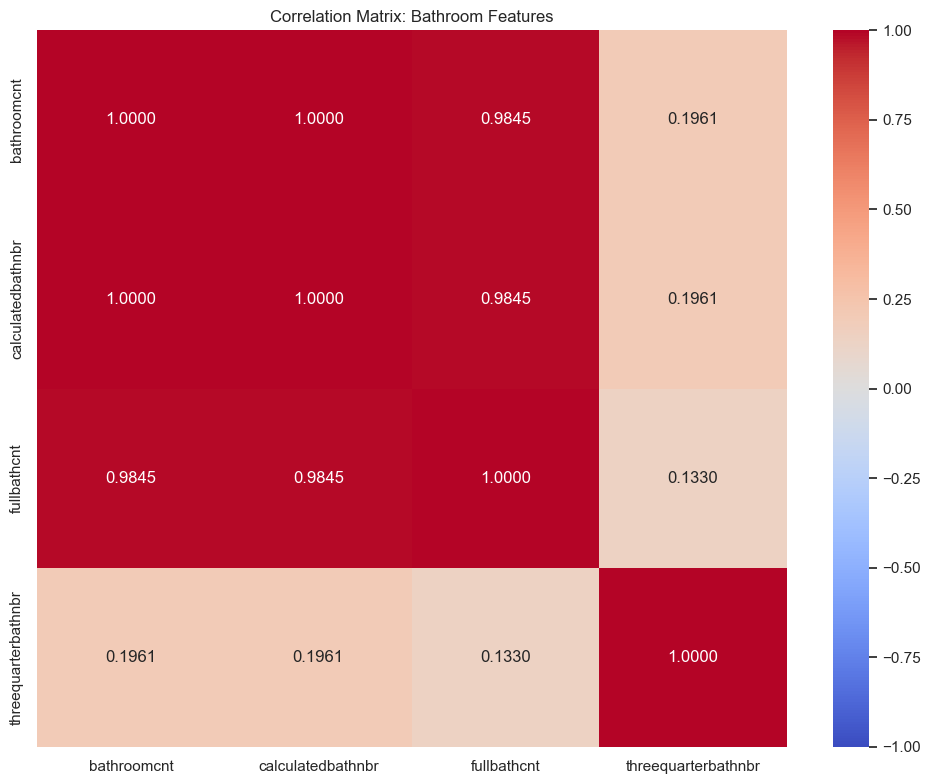

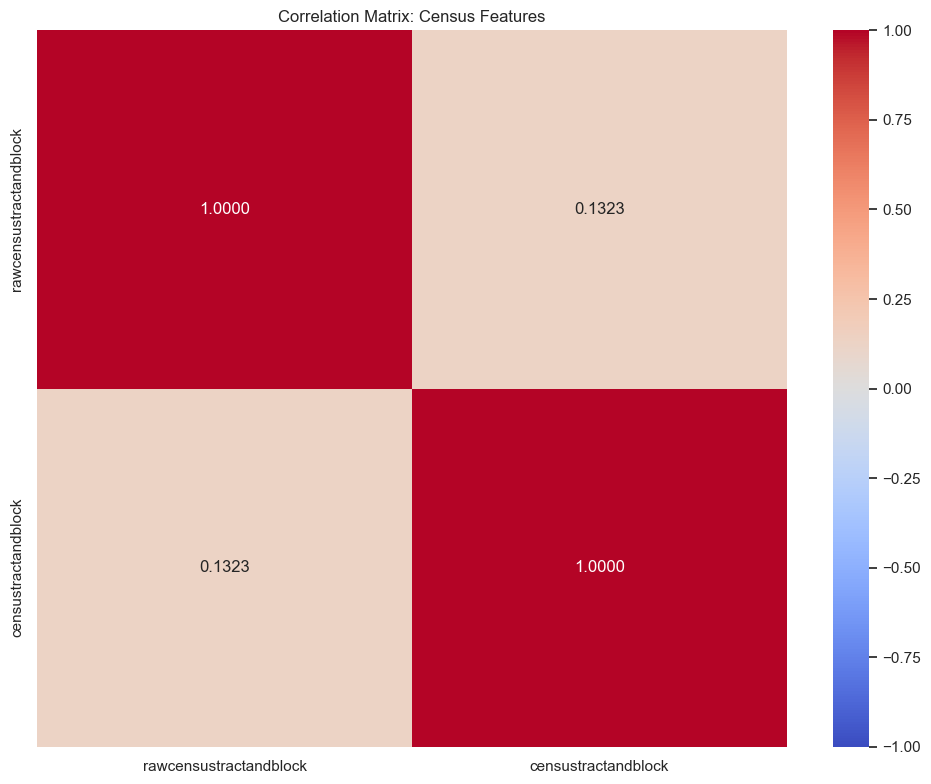

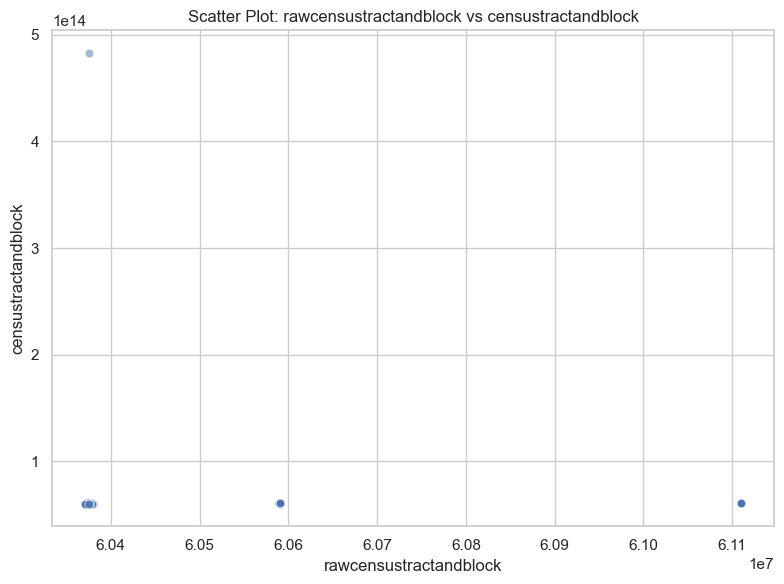

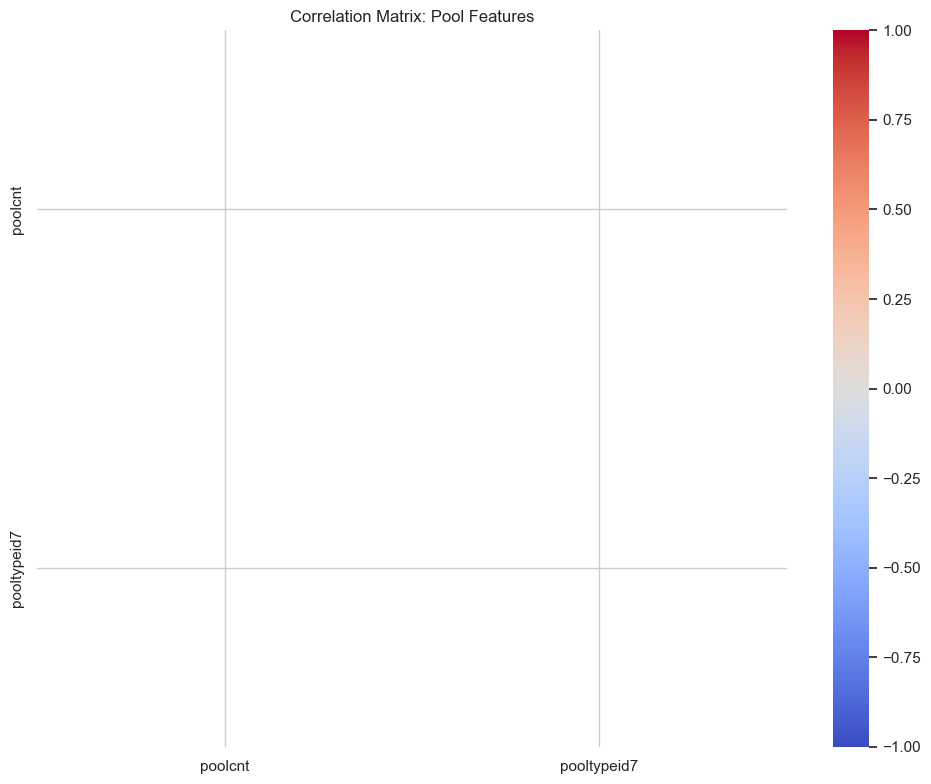

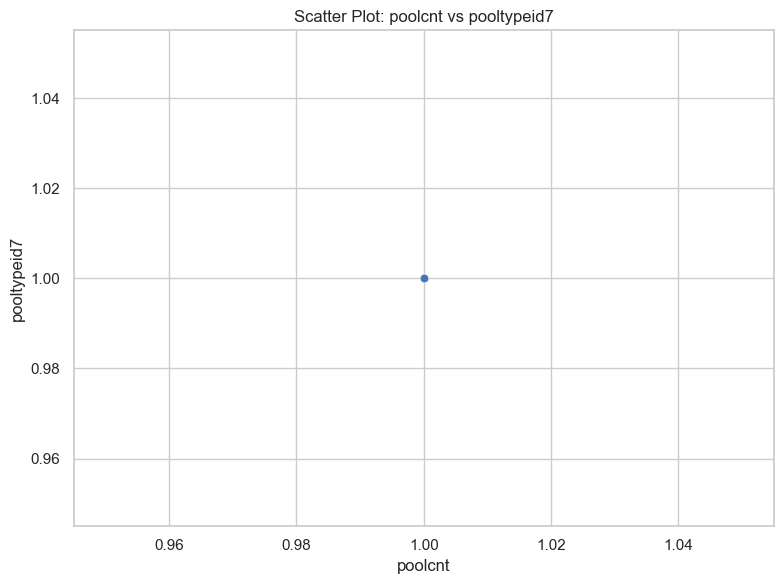

Percentage of properties with missing pool count: 79.16%
Properties with both pool features non-null: 15079
Properties with poolcnt non-null: 16174
Properties with pooltypeid7 non-null: 15079

Summary of Correlation Analysis:

Square Footage Features:
Correlation between calculatedfinishedsquarefeet and finishedsquarefeet12: 1.0000
Recommendation: These features are highly correlated. Keep calculatedfinishedsquarefeet and drop finishedsquarefeet12.

Bathroom Features:
High correlation (1.0000) between bathroomcnt and calculatedbathnbr
High correlation (0.9845) between bathroomcnt and fullbathcnt
High correlation (1.0000) between calculatedbathnbr and bathroomcnt
High correlation (0.9845) between calculatedbathnbr and fullbathcnt
High correlation (0.9845) between fullbathcnt and bathroomcnt
High correlation (0.9845) between fullbathcnt and calculatedbathnbr

Census Features:
Correlation between rawcensustractandblock and censustractandblock: 0.1323

Pool Features:
Correlation between po

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with the Zillow data
# Let's check correlations for each group of potentially redundant features

# Function to calculate and display correlation
def check_feature_correlation(df, feature_group, group_name):
    # Drop rows where all features in the group are null
    subset_df = df[feature_group].dropna(how='all')
    
    # Calculate correlation matrix
    corr_matrix = subset_df.corr()
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.4f')
    plt.title(f'Correlation Matrix: {group_name}')
    plt.tight_layout()
    plt.show()
    
    # For pairs of features, show scatter plots
    if len(feature_group) == 2:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=subset_df, x=feature_group[0], y=feature_group[1], alpha=0.5)
        plt.title(f'Scatter Plot: {feature_group[0]} vs {feature_group[1]}')
        plt.tight_layout()
        plt.show()
    
    # Return the correlation matrix for reference
    return corr_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with the Zillow data
# Let's check correlations for each group of potentially redundant features

# Function to calculate and display correlation
def check_feature_correlation(df, feature_group, group_name):
    # Drop rows where all features in the group are null
    subset_df = df[feature_group].dropna(how='all')
    
    # Calculate correlation matrix
    corr_matrix = subset_df.corr()
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.4f')
    plt.title(f'Correlation Matrix: {group_name}')
    plt.tight_layout()
    plt.show()
    
    # For pairs of features, show scatter plots
    if len(feature_group) == 2:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=subset_df, x=feature_group[0], y=feature_group[1], alpha=0.5)
        plt.title(f'Scatter Plot: {feature_group[0]} vs {feature_group[1]}')
        plt.tight_layout()
        plt.show()
    
    # Return the correlation matrix for reference
    return corr_matrix

# 1. Square Footage Measurements
sqft_features = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
sqft_corr = check_feature_correlation(df, sqft_features, 'Square Footage Features')

# 2. Bathroom Counts
bath_features = ['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']
bath_corr = check_feature_correlation(df, bath_features, 'Bathroom Features')

# 3. Geographic Identifiers
census_features = ['rawcensustractandblock', 'censustractandblock']
census_corr = check_feature_correlation(df, census_features, 'Census Features')

# 4. Pool-related Features
pool_features = ['poolcnt', 'pooltypeid7']
pool_corr = check_feature_correlation(df, pool_features, 'Pool Features')

# Let's also check the distribution of missing values in the poolcnt feature
# to confirm our hypothesis that missing values likely mean "no pool"
pool_missing = df['poolcnt'].isnull()
print(f"Percentage of properties with missing pool count: {pool_missing.mean()*100:.2f}%")

# Let's also check how many properties have both poolcnt and pooltypeid7 non-null
both_pool_features = (~df['poolcnt'].isnull()) & (~df['pooltypeid7'].isnull())
print(f"Properties with both pool features non-null: {both_pool_features.sum()}")
print(f"Properties with poolcnt non-null: {(~df['poolcnt'].isnull()).sum()}")
print(f"Properties with pooltypeid7 non-null: {(~df['pooltypeid7'].isnull()).sum()}")

# Additional analysis for each correlation group
print("\nSummary of Correlation Analysis:")

# Square footage
print("\nSquare Footage Features:")
if 'calculatedfinishedsquarefeet' in sqft_corr and 'finishedsquarefeet12' in sqft_corr:
    corr_val = sqft_corr.loc['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
    print(f"Correlation between calculatedfinishedsquarefeet and finishedsquarefeet12: {corr_val:.4f}")
    if corr_val > 0.95:
        print("Recommendation: These features are highly correlated. Keep calculatedfinishedsquarefeet and drop finishedsquarefeet12.")
    else:
        print("Recommendation: Consider keeping both features as they may capture different aspects of the property.")

# Bathroom features
print("\nBathroom Features:")
for feature1 in bath_features:
    for feature2 in bath_features:
        if feature1 != feature2 and feature1 in bath_corr and feature2 in bath_corr:
            corr_val = bath_corr.loc[feature1, feature2]
            if corr_val > 0.9:
                print(f"High correlation ({corr_val:.4f}) between {feature1} and {feature2}")

# Census features
print("\nCensus Features:")
if 'rawcensustractandblock' in census_corr and 'censustractandblock' in census_corr:
    corr_val = census_corr.loc['rawcensustractandblock', 'censustractandblock']
    print(f"Correlation between rawcensustractandblock and censustractandblock: {corr_val:.4f}")
    if corr_val > 0.95:
        print("Recommendation: These features are highly correlated. Keep rawcensustractandblock as it has fewer missing values.")

# Pool features
print("\nPool Features:")
if 'poolcnt' in pool_corr and 'pooltypeid7' in pool_corr:
    corr_val = pool_corr.loc['poolcnt', 'pooltypeid7']
    print(f"Correlation between poolcnt and pooltypeid7: {corr_val:.4f}")
    if corr_val > 0.9:
        print("Recommendation: These features are highly correlated. Keep poolcnt as it has better completeness.")

Correlation between calculatedfinishedsquarefeet and finishedsquarefeet12: 1.0000
Number of samples with both features non-null: 73923


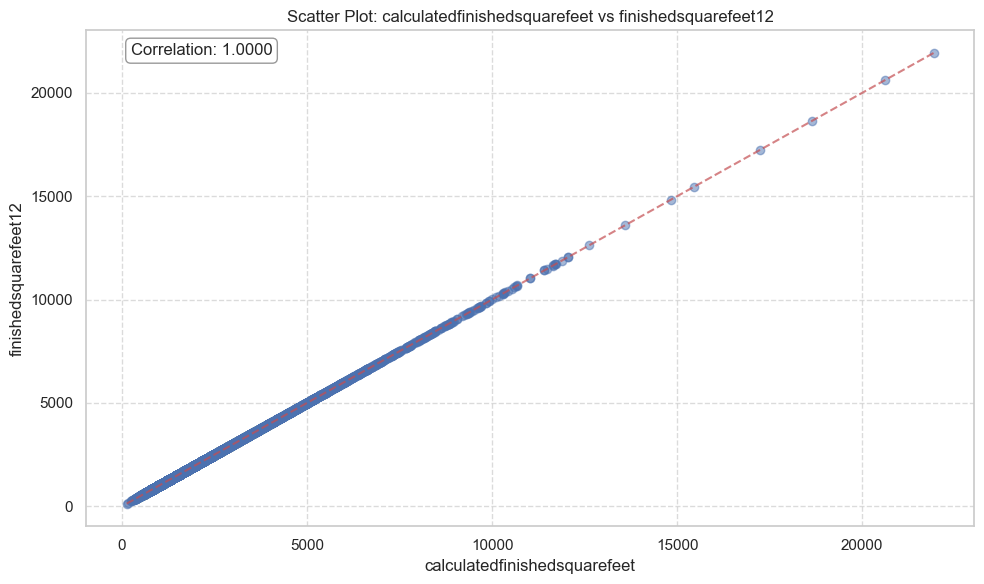

Mean ratio (calculatedfinishedsquarefeet/finishedsquarefeet12): 1.0000
Standard deviation of ratio: 0.0000
The features are essentially identical (just with scaling differences less than 1%)


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame with the Zillow data
# If not already loaded, you would load it like this:
# df = pd.read_csv('zillow_data.csv')

# Function to analyze correlation between two features
def analyze_correlation(df, feature1, feature2):
    # Create a subset with only non-null values for both features
    subset = df[[feature1, feature2]].dropna()
    
    # Calculate Pearson correlation
    correlation = subset[feature1].corr(subset[feature2])
    
    print(f"Correlation between {feature1} and {feature2}: {correlation:.4f}")
    print(f"Number of samples with both features non-null: {len(subset)}")
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(subset[feature1], subset[feature2], alpha=0.5)
    plt.title(f'Scatter Plot: {feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add correlation coefficient to the plot
    plt.annotate(f"Correlation: {correlation:.4f}", 
                 xy=(0.05, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    # Add a perfect correlation line for reference
    if subset[feature1].min() < subset[feature2].min():
        min_val = subset[feature1].min()
    else:
        min_val = subset[feature2].min()
        
    if subset[feature1].max() > subset[feature2].max():
        max_val = subset[feature1].max()
    else:
        max_val = subset[feature2].max()
    
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Check for scaling differences
    ratio = subset[feature1] / subset[feature2]
    mean_ratio = ratio.mean()
    std_ratio = ratio.std()
    
    print(f"Mean ratio ({feature1}/{feature2}): {mean_ratio:.4f}")
    print(f"Standard deviation of ratio: {std_ratio:.4f}")
    
    if abs(mean_ratio - 1.0) < 0.01 and std_ratio < 0.01:
        print(f"The features are essentially identical (just with scaling differences less than 1%)")
    elif abs(mean_ratio - 1.0) < 0.05 and std_ratio < 0.05:
        print(f"The features are very similar with minor variations")
    else:
        print(f"The features show some differences despite their correlation")
    
    # Look at specific examples of differences
    if correlation < 0.999:
        diff_pct = abs(subset[feature1] - subset[feature2]) / subset[feature1] * 100
        large_diff = subset[diff_pct > 5].sort_values(by=diff_pct, ascending=False).head(5)
        
        if len(large_diff) > 0:
            print("\nExamples where values differ by >5%:")
            for _, row in large_diff.iterrows():
                print(f"  {feature1}: {row[feature1]}, {feature2}: {row[feature2]}, " 
                      f"Diff: {abs(row[feature1] - row[feature2]):.1f} ({diff_pct.loc[_]:.1f}%)")

# Analyze correlation between the square footage features
analyze_correlation(df, 'calculatedfinishedsquarefeet', 'finishedsquarefeet12')

calculatedfinishedsquarefeet and finishedsquarefeet12 are functionally identical variables for the following reasons:
The scatter plot shows a perfect diagonal line with points falling precisely on the reference line
The correlation coefficient is exactly 1.0000 (perfect correlation)
The mean ratio between the variables is 1.0000, indicating no scaling differences
The standard deviation of the ratio is 0.0000, confirming there are no variations at all

They contain exactly the same information
calculatedfinishedsquarefeet has higher completeness (99.7% ) vs finishedsquarefeet12  which has 95.2%



Aarad: hashottuborspa, fireplaceflag, taxdelincuencyflag: replace null with a zero
Nic: Low correlation combined with high null values (missing values) we decided to drop those
figs: impute and hot code

we can remove the following variables simply due to sheer numbers of null presence:
| Field Name                  | Non-Null Count | Total Count | Percentage (%) |
|-----------------------------|----------------|-------------|----------------|
| architecturalstyletypeid    | 207            | 77613       | 0.27           |
| basementsqft                | 50             | 77613       | 0.06           |
| buildingclasstypeid         | 15             | 77613       | 0.02           |
| decktypeid                  | 614            | 77613       | 0.79           |
| finishedfloor1squarefeet    | 6037           | 77613       | 7.78           |
| finishedsquarefeet13        | 42             | 77613       | 0.05           |
| finishedsquarefeet15        | 3027           | 77613       | 3.90           |
| finishedsquarefeet50        | 6037           | 77613       | 7.78           |
| finishedsquarefeet6         | 386            | 77613       | 0.50           |
| poolsizesum                 | 869            | 77613       | 1.12           |
| pooltypeid10                | 465            | 77613       | 0.60           |
| pooltypeid2                 | 1074           | 77613       | 1.38           |
| storytypeid                 | 50             | 77613       | 0.06           |
| typeconstructiontypeid      | 223            | 77613       | 0.29           |
| yardbuildingsqft17          | 2393           | 77613       | 3.08           |
| yardbuildingsqft26          | 70             | 77613       | 0.09           |
| fireplaceflag               | 172            | 77613       | 0.22           |

Based on Value count and description, these are categorical variables despite having numerical data type:

| Feature Name               | Description                                           |
|----------------------------|-------------------------------------------------------|
| fips                       | Federal Information Processing Standard codes (county identifiers) |
| airconditioningtypeid      | Type codes for air conditioning systems               |
| buildingqualitytypeid      | Quality ratings (1-12 scale)                          |
| heatingorsystemtypeid      | Type codes for heating systems                        |
| propertylandusetypeid      | Land use type codes                                   |
| regionidcity               | City identifier codes                                 |
| regionidcounty             | County identifier codes                               |
| regionidneighborhood       | Neighborhood identifier codes                         |
| regionidzip                | ZIP code identifiers                                  |
| unitcnt                    | Number of units (discrete values)                     |
| assessmentyear             | Year of assessment (appears to be constant 2016)      |

Points to note:

taxvaluedollarcnt is the target variable and has only 35 missing: Question: can we drop the missing values? 


hashottuborspa and fireplaceflag are binary categorical features (yes/no)


assessmentyear: This appears to be a constant (all 2016) and can be dropped

parcelid is an identifier column meant for record-keeping but excluded from modeling

### Data Preprocessing

First, let's remove the features that are clearly not useful for regression.

### Data Preprocessing

First, let's remove the features that are clearly not useful for regression.

In [111]:
import pandas as pd

def drop_high_null_features(df, threshold=0.5, verbose=True):
    """
    Drop features with null values exceeding a specified threshold.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame containing features to evaluate
    threshold : float, default=0.5
        The threshold for null percentage (0.0 to 1.0)
        Features with null percentage > threshold will be dropped
    verbose : bool, default=True
        Whether to print a summary of dropped features
    
    Returns:
    --------
    pandas DataFrame
        A completely independent copy of the cleaned DataFrame
    dict
        Dictionary containing information about dropped features
    """
    # Validate inputs
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input 'df' must be a pandas DataFrame.")
    if not (0.0 <= threshold <= 1.0):
        raise ValueError("Threshold must be a float between 0.0 and 1.0.")
    
    # Handle empty DataFrame
    if df.empty:
        if verbose:
            print("Input DataFrame is empty. No features to evaluate.")
        return df.copy(), {'total_features_dropped': 0, 'features_dropped': []}
    
    # Calculate null percentage for each feature
    null_percentage = df.isnull().mean()
    
    # Identify features to drop based on threshold
    features_to_drop = null_percentage[null_percentage > threshold].index.tolist()
    
    # Create result dictionary with details
    dropped_info = {
        'total_features_dropped': len(features_to_drop),
        'features_dropped': [],
    }
    
    # Sort null percentages in descending order
    sorted_nulls = null_percentage[null_percentage > threshold].sort_values(ascending=False)
    
    # Add detailed information about each dropped feature
    for feature, pct in sorted_nulls.items():
        dropped_info['features_dropped'].append({
            'feature': feature,
            'null_percentage': pct * 100,
            'non_null_count': df[feature].count()
        })
    
    # Drop the identified features and create an explicit copy
    df_clean_null = df.drop(columns=features_to_drop).copy()
    
    # Print summary if verbose is True
    if verbose:
        if len(features_to_drop) > 0:
            print(f"Dropped {len(features_to_drop)} features with null percentage > {threshold*100:.1f}%:")
            for info in dropped_info['features_dropped']:
                print(f"  - {info['feature']}: {info['null_percentage']:.2f}% null "
                      f"({info['non_null_count']} non-null values)")
        else:
            print(f"No features with null percentage > {threshold*100:.1f}% were found.")
    
    return df_clean_null, dropped_info
    # Assuming df is your Zillow DataFrame
df_clean_null, dropped_info = drop_high_null_features(df, threshold=0.5)

# Now you can view the head of the cleaned DataFrame
df_clean_null.head()
       

Dropped 29 features with null percentage > 50.0%:
  - buildingclasstypeid: 99.98% null (15 non-null values)
  - finishedsquarefeet13: 99.95% null (42 non-null values)
  - basementsqft: 99.94% null (50 non-null values)
  - storytypeid: 99.94% null (50 non-null values)
  - yardbuildingsqft26: 99.91% null (70 non-null values)
  - fireplaceflag: 99.78% null (172 non-null values)
  - architecturalstyletypeid: 99.73% null (207 non-null values)
  - typeconstructiontypeid: 99.71% null (223 non-null values)
  - finishedsquarefeet6: 99.50% null (386 non-null values)
  - pooltypeid10: 99.40% null (465 non-null values)
  - decktypeid: 99.21% null (614 non-null values)
  - poolsizesum: 98.88% null (869 non-null values)
  - pooltypeid2: 98.62% null (1074 non-null values)
  - hashottuborspa: 98.02% null (1539 non-null values)
  - yardbuildingsqft17: 96.92% null (2393 non-null values)
  - taxdelinquencyflag: 96.26% null (2900 non-null values)
  - taxdelinquencyyear: 96.26% null (2900 non-null values)


parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
0  14297519          3.5         4.0                    NaN   
1  17052889          1.0         2.0                    NaN   
2  14186244          2.0         3.0                    NaN   
3  12177905          3.0         4.0                    8.0   
4  10887214          3.0         3.0                    8.0   

   calculatedbathnbr  calculatedfinishedsquarefeet  finishedsquarefeet12  \
0                3.5                        3100.0                3100.0   
1                1.0                        1465.0                1465.0   
2                2.0                        1243.0                1243.0   
3                3.0                        2376.0                2376.0   
4                3.0                        1312.0                1312.0   

     fips  fullbathcnt  heatingorsystemtypeid  ...  rawcensustractandblock  \
0  6059.0          3.0                    NaN  ...            6.059063e+07   
1  6111.0          1.0                    NaN  ...            6.111001e+07   
2  6059.0          2.0                    NaN  ...            6.059022e+07   
3  6037.0          3.0                    2.0  ...            6.037300e+07   
4  6037.0          3.0                    2.0  ...            6.037124e+07   

   regionidcity  regionidcounty regionidzip  roomcnt unitcnt  yearbuilt  \
0       53571.0          1286.0     96978.0      0.0     NaN     1998.0   
1       13091.0          2061.0     97099.0      5.0     NaN     1967.0   
2       21412.0          1286.0     97078.0      6.0     NaN     1962.0   
3      396551.0          3101.0     96330.0      0.0     1.0     1970.0   
4       12447.0          3101.0     96451.0      0.0     1.0     1964.0   

   assessmentyear  censustractandblock  taxvaluedollarcnt  
0          2016.0         6.059063e+13          1023282.0  
1          2016.0         6.111001e+13           464000.0  
2          2016.0         6.059022e+13           564778.0  
3          2016.0         6.037300e+13           145143.0  
4          2016.0         6.037124e+13           119407.0  

[5 rows x 26 columns]

In [112]:
def drop_id_columns(df, id_columns=None, pattern=None, verbose=True):
    """
    Drop identifier columns that typically don't add predictive value.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    id_columns : list, optional
        Explicit list of column names to drop
    pattern : str, optional
        Regex pattern to identify ID columns (e.g., '.*id$' for columns ending with 'id')
    verbose : bool, default=True
        Whether to print information about dropped columns
    
    Returns:
    --------
    pandas DataFrame
        A copy of the DataFrame with ID columns removed
    list
        List of columns that were dropped
    """
    import re
    
    columns_to_drop = []
    
    # Add explicitly listed columns
    if id_columns is not None:
        for col in id_columns:
            if col in df.columns:
                columns_to_drop.append(col)
    
    # Add columns matching pattern
    if pattern is not None:
        pattern_regex = re.compile(pattern, re.IGNORECASE)
        pattern_columns = [col for col in df.columns if pattern_regex.match(col)]
        columns_to_drop.extend([col for col in pattern_columns if col not in columns_to_drop])
    
    # Drop the columns and create a copy
    df_no_id = df.drop(columns=columns_to_drop).copy()
    
    if verbose and columns_to_drop:
        print(f"Dropped {len(columns_to_drop)} ID columns:")
        for col in columns_to_drop:
            print(f"  - {col}")
    elif verbose:
        print("No ID columns were found to drop.")
    
    return df_no_id, columns_to_drop



# Define specific columns to drop from the df_clean_null dataframe
specific_columns_to_drop = ['parcelid', 'assessmentyear'] 

# Drop these specific columns from df_clean_null and create a new dataframe with a distinct name
df_clean_specific, specific_cols_dropped = drop_id_columns(df_clean_null, id_columns=specific_columns_to_drop)

# Verify the columns were dropped
print(f"Dropped columns: {specific_cols_dropped}")

# Confirm we have a new dataframe object (not just a view)
print(f"Original df_clean_null shape: {df_clean_null.shape}")
print(f"New df_clean_specific shape: {df_clean_specific.shape}")

print(df_clean_specific.head())

Dropped 2 ID columns:
  - parcelid
  - assessmentyear
Dropped columns: ['parcelid', 'assessmentyear']
Original df_clean_null shape: (77613, 26)
New df_clean_specific shape: (77613, 24)
   bathroomcnt  bedroomcnt  buildingqualitytypeid  calculatedbathnbr  \
0          3.5         4.0                    NaN                3.5   
1          1.0         2.0                    NaN                1.0   
2          2.0         3.0                    NaN                2.0   
3          3.0         4.0                    8.0                3.0   
4          3.0         3.0                    8.0                3.0   

   calculatedfinishedsquarefeet  finishedsquarefeet12    fips  fullbathcnt  \
0                        3100.0                3100.0  6059.0          3.0   
1                        1465.0                1465.0  6111.0          1.0   
2                        1243.0                1243.0  6059.0          2.0   
3                        2376.0                2376.0  6037.0         

In [113]:
def convert_features_to_categorical(df, verbose=True):
    """
    Identifies and converts numerical columns that are actually categorical variables
    to appropriate categorical datatypes.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    verbose : bool, default=True
        Whether to print information about conversions
    
    Returns:
    --------
    pandas DataFrame
        A copy of the DataFrame with appropriate conversions
    dict
        Dictionary with details about converted columns
    """
    df_copy = df.copy()
    converted_cols = []
    
    # Features that are likely categorical based on domain knowledge
    categorical_candidates = [
        'fips',                  # County codes
        'buildingqualitytypeid', # Quality ratings
        'heatingorsystemtypeid', # Heating system type
        'propertylandusetypeid', # Land use codes
        'regionidcity',          # City identifier 
        'regionidcounty',        # County identifier
        'regionidzip',           # ZIP code identifier
        'unitcnt',               # Number of units (discrete)
        'yearbuilt'              # Year built (discrete)
    ]
    
    # Check each candidate column
    for col in categorical_candidates:
        if col in df.columns:
            # Only examine float/int columns
            if pd.api.types.is_numeric_dtype(df[col]):
                # Check number of unique values
                n_unique = df[col].nunique()
                
                # If column has NaN values
                null_count = df[col].isnull().sum()
                
                # Determine appropriate type conversion based on unique values
                if n_unique <= 255:  # Small number of categories
                    # Convert to categorical to save memory and express intent
                    df_copy[col] = df[col].astype('category')
                    conversion_type = 'category'
                else:
                    # Large number of categories but still discrete - integer is fine
                    if col in ['yearbuilt']:
                        df_copy[col] = df[col].astype('Int64')  # pandas nullable integer
                        conversion_type = 'Int64'
                    else:
                        continue  # Skip conversion for high-cardinality numerical features
                
                converted_cols.append({
                    'column': col,
                    'unique_values': n_unique,
                    'null_values': null_count,
                    'conversion_type': conversion_type
                })
    
    # Create report
    conversion_info = {
        'total_conversions': len(converted_cols),
        'converted_columns': converted_cols
    }
    
    if verbose:
        if converted_cols:
            print(f"Converted {len(converted_cols)} columns to appropriate categorical types:")
            for info in converted_cols:
                print(f"  - {info['column']}: {info['unique_values']} unique values "
                      f"({info['null_values']} nulls) → {info['conversion_type']}")
        else:
            print("No columns were converted.")
    
    return df_copy, conversion_info

# Convert numerical columns that are actually categorical
df_categorized, conversion_info = convert_features_to_categorical(df_clean_specific)

# Check which columns were converted
print("\nDataFrame memory usage before conversion:", df_clean_specific.memory_usage().sum() / 1024**2, "MB")
print("DataFrame memory usage after conversion:", df_categorized.memory_usage().sum() / 1024**2, "MB")

# Verify the data types after conversion
print("\nData types after conversion:")
for col, dtype in df_categorized.dtypes.items():
    print(f"  - {col}: {dtype}")

Converted 8 columns to appropriate categorical types:
  - fips: 3 unique values (34 nulls) → category
  - buildingqualitytypeid: 12 unique values (27804 nulls) → category
  - heatingorsystemtypeid: 10 unique values (28042 nulls) → category
  - propertylandusetypeid: 13 unique values (34 nulls) → category
  - regionidcity: 175 unique values (1506 nulls) → category
  - regionidcounty: 3 unique values (34 nulls) → category
  - unitcnt: 8 unique values (26910 nulls) → category
  - yearbuilt: 136 unique values (304 nulls) → category

DataFrame memory usage before conversion: 14.211490631103516 MB
DataFrame memory usage after conversion: 10.226835250854492 MB

Data types after conversion:
  - bathroomcnt: float64
  - bedroomcnt: float64
  - buildingqualitytypeid: category
  - calculatedbathnbr: float64
  - calculatedfinishedsquarefeet: float64
  - finishedsquarefeet12: float64
  - fips: category
  - fullbathcnt: float64
  - heatingorsystemtypeid: category
  - latitude: float64
  - longitude:

In [114]:
df_categorized.head()

bathroomcnt  bedroomcnt buildingqualitytypeid  calculatedbathnbr  \
0          3.5         4.0                   NaN                3.5   
1          1.0         2.0                   NaN                1.0   
2          2.0         3.0                   NaN                2.0   
3          3.0         4.0                   8.0                3.0   
4          3.0         3.0                   8.0                3.0   

   calculatedfinishedsquarefeet  finishedsquarefeet12    fips  fullbathcnt  \
0                        3100.0                3100.0  6059.0          3.0   
1                        1465.0                1465.0  6111.0          1.0   
2                        1243.0                1243.0  6059.0          2.0   
3                        2376.0                2376.0  6037.0          3.0   
4                        1312.0                1312.0  6037.0          3.0   

  heatingorsystemtypeid    latitude  ...  propertyzoningdesc  \
0                   NaN  33634931.0  ...                 NaN   
1                   NaN  34449266.0  ...                 NaN   
2                   NaN  33886168.0  ...                 NaN   
3                   2.0  34245180.0  ...          LCR110000*   
4                   2.0  34185120.0  ...                LAR3   

   rawcensustractandblock regionidcity regionidcounty regionidzip  roomcnt  \
0            6.059063e+07      53571.0         1286.0     96978.0      0.0   
1            6.111001e+07      13091.0         2061.0     97099.0      5.0   
2            6.059022e+07      21412.0         1286.0     97078.0      6.0   
3            6.037300e+07     396551.0         3101.0     96330.0      0.0   
4            6.037124e+07      12447.0         3101.0     96451.0      0.0   

  unitcnt yearbuilt  censustractandblock  taxvaluedollarcnt  
0     NaN    1998.0         6.059063e+13          1023282.0  
1     NaN    1967.0         6.111001e+13           464000.0  
2     NaN    1962.0         6.059022e+13           564778.0  
3     1.0    1970.0         6.037300e+13           145143.0  
4     1.0    1964.0         6.037124e+13           119407.0  

[5 rows x 24 columns]

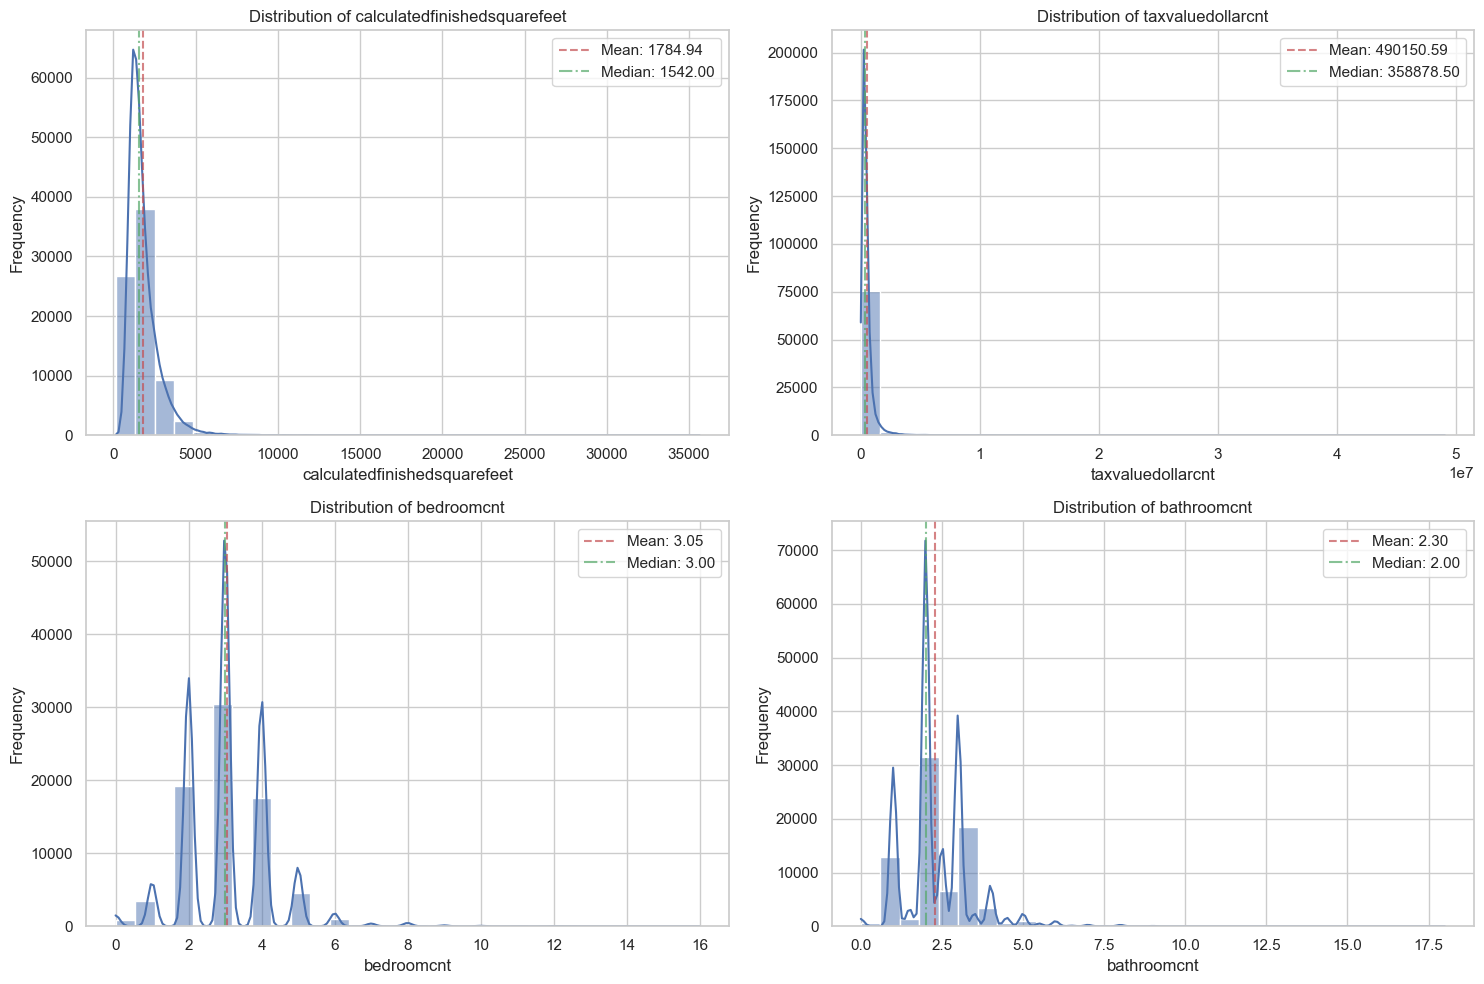

In [115]:
def plot_histograms(df, columns=None, figsize=(15, 10), bins=30):
    """
    Plot histograms for specified numerical columns in the dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    columns : list or None, default=None
        List of columns to plot. If None, plots all numerical columns
    figsize : tuple, default=(15, 10)
        Figure size (width, height) in inches
    bins : int, default=30
        Number of bins for the histograms
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set the style
    sns.set(style="whitegrid")
    
    # If no columns specified, use all numerical columns
    if columns is None:
        # Select only numeric columns
        num_cols = df.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()
        # Exclude any categorical columns stored as numbers
        columns = [col for col in num_cols if df[col].nunique() > 10]
    
    # Calculate number of rows and columns for subplot grid
    n_cols = 2
    n_rows = (len(columns) + 1) // 2
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Plot each column
    for i, col in enumerate(columns):
        if i < len(axes):
            # Get basic stats
            mean_val = df[col].mean()
            median_val = df[col].median()
            
            # Plot the histogram
            sns.histplot(df[col].dropna(), bins=bins, kde=True, ax=axes[i])
            
            # Add vertical lines for mean and median
            axes[i].axvline(mean_val, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(median_val, color='g', linestyle='-.', alpha=0.7, label=f'Median: {median_val:.2f}')
            
            # Add title and labels
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Plot histograms for key features
key_features = [
    'calculatedfinishedsquarefeet',
    'taxvaluedollarcnt',
    'bedroomcnt',
    'bathroomcnt'
]

plot_histograms(df_categorized, columns=key_features)

C:\Users\rachp\AppData\Local\Temp\ipykernel_11856\316616129.py:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\rachp\AppData\Local\Temp\ipykernel_11856\316616129.py:165: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\rachp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


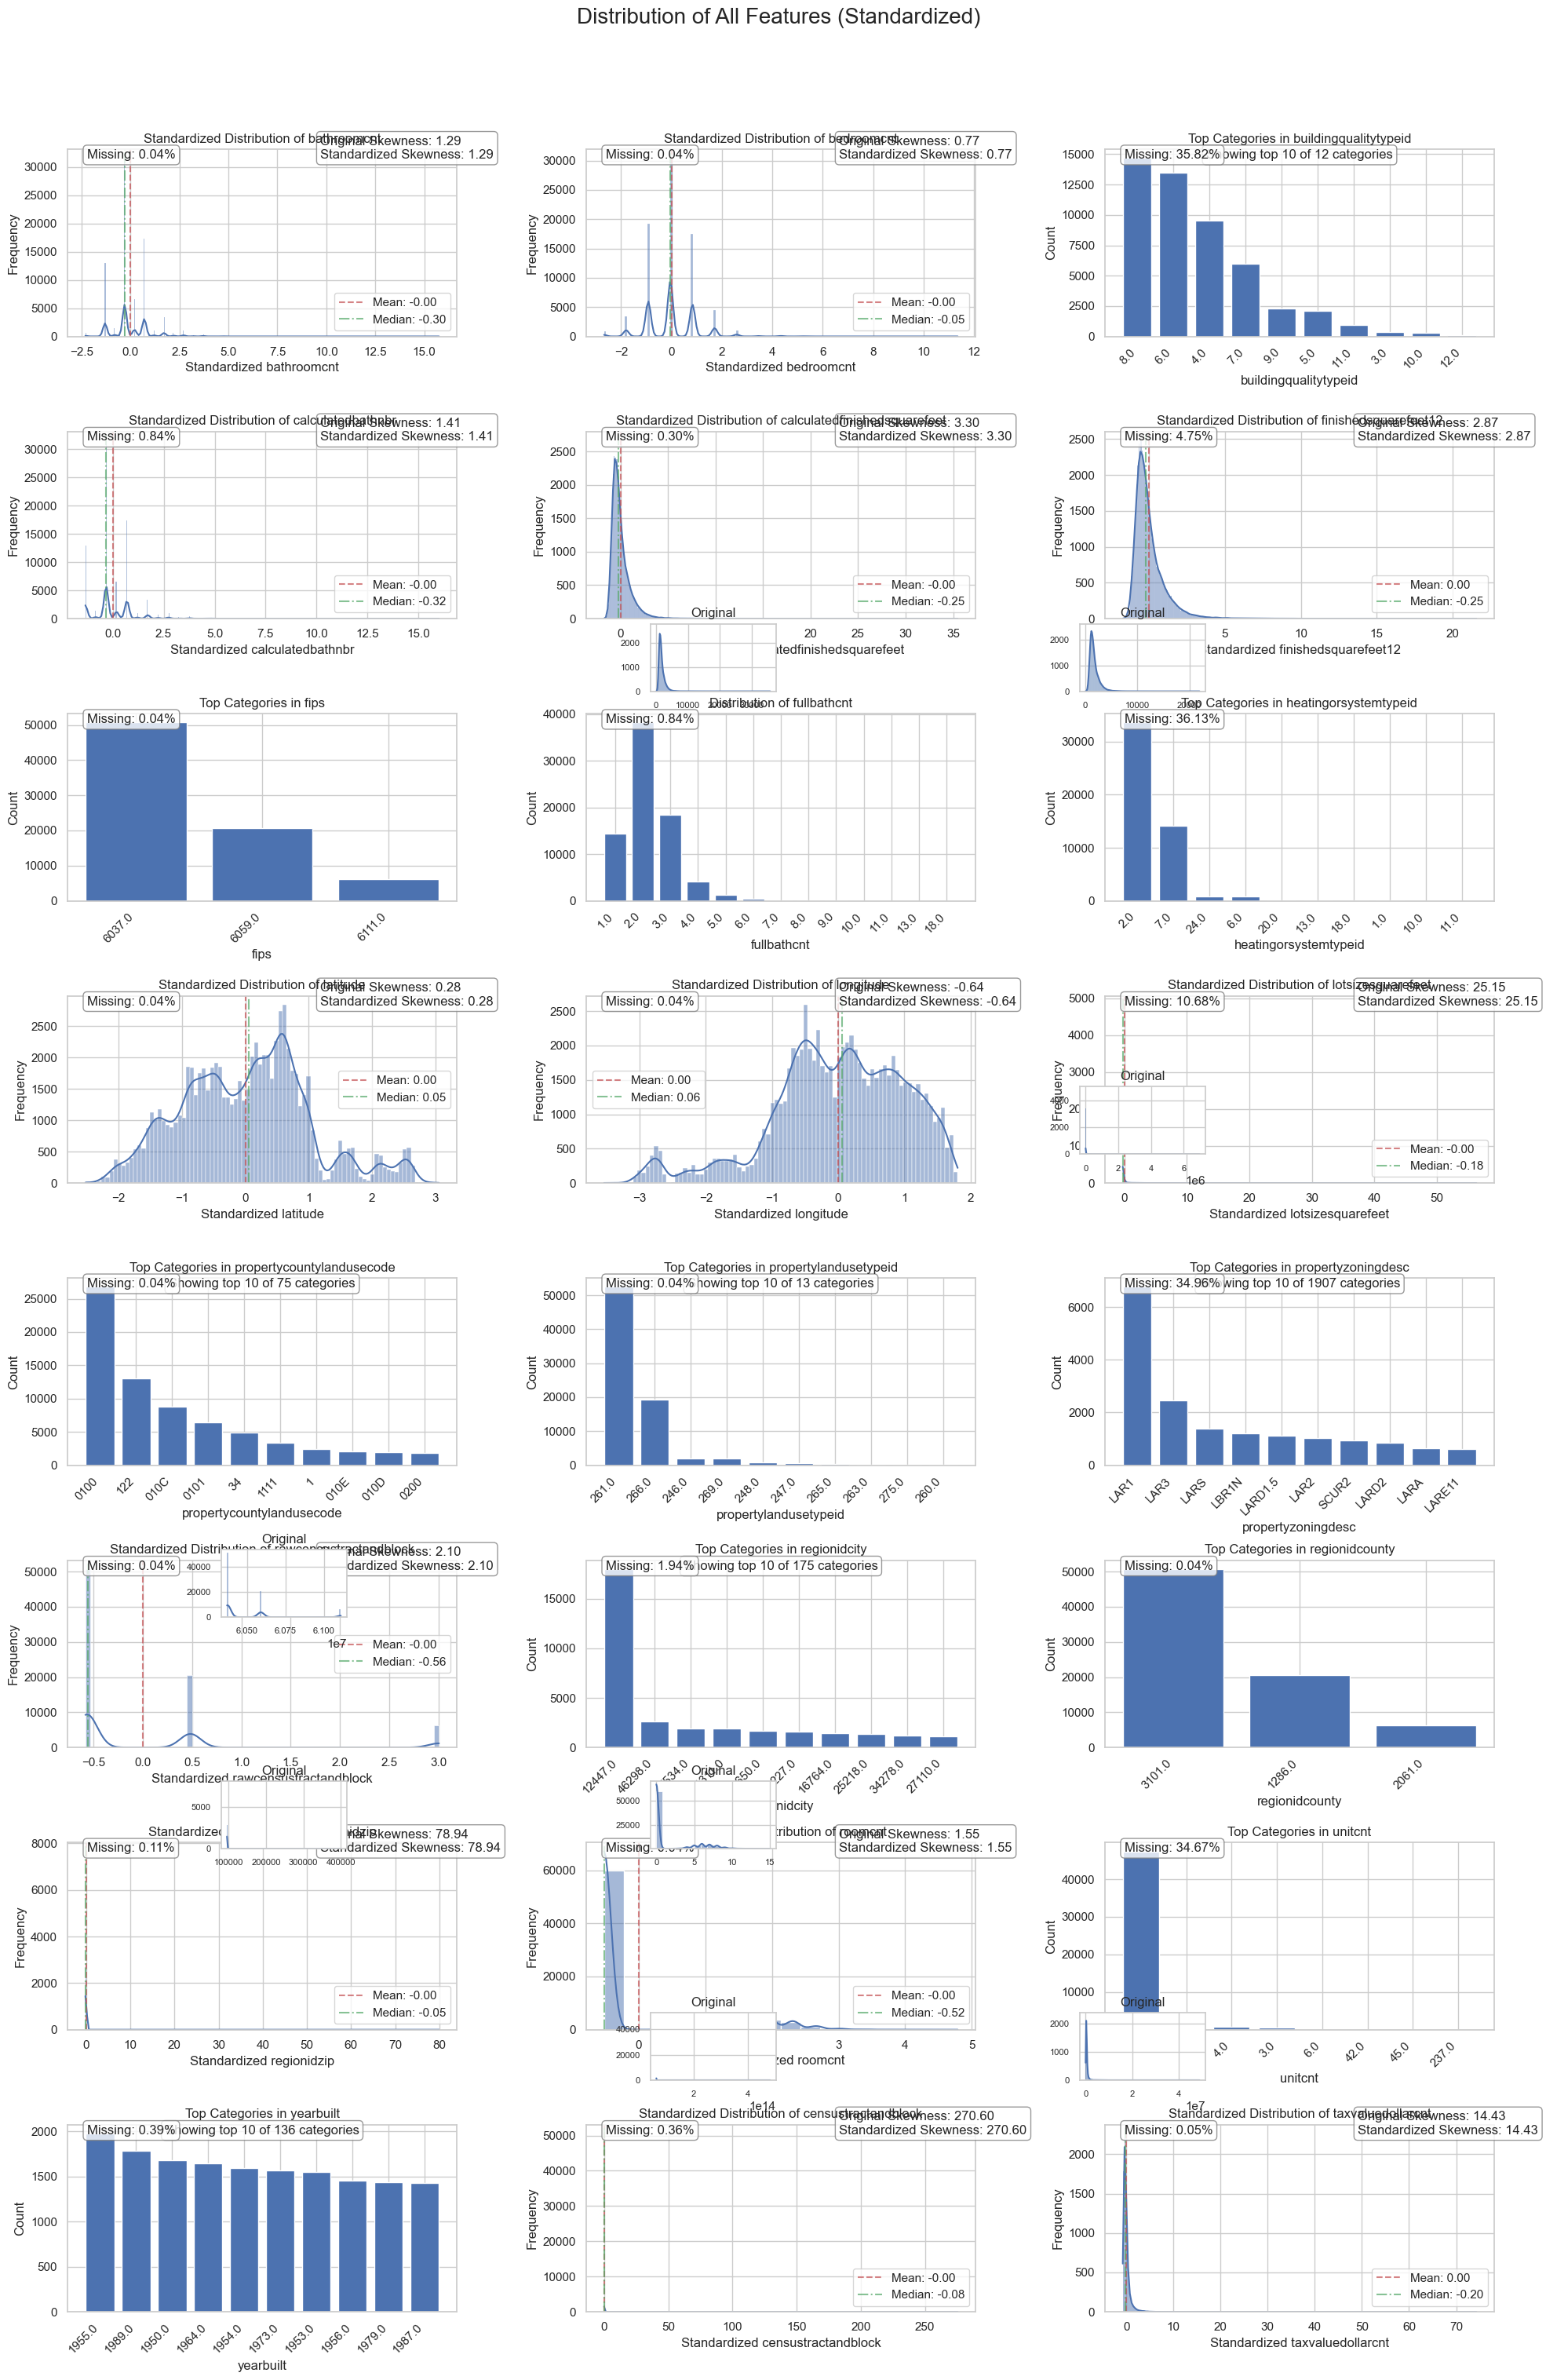

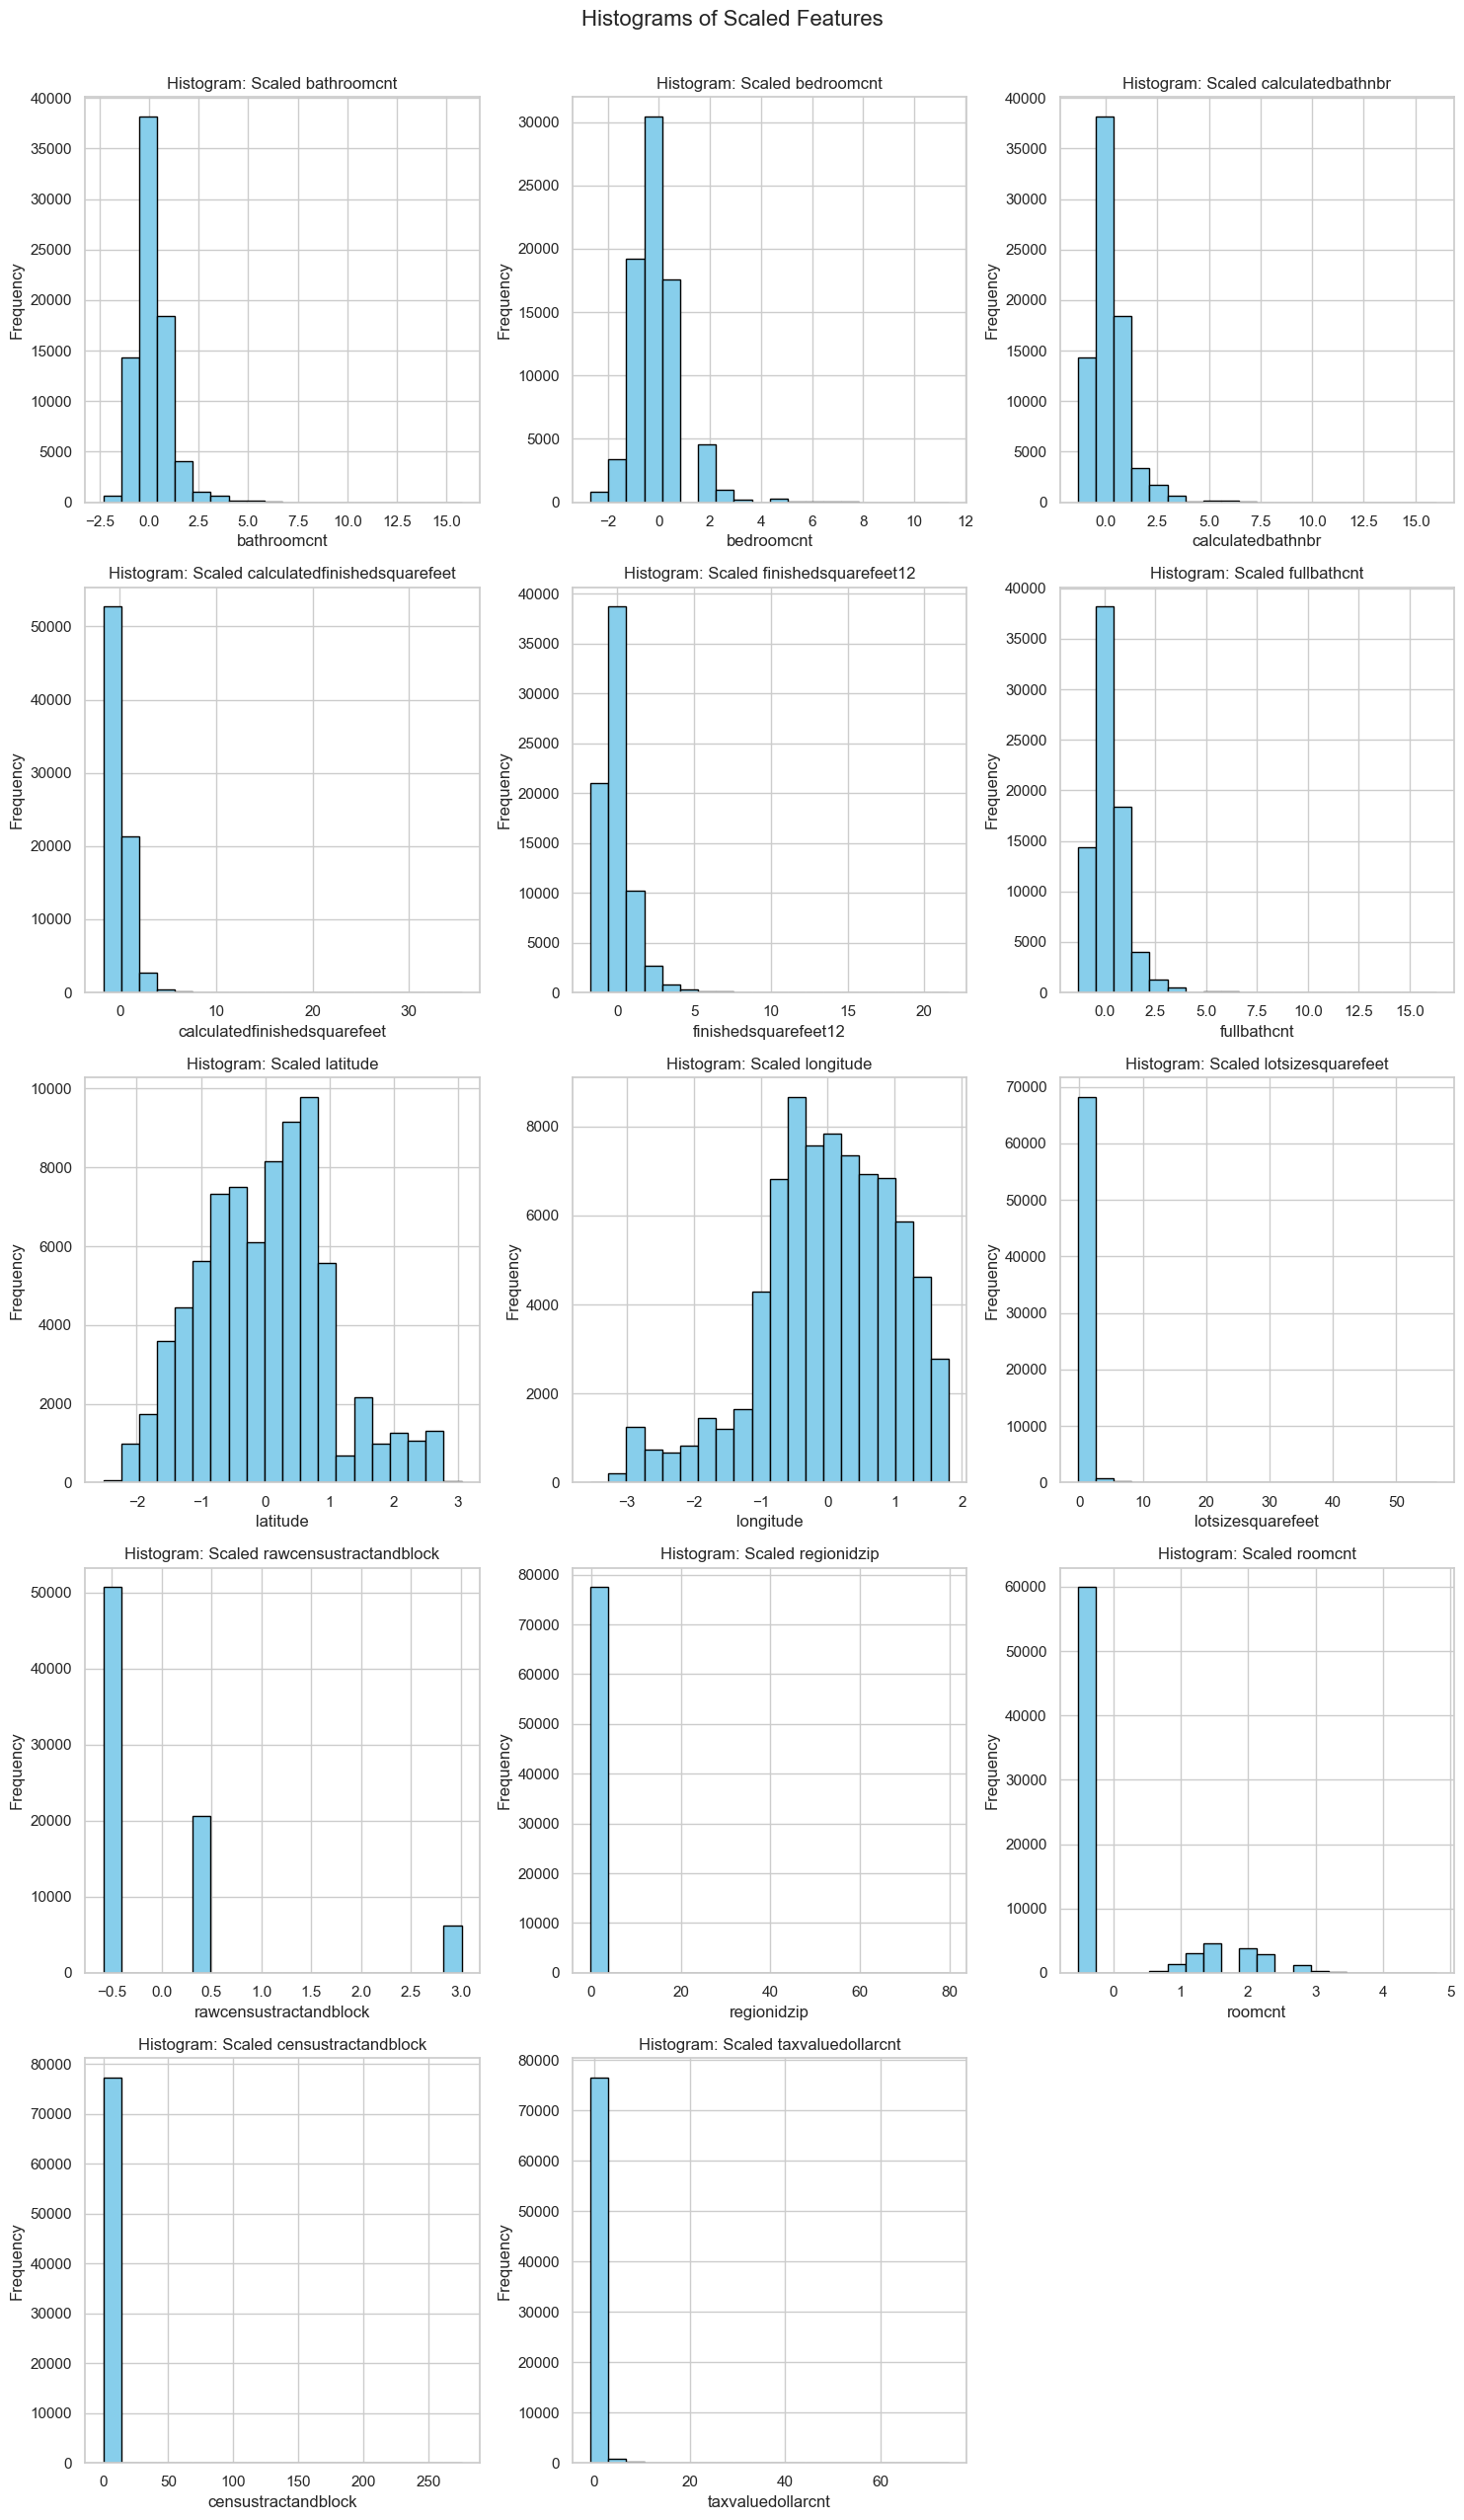

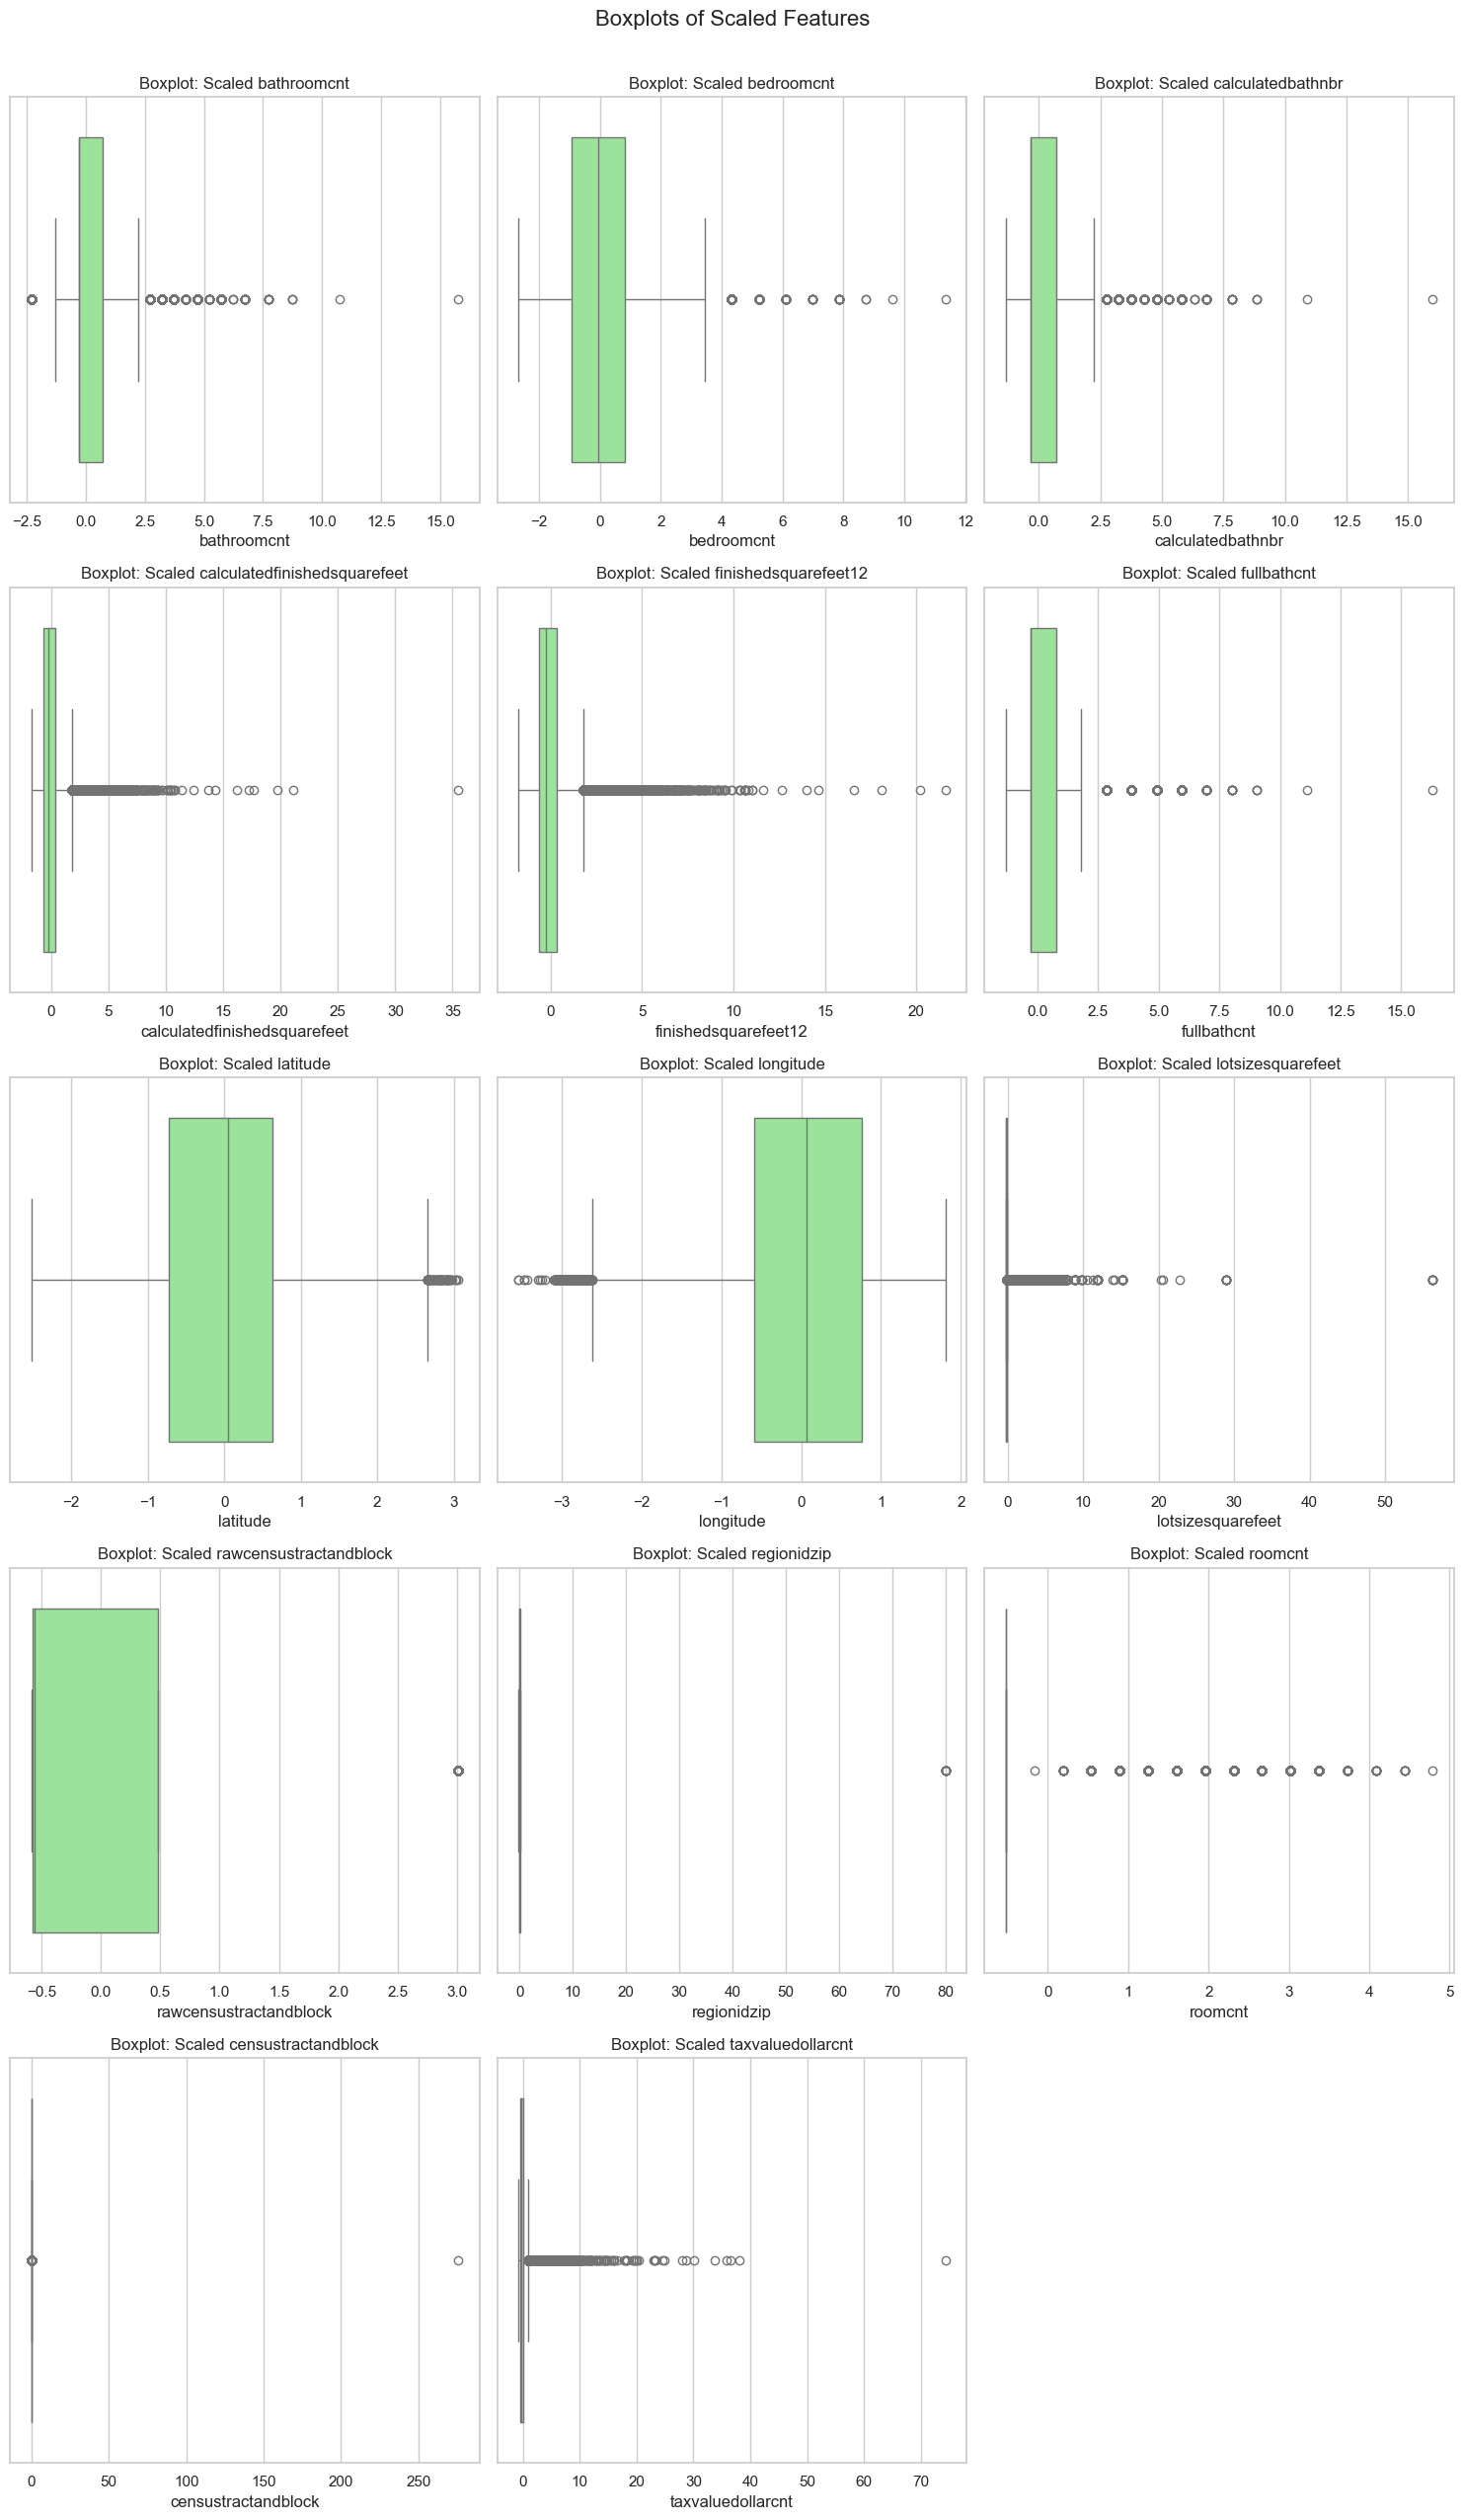

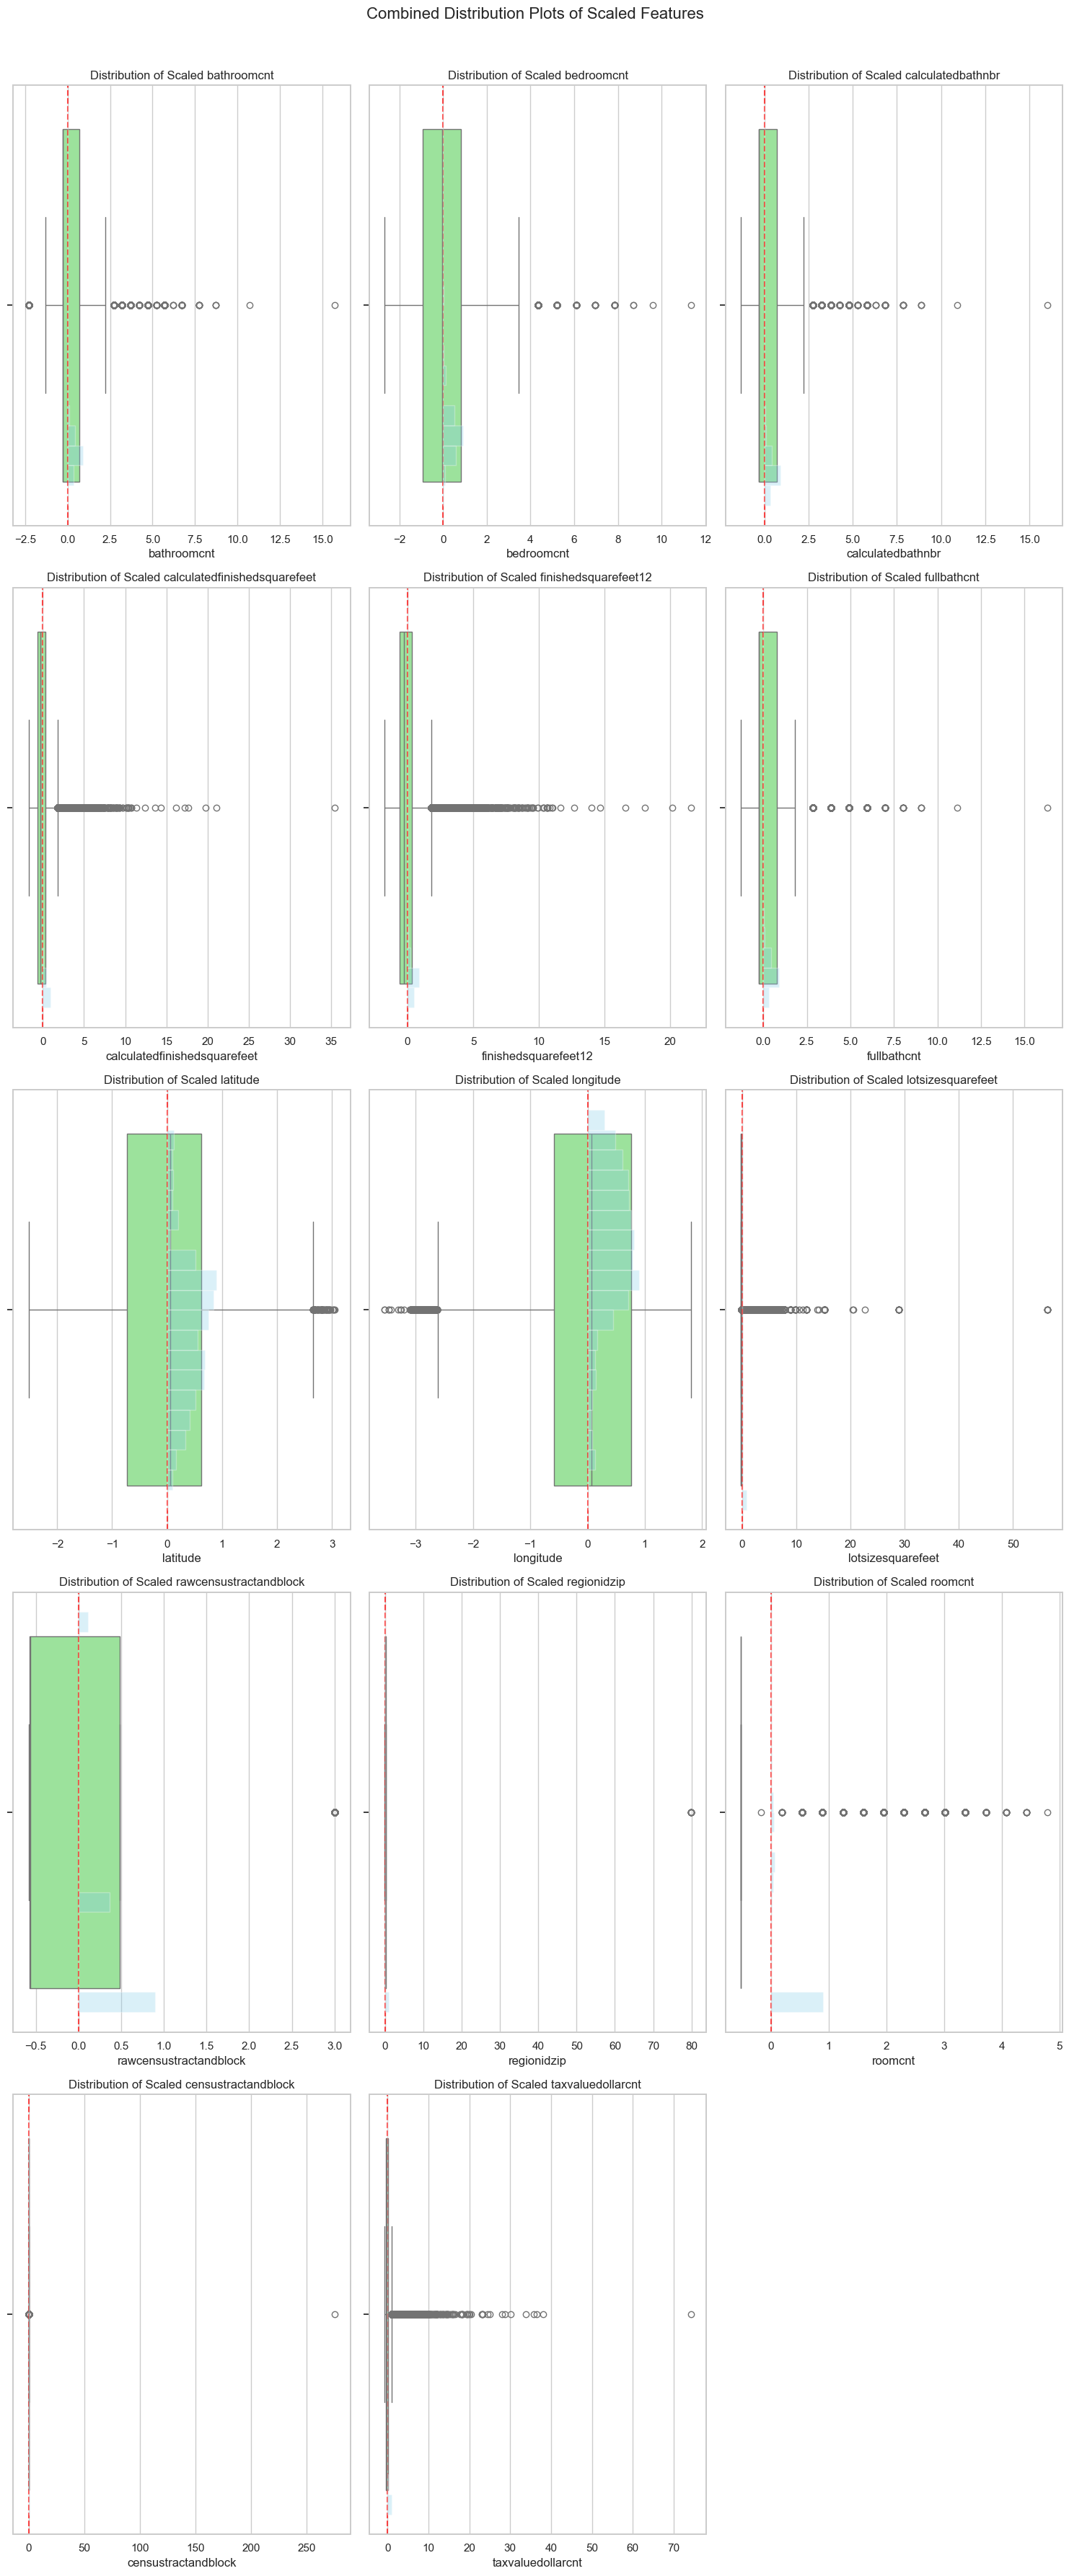

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 1: Identify numerical features
numerical_features = df_categorized.select_dtypes(include=[np.number]).columns.tolist()

# Step 2: Scale the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_categorized[numerical_features]), 
                          columns=numerical_features)

# Step 3: Create a figure with two subplots - one for histograms, one for boxplots
n_features = len(numerical_features)
n_cols = 3  # Number of columns in the subplot grid
n_rows = int(np.ceil(n_features / n_cols))  # Number of rows needed

# Create two separate figures
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes1 = axes1.flatten()  # Flatten the axes arrays for easy iteration
axes2 = axes2.flatten()

# Plot histograms and boxplots for each scaled numerical feature
for i, feature in enumerate(numerical_features):
    # Histogram in first figure
    ax1 = axes1[i]
    ax1.hist(df_scaled[feature].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax1.set_title(f'Histogram: Scaled {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency')
    
    # Boxplot in second figure
    ax2 = axes2[i]
    sns.boxplot(x=df_scaled[feature].dropna(), ax=ax2, color='lightgreen')
    ax2.set_title(f'Boxplot: Scaled {feature}')
    ax2.set_xlabel(feature)

# Hide any unused subplots in both figures
for j in range(i + 1, len(axes1)):
    axes1[j].axis('off')
    axes2[j].axis('off')

# Display both figures
plt.figure(fig1.number)
plt.tight_layout()
plt.suptitle('Histograms of Scaled Features', fontsize=16, y=1.02)

plt.figure(fig2.number)
plt.tight_layout()
plt.suptitle('Boxplots of Scaled Features', fontsize=16, y=1.02)

plt.show()

# Alternative: Combined plot with both histogram and boxplot for each feature
fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows))
axes3 = axes3.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes3[i]
    
    # Create a temporary axis for the histogram
    ax_hist = ax.twinx()
    
    # Plot boxplot on main axis
    sns.boxplot(x=df_scaled[feature].dropna(), ax=ax, color='lightgreen', orient='h')
    
    # Plot histogram on twin axis with transparency
    hist_data, hist_bins = np.histogram(df_scaled[feature].dropna(), bins=20)
    hist_data = hist_data / hist_data.max() * 0.9  # Normalize height
    ax_hist.barh(hist_bins[:-1], hist_data, height=np.diff(hist_bins), 
                alpha=0.3, color='skyblue', align='edge')
    
    # Set titles and labels
    ax.set_title(f'Distribution of Scaled {feature}')
    ax.set_xlabel(feature)
    
    # Hide y-axis labels for histogram
    ax_hist.set_yticks([])
    ax_hist.set_ylim(ax.get_xlim())
    
    # Add vertical line at x=0 (mean after scaling)
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Hide any unused subplots
for j in range(i + 1, len(axes3)):
    axes3[j].axis('off')

plt.tight_layout()
plt.suptitle('Combined Distribution Plots of Scaled Features', fontsize=16, y=1.02)
plt.show()

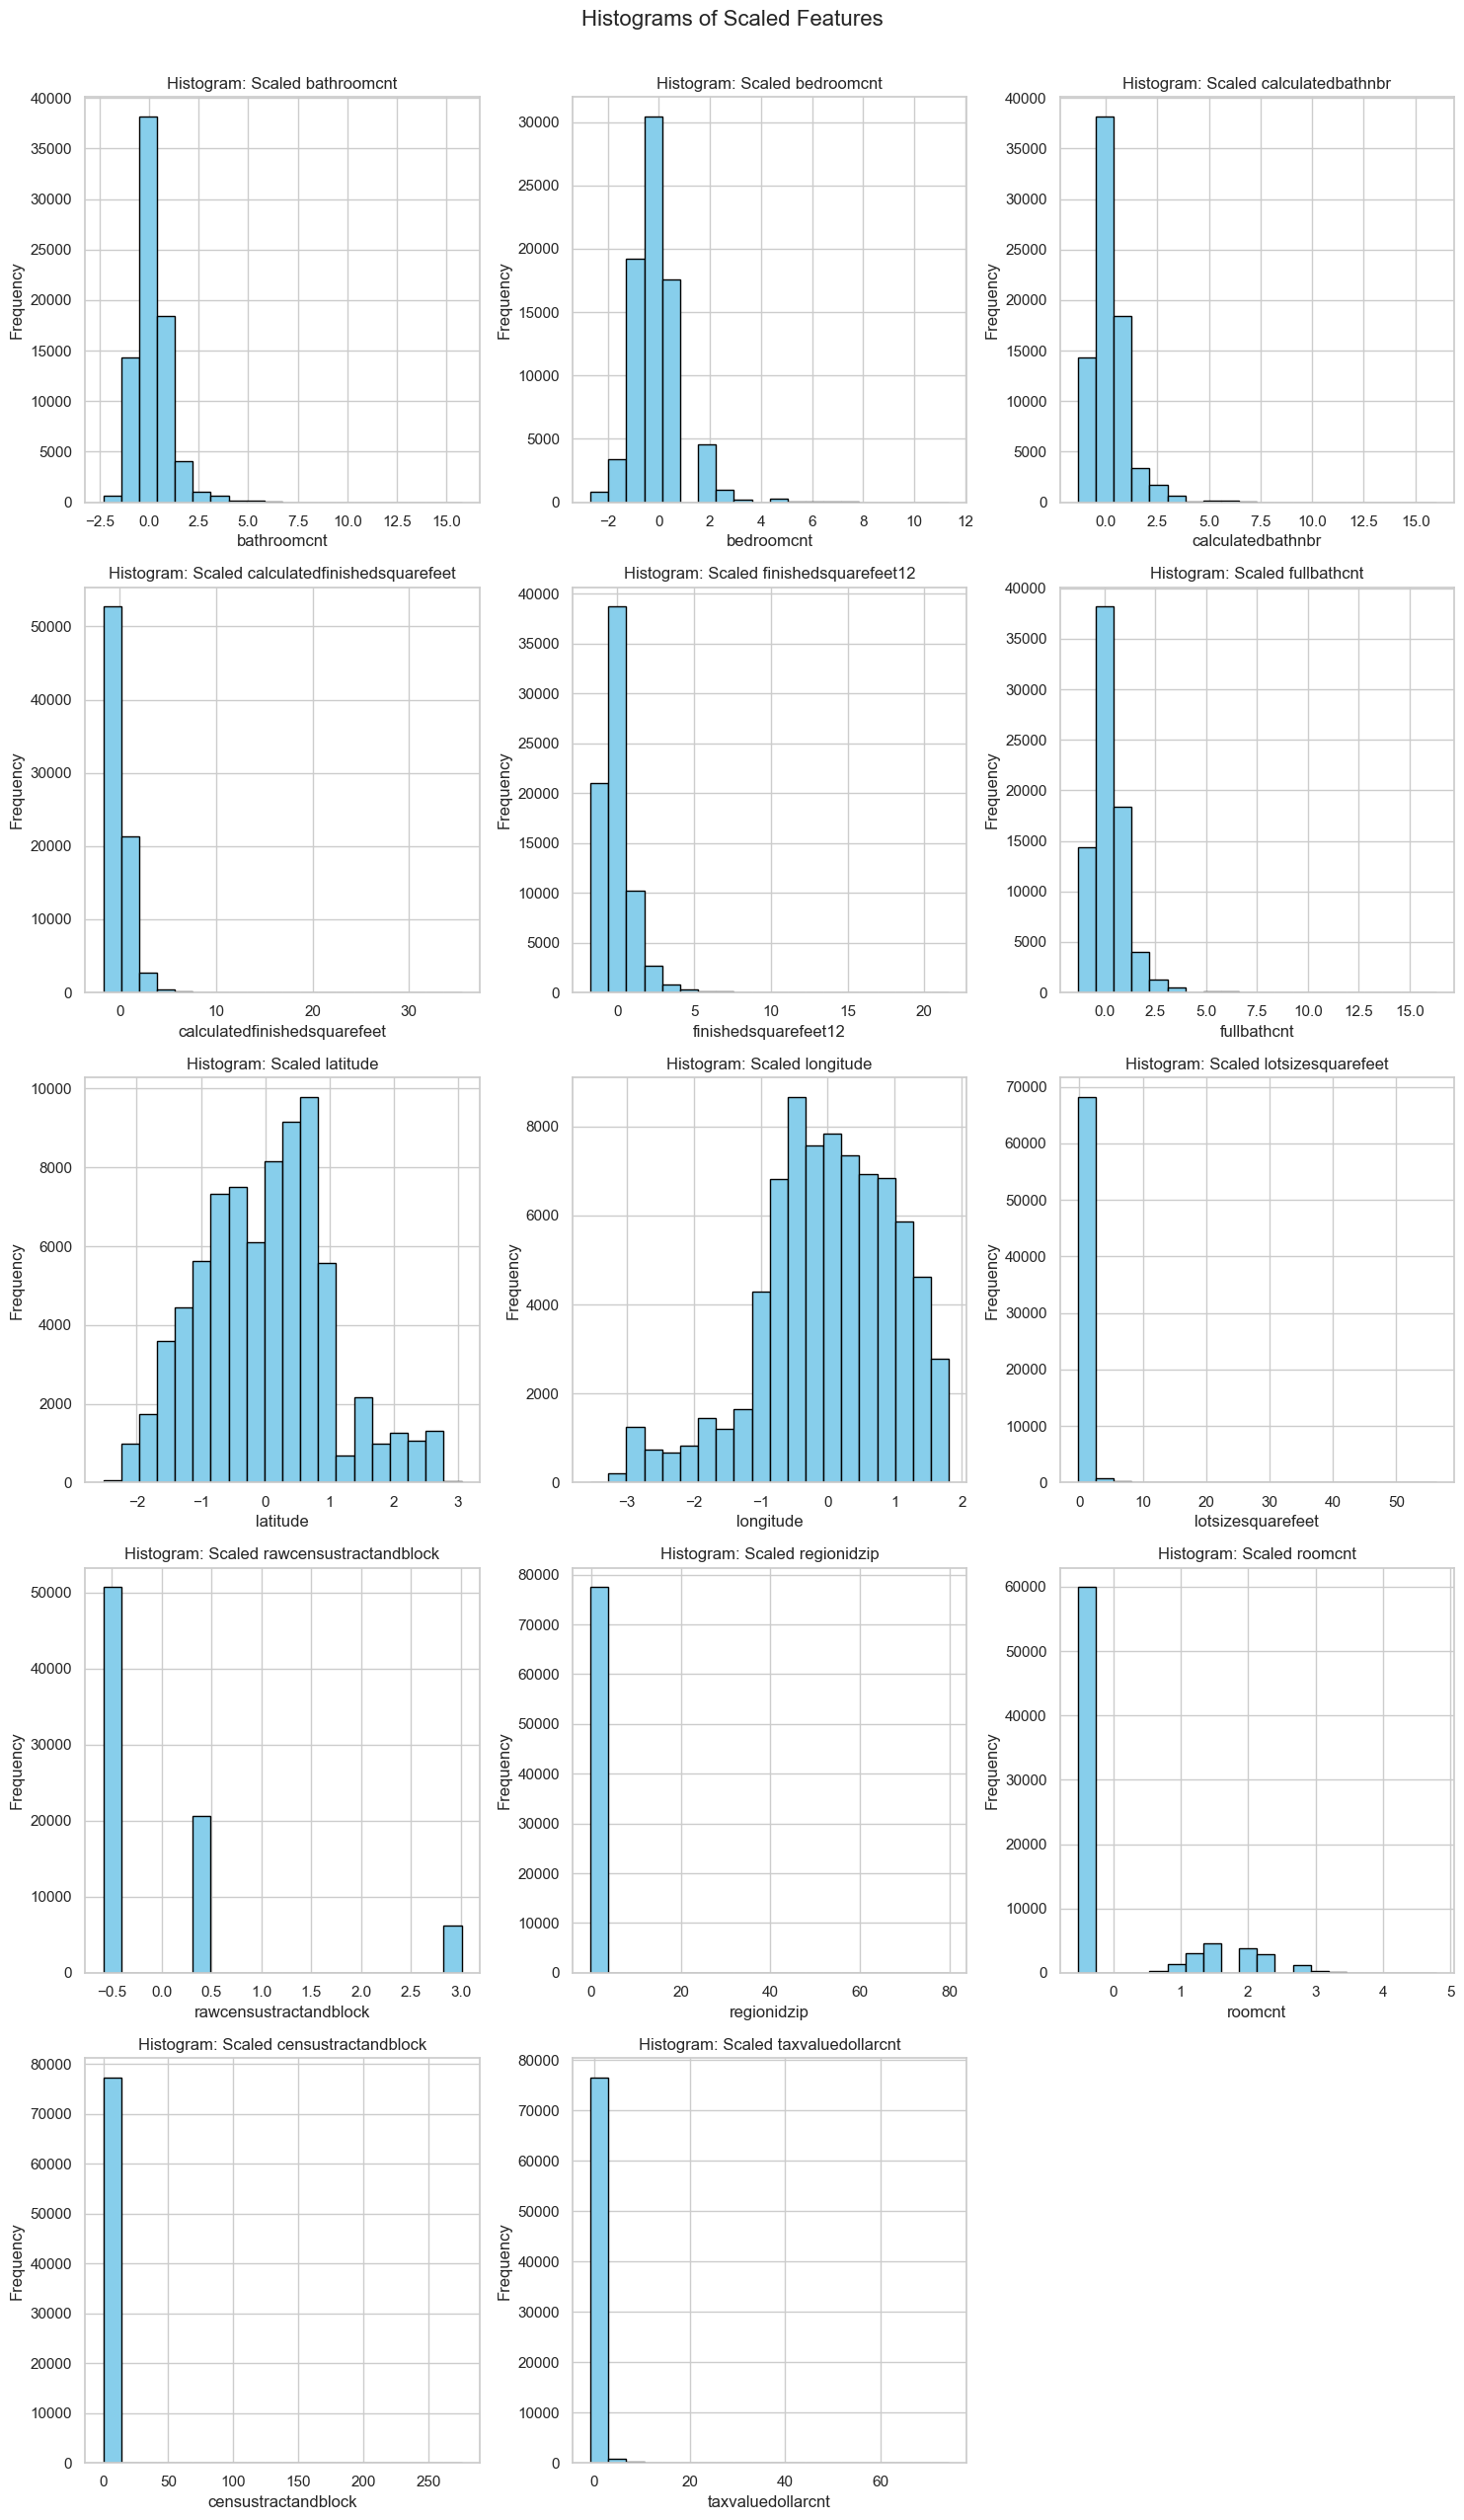

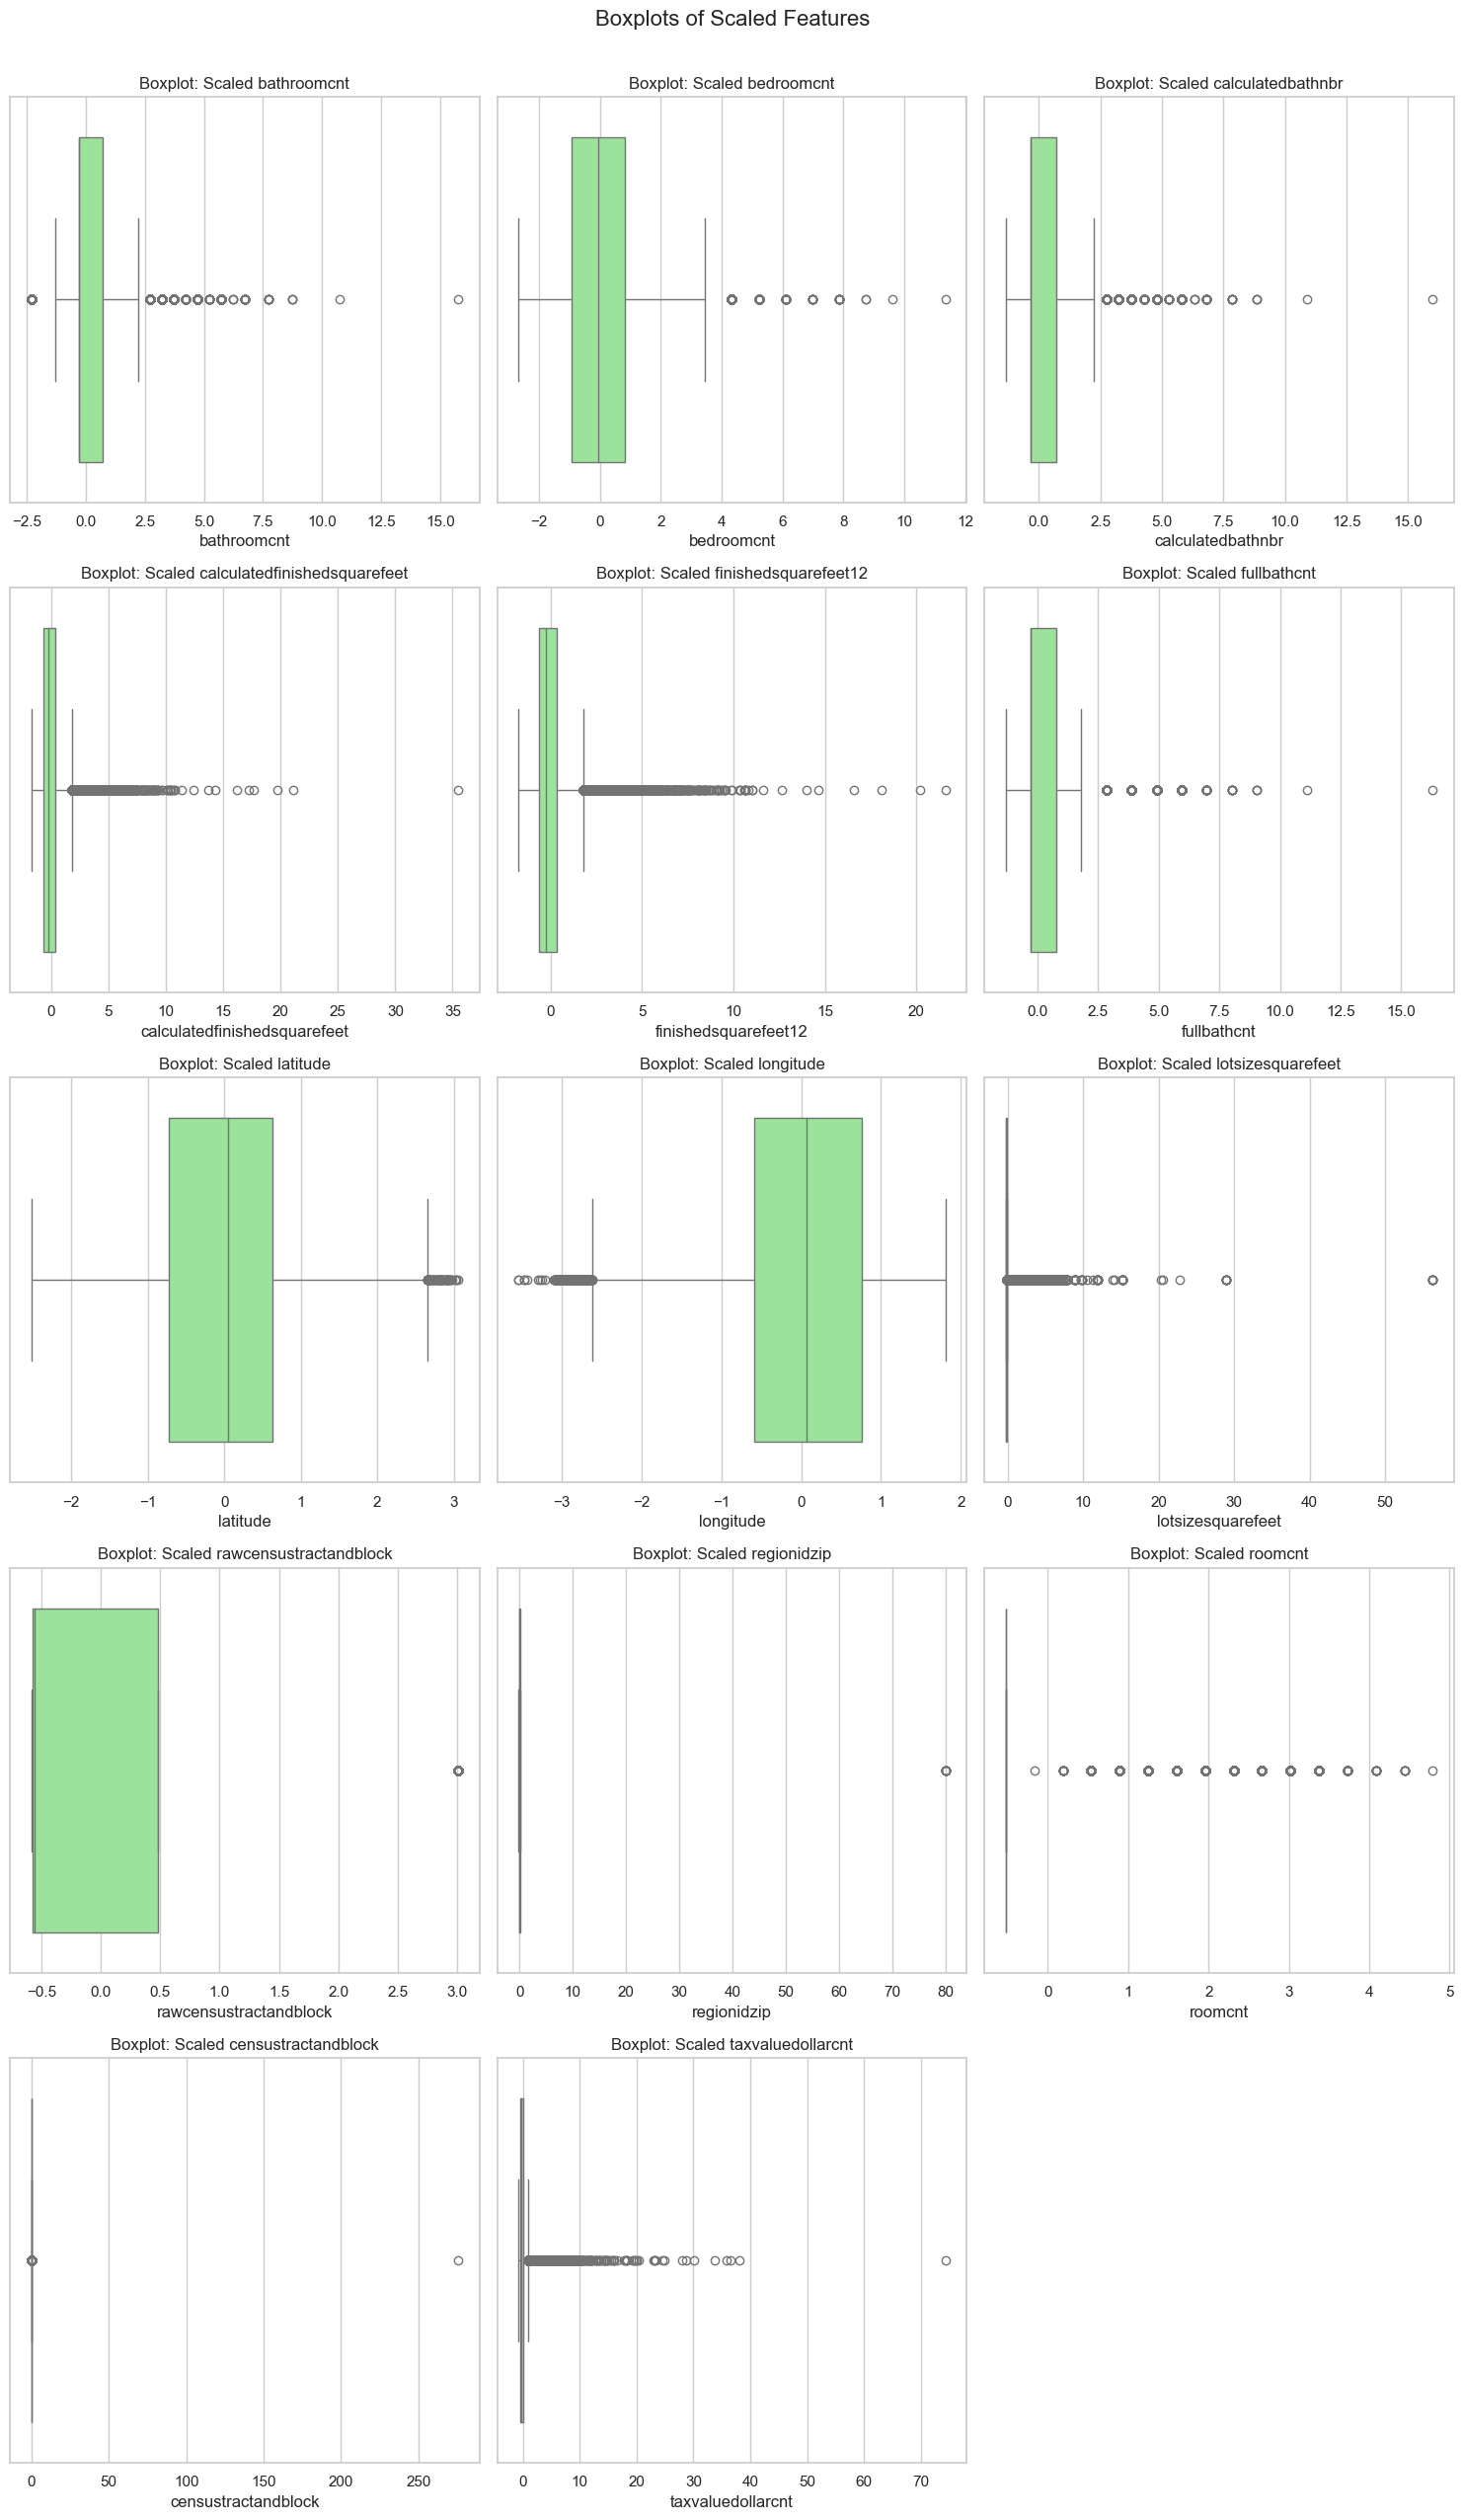

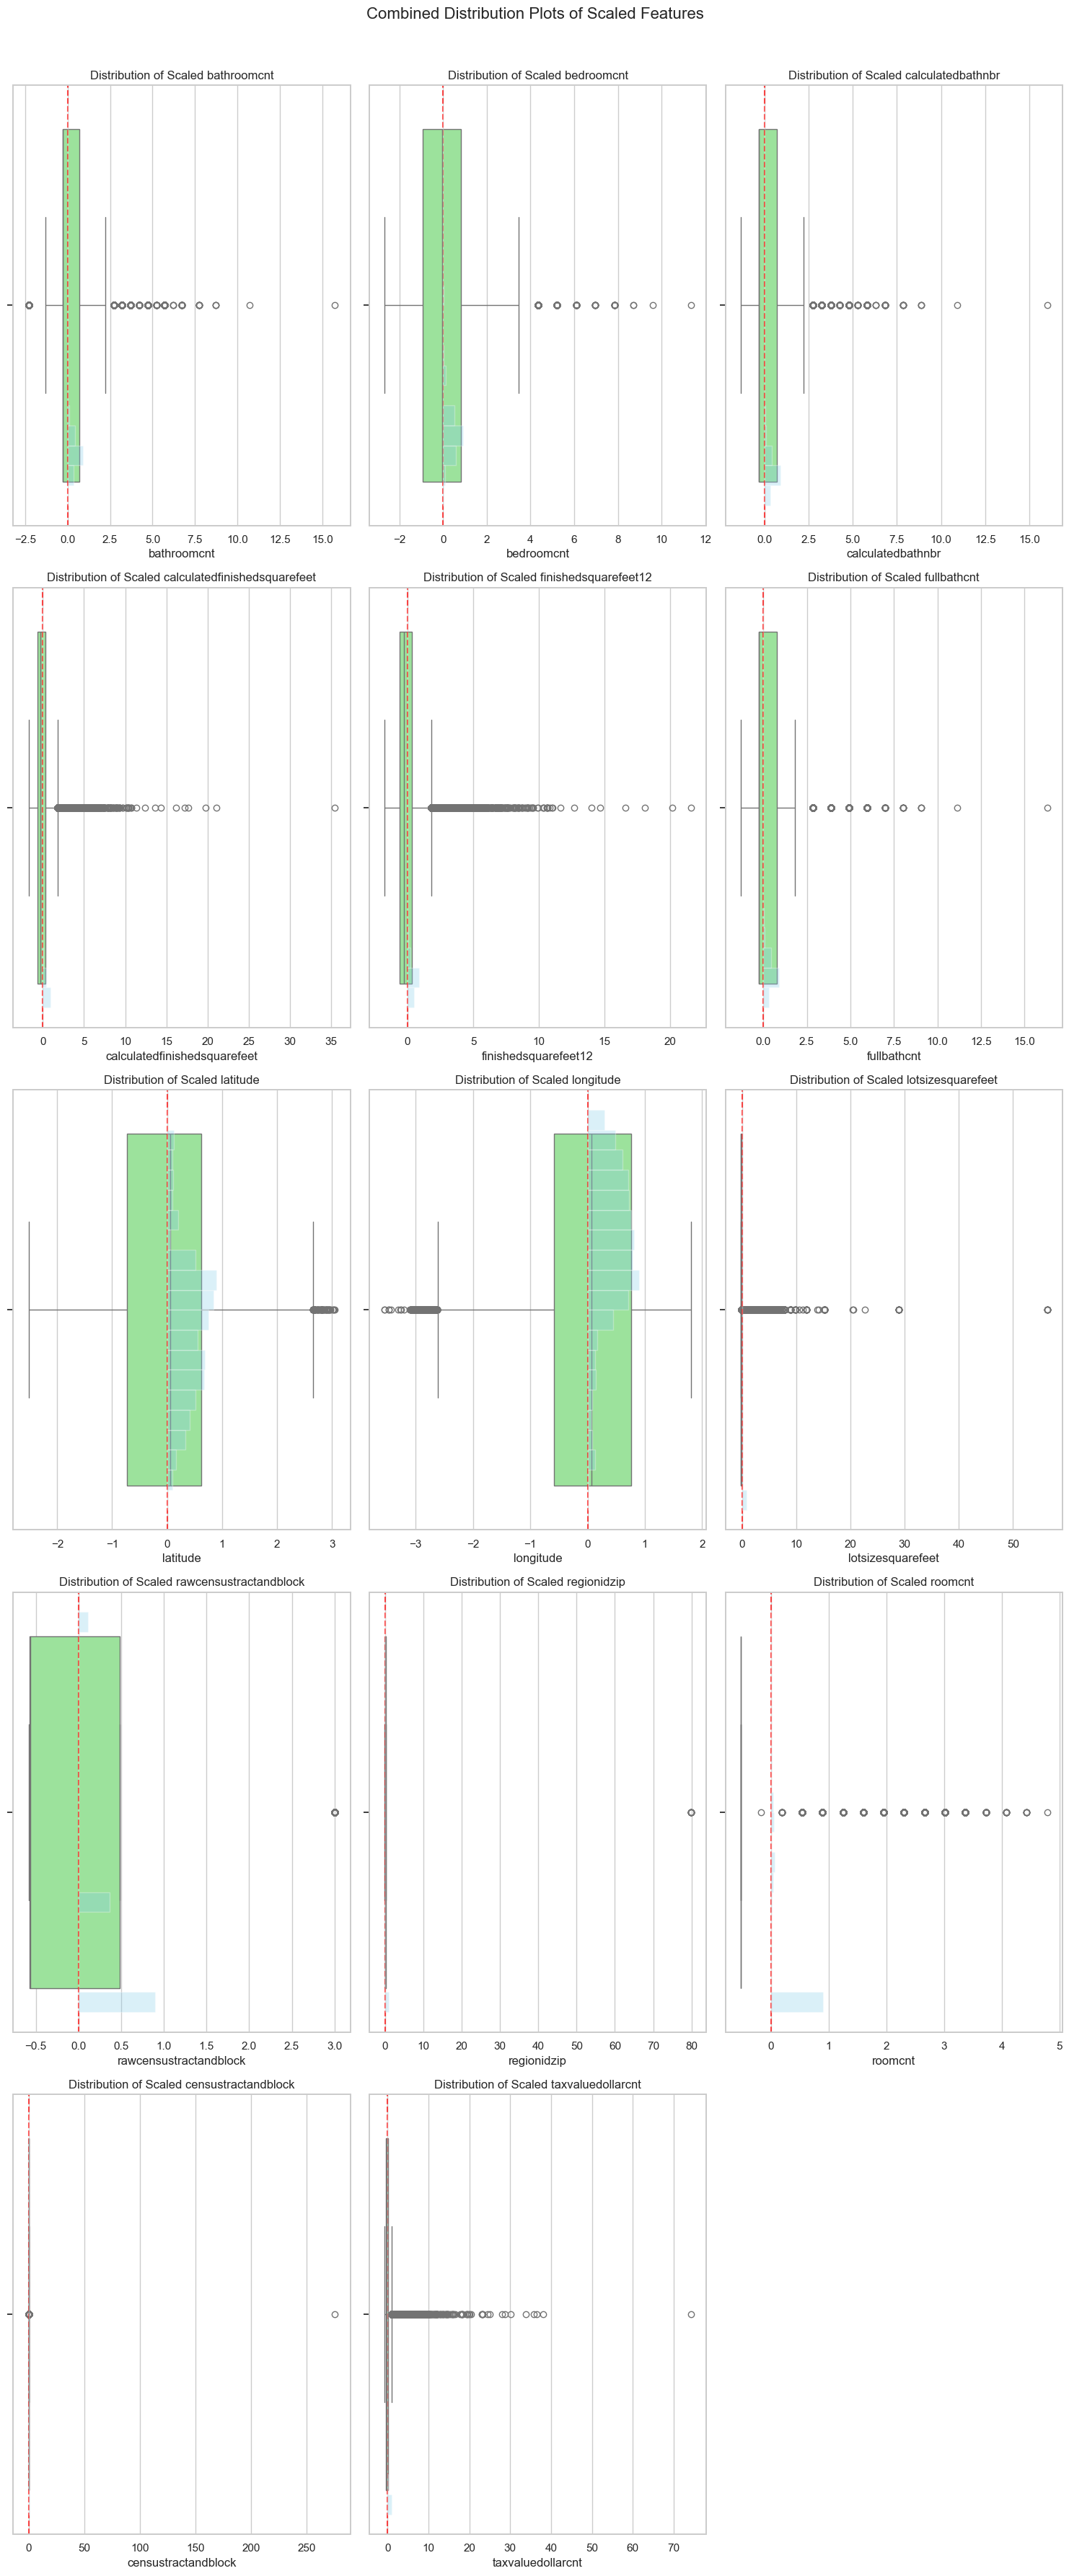

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 1: Identify numerical features
numerical_features = df_categorized.select_dtypes(include=[np.number]).columns.tolist()

# Step 2: Scale the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_categorized[numerical_features]), 
                          columns=numerical_features)

# Step 3: Create a figure with two subplots - one for histograms, one for boxplots
n_features = len(numerical_features)
n_cols = 3  # Number of columns in the subplot grid
n_rows = int(np.ceil(n_features / n_cols))  # Number of rows needed

# Create two separate figures
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes1 = axes1.flatten()  # Flatten the axes arrays for easy iteration
axes2 = axes2.flatten()

# Plot histograms and boxplots for each scaled numerical feature
for i, feature in enumerate(numerical_features):
    # Histogram in first figure
    ax1 = axes1[i]
    ax1.hist(df_scaled[feature].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax1.set_title(f'Histogram: Scaled {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency')
    
    # Boxplot in second figure
    ax2 = axes2[i]
    sns.boxplot(x=df_scaled[feature].dropna(), ax=ax2, color='lightgreen')
    ax2.set_title(f'Boxplot: Scaled {feature}')
    ax2.set_xlabel(feature)

# Hide any unused subplots in both figures
for j in range(i + 1, len(axes1)):
    axes1[j].axis('off')
    axes2[j].axis('off')

# Display both figures
plt.figure(fig1.number)
plt.tight_layout()
plt.suptitle('Histograms of Scaled Features', fontsize=16, y=1.02)

plt.figure(fig2.number)
plt.tight_layout()
plt.suptitle('Boxplots of Scaled Features', fontsize=16, y=1.02)

plt.show()

# Alternative: Combined plot with both histogram and boxplot for each feature
fig3, axes3 = plt.subplots(n_rows, n_cols, figsize=(15, 7 * n_rows))
axes3 = axes3.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes3[i]
    
    # Create a temporary axis for the histogram
    ax_hist = ax.twinx()
    
    # Plot boxplot on main axis
    sns.boxplot(x=df_scaled[feature].dropna(), ax=ax, color='lightgreen', orient='h')
    
    # Plot histogram on twin axis with transparency
    hist_data, hist_bins = np.histogram(df_scaled[feature].dropna(), bins=20)
    hist_data = hist_data / hist_data.max() * 0.9  # Normalize height
    ax_hist.barh(hist_bins[:-1], hist_data, height=np.diff(hist_bins), 
                alpha=0.3, color='skyblue', align='edge')
    
    # Set titles and labels
    ax.set_title(f'Distribution of Scaled {feature}')
    ax.set_xlabel(feature)
    
    # Hide y-axis labels for histogram
    ax_hist.set_yticks([])
    ax_hist.set_ylim(ax.get_xlim())
    
    # Add vertical line at x=0 (mean after scaling)
    ax.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Hide any unused subplots
for j in range(i + 1, len(axes3)):
    axes3[j].axis('off')

plt.tight_layout()
plt.suptitle('Combined Distribution Plots of Scaled Features', fontsize=16, y=1.02)
plt.show()

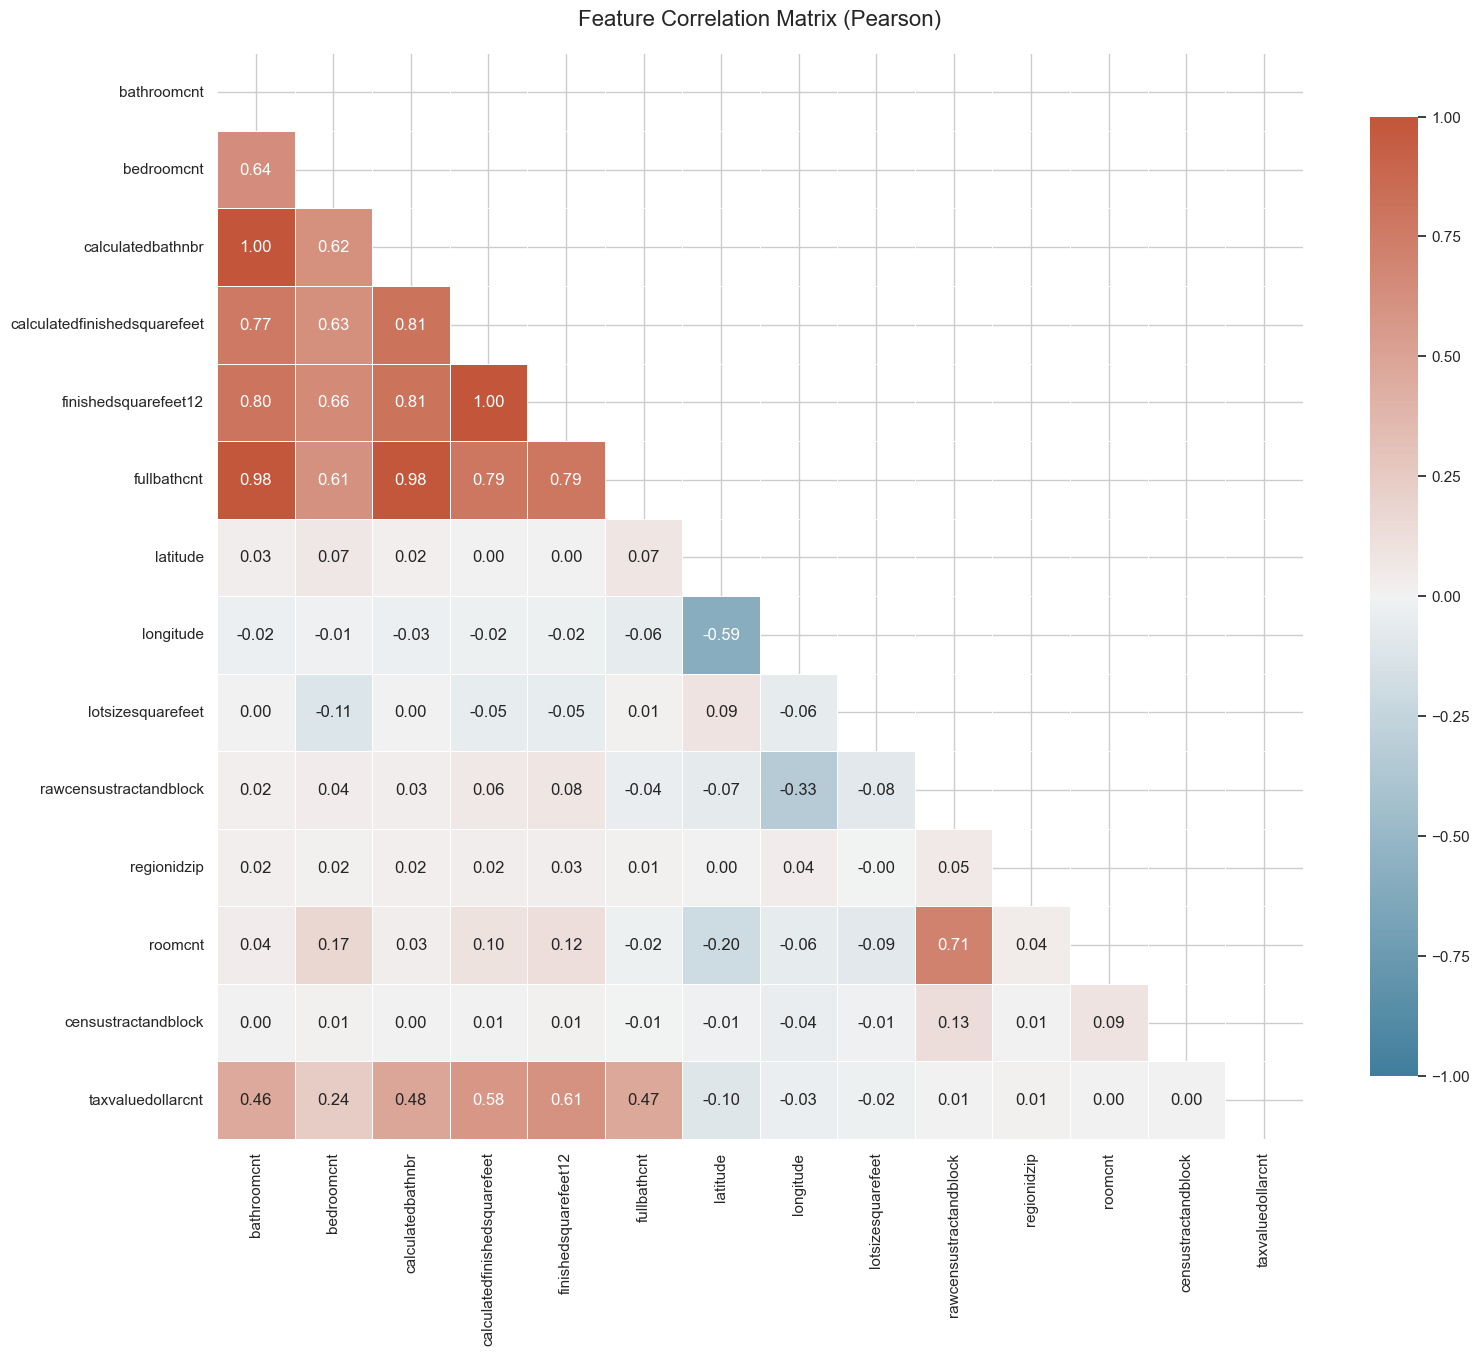

Top correlations with taxvaluedollarcnt:
taxvaluedollarcnt               1.000000
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583155
calculatedbathnbr               0.484819
fullbathcnt                     0.472832
bathroomcnt                     0.461013
bedroomcnt                      0.239326
regionidzip                     0.014548
rawcensustractandblock          0.005643
roomcnt                         0.001960
censustractandblock             0.001563
lotsizesquarefeet              -0.022497
longitude                      -0.032118
latitude                       -0.098225
Name: taxvaluedollarcnt, dtype: float64


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_correlation_matrix(df, method='pearson', figsize=(16, 14), annot=True):
    """
    Plot a correlation matrix heatmap for numerical features in the dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple, default=(16, 14)
        Figure size (width, height) in inches
    annot : bool, default=True
        Whether to annotate cells with correlation values
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr(method=method)
    
    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=annot, 
        fmt=".2f",
        cmap=cmap,
        vmax=1.0,
        vmin=-1.0,
        center=0,
        square=True, 
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )
    
    plt.title(f'Feature Correlation Matrix ({method.capitalize()})', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Generate the correlation matrix
corr_matrix = plot_correlation_matrix(df_categorized)

# Print the top correlations with the target variable
target_correlations = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print("Top correlations with taxvaluedollarcnt:")
print(target_correlations)

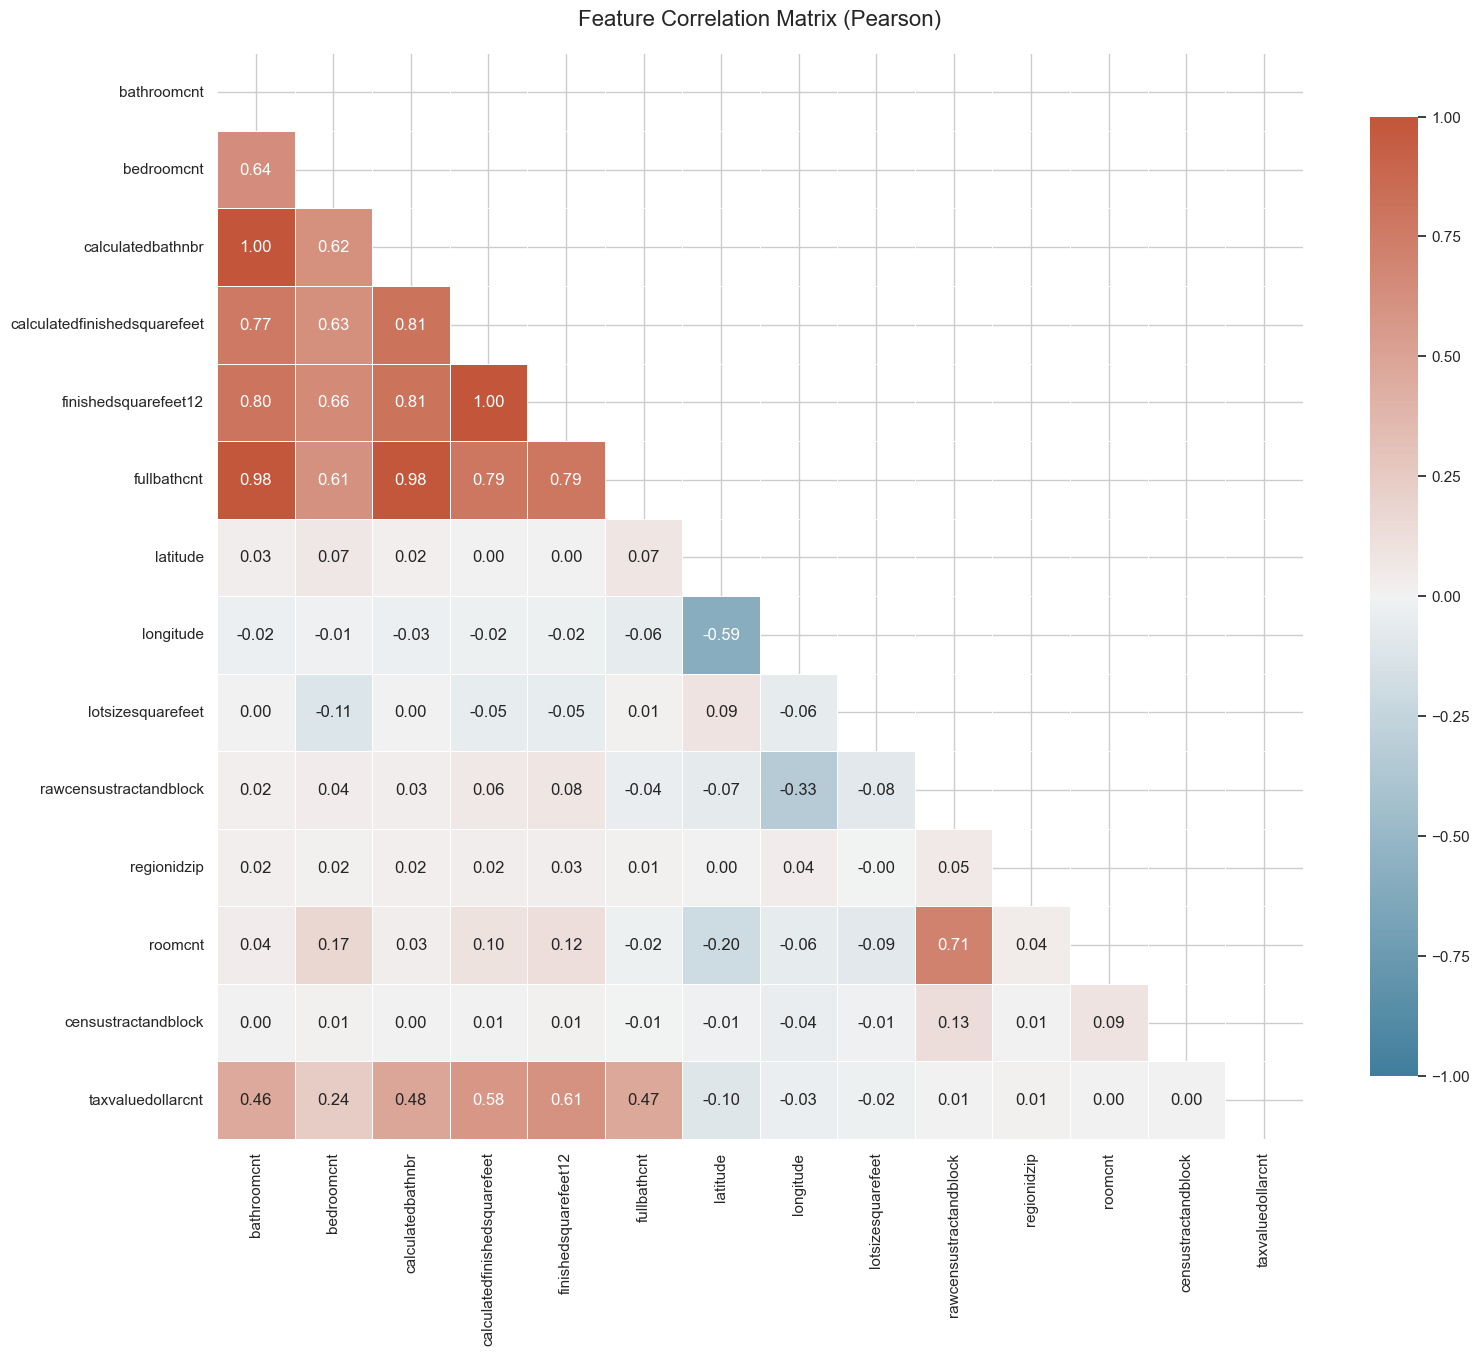

Top correlations with taxvaluedollarcnt:
taxvaluedollarcnt               1.000000
finishedsquarefeet12            0.606334
calculatedfinishedsquarefeet    0.583155
calculatedbathnbr               0.484819
fullbathcnt                     0.472832
bathroomcnt                     0.461013
bedroomcnt                      0.239326
regionidzip                     0.014548
rawcensustractandblock          0.005643
roomcnt                         0.001960
censustractandblock             0.001563
lotsizesquarefeet              -0.022497
longitude                      -0.032118
latitude                       -0.098225
Name: taxvaluedollarcnt, dtype: float64


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_correlation_matrix(df, method='pearson', figsize=(16, 14), annot=True):
    """
    Plot a correlation matrix heatmap for numerical features in the dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple, default=(16, 14)
        Figure size (width, height) in inches
    annot : bool, default=True
        Whether to annotate cells with correlation values
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr(method=method)
    
    # Create mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=annot, 
        fmt=".2f",
        cmap=cmap,
        vmax=1.0,
        vmin=-1.0,
        center=0,
        square=True, 
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )
    
    plt.title(f'Feature Correlation Matrix ({method.capitalize()})', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Generate the correlation matrix
corr_matrix = plot_correlation_matrix(df_categorized)

# Print the top correlations with the target variable
target_correlations = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print("Top correlations with taxvaluedollarcnt:")
print(target_correlations)

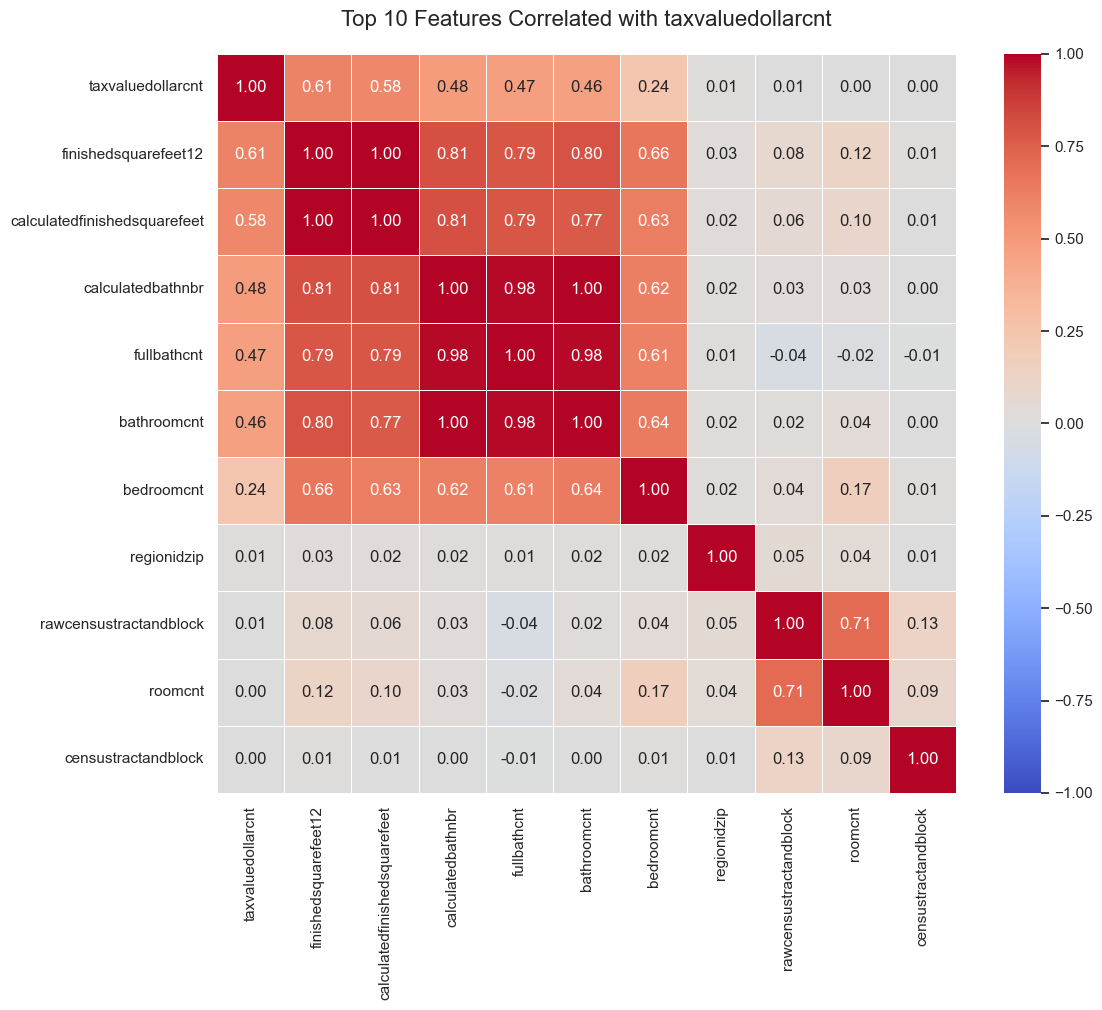

In [121]:
# Create a focused correlation plot of top features correlated with the target
def plot_target_correlations(df, target='taxvaluedollarcnt', top_n=10, method='pearson', figsize=(12, 10)):
    """
    Plot correlations between the target variable and its most correlated features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    target : str, default='taxvaluedollarcnt'
        The target variable name
    top_n : int, default=10
        Number of top correlated features to include
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple, default=(12, 10)
        Figure size (width, height) in inches
    """
    # Get correlation with target
    numeric_df = df.select_dtypes(include=[np.number])
    target_corr = numeric_df.corrwith(df[target], method=method).sort_values(ascending=False)
    
    # Select top N features (excluding the target itself)
    top_features = target_corr.drop(target).head(top_n).index.tolist()
    
    # Create subset with target and top features
    subset = [target] + top_features
    
    # Calculate correlation matrix for this subset
    corr_subset = numeric_df[subset].corr(method=method)
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_subset, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm',
        vmax=1.0, 
        vmin=-1.0,
        center=0,
        square=True,
        linewidths=.5
    )
    
    plt.title(f'Top {top_n} Features Correlated with {target}', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    return top_features

# Show top correlations with target
top_features = plot_target_correlations(df_categorized, top_n=10)

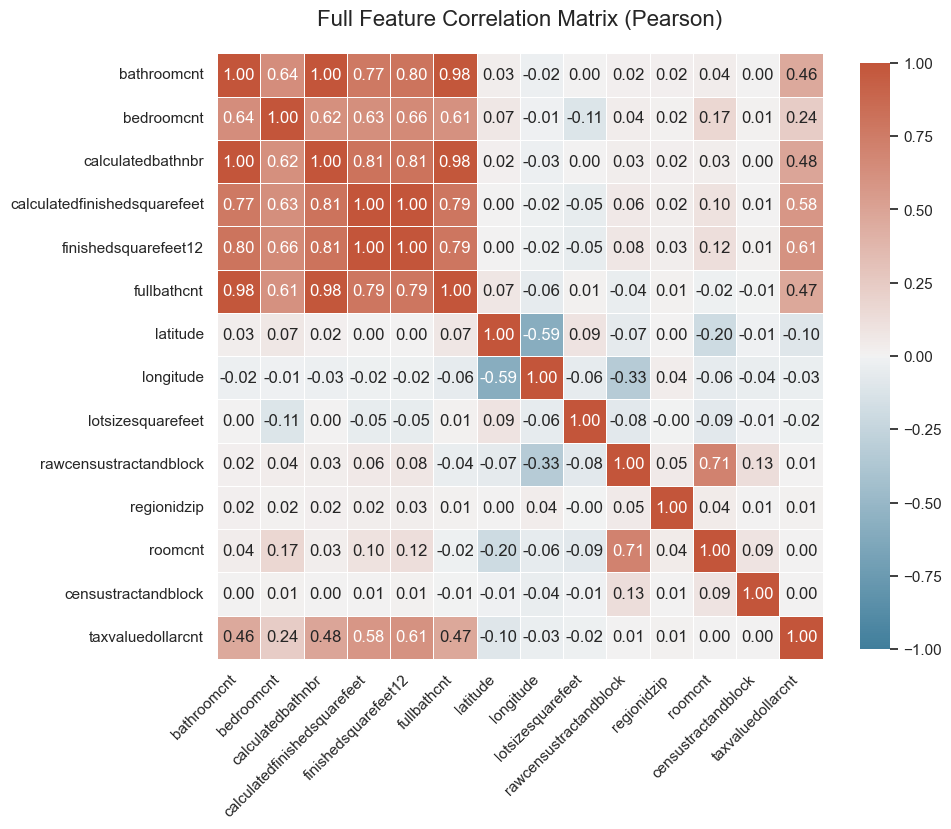


Important Feature Correlations (|r| ≥ 0.5):
                        feature1                      feature2  correlation
0                    bathroomcnt             calculatedbathnbr     1.000000
15  calculatedfinishedsquarefeet          finishedsquarefeet12     1.000000
1                    bathroomcnt                   fullbathcnt     0.984499
11             calculatedbathnbr                   fullbathcnt     0.984499
12             calculatedbathnbr          finishedsquarefeet12     0.809971
13             calculatedbathnbr  calculatedfinishedsquarefeet     0.807093
2                    bathroomcnt          finishedsquarefeet12     0.803920
24          finishedsquarefeet12                   fullbathcnt     0.788357
17  calculatedfinishedsquarefeet                   fullbathcnt     0.786693
3                    bathroomcnt  calculatedfinishedsquarefeet     0.772863
34        rawcensustractandblock                       roomcnt     0.707422
5                     bedroomcnt          f

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_full_correlation_matrix(df, method='pearson', figsize=(10, 9)):
    """
    Plot a correlation matrix heatmap for all numerical features in the dataframe,
    including relationships between all features and with the target variable.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple, default=(20, 18)
        Figure size (width, height) in inches
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate correlation matrix
    corr_matrix = numeric_df.corr(method=method)
    
    # Set up the matplotlib figure
    plt.figure(figsize=figsize)
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f",
        cmap=cmap,
        vmax=1.0,
        vmin=-1.0,
        center=0,
        square=True, 
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )
    
    # Adjust the plot
    plt.title(f'Full Feature Correlation Matrix ({method.capitalize()})', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Generate the complete correlation matrix
corr_matrix = plot_full_correlation_matrix(df_categorized)

# Optional: Create a DataFrame with the most important correlations for each feature
def get_important_correlations(corr_matrix, threshold=0.5):
    """
    Extract important correlations for each feature.
    
    Parameters:
    -----------
    corr_matrix : pandas DataFrame
        Correlation matrix
    threshold : float, default=0.5
        Minimum absolute correlation value to include
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with important correlations for each feature
    """
    important_corrs = []
    
    for col in corr_matrix.columns:
        # Get correlations for this feature and sort by absolute value
        feature_corrs = corr_matrix[col].drop(col)  # Drop self-correlation
        feature_corrs = feature_corrs[abs(feature_corrs) >= threshold].sort_values(ascending=False)
        
        if not feature_corrs.empty:
            for other_feat, corr_val in feature_corrs.items():
                important_corrs.append({
                    'feature1': col,
                    'feature2': other_feat,
                    'correlation': corr_val
                })
    
    # Create DataFrame from results and remove duplicates
    result_df = pd.DataFrame(important_corrs)
    
    # Remove duplicate pairs (e.g., if we have A→B, we don't need B→A)
    seen_pairs = set()
    rows_to_keep = []
    
    for _, row in result_df.iterrows():
        # Create a sorted tuple of the feature pair to identify duplicates
        pair = tuple(sorted([row['feature1'], row['feature2']]))
        if pair not in seen_pairs:
            seen_pairs.add(pair)
            rows_to_keep.append(True)
        else:
            rows_to_keep.append(False)
    
    # Filter the DataFrame
    result_df = result_df[rows_to_keep]
    
    # Sort by absolute correlation value
    return result_df.sort_values('correlation', key=abs, ascending=False)

# Print important correlations
important_correlations = get_important_correlations(corr_matrix, threshold=0.5)
print("\nImportant Feature Correlations (|r| ≥ 0.5):")
print(important_correlations)

# Specifically show correlations with the target variable
target_correlations = corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)
print("\nCorrelations with Target Variable (taxvaluedollarcnt):")
print(target_correlations)

Correlation matrix analysis:

### Strong Correlations with the Target Variable (taxvaluedollarcnt)

The features most strongly correlated with property tax value are:

1. **finishedsquarefeet12** (0.61): The finished living area square footage shows the strongest correlation with tax value, which makes intuitive sense as larger homes typically have higher values.

2. **calculatedfinishedsquarefeet** (0.58): Similarly, this square footage measurement is strongly correlated with property value.

3. **calculatedbathnbr** (0.48): The number of bathrooms has a moderate positive correlation with property value.

4. **fullbathcnt** (0.47): Full bathrooms specifically also show a moderate correlation.

5. **bathroomcnt** (0.46): The total bathroom count is similarly correlated.

6. **bedroomcnt** (0.24): Bedroom count has a weaker positive correlation than bathrooms and square footage.

### Multicollinearity Between Features

The matrix reveals several groups of highly correlated features:

1. **Bathroom-related features**:
   - bathroomcnt, calculatedbathnbr, and fullbathcnt are almost perfectly correlated (0.98-1.00)
   - These three features are essentially measuring the same thing

2. **Square footage measurements**:
   - calculatedfinishedsquarefeet and finishedsquarefeet12 are perfectly correlated (1.00)
   - This confirms they're redundant features

3. **Geographic coordinates**:
   - latitude and longitude have a moderate negative correlation (-0.59)
   - This indicates the geographic orientation of properties in the dataset

4. **Census data**:
   - rawcensustractandblock and roomcnt have a strong correlation (0.71)
   - This might indicate regional patterns in home sizes or layouts

### Low or No Correlations

Several features show very little correlation with the target variable:

- **censustractandblock** (0.00)
- **roomcnt** (0.00)
- **regionidzip** (0.01)
- **lotsizesquarefeet** (-0.02)
- **longitude** (-0.03)
- **latitude** (-0.10)

### Recommendations Based on Correlation Analysis

1. **Feature Selection**: You can reduce dimensionality by keeping only one feature from each highly correlated group:
   - Keep either bathroomcnt, calculatedbathnbr, or fullbathcnt (not all three)
   - Keep either calculatedfinishedsquarefeet or finishedsquarefeet12 (not both)

2. **Important Predictors**: Focus on square footage and bathroom features as they show the strongest relationship with property value.

3. **Geographic Features**: Despite low direct correlations with the target, latitude and longitude might be valuable for capturing neighborhood effects when used together or transformed (e.g., into clusters or distance metrics from city centers).

4. **Feature Engineering**: Consider creating ratio features like:
   - Square footage per bedroom
   - Bathrooms per bedroom
   - Value per square foot

This correlation analysis provides a foundation for feature selection and engineering, which will be essential for building an effective predictive model for property tax values.

In [125]:
# Create a new dataframe by dropping redundant features
redundant_features = ['calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12']

# Create a new dataframe without the redundant features
df_zillow_1 = df_categorized.drop(columns=redundant_features).copy()

# Verify the changes
print(f"Original df_categorized shape: {df_categorized.shape}")
print(f"New df_zillow_1 shape: {df_zillow_1.shape}")  # Fixed variable name here
print(f"Dropped features: {redundant_features}")

# Display the first few rows of the new dataframe
df_zillow_1.head()

Original df_categorized shape: (77613, 24)
New df_zillow_1 shape: (77613, 21)
Dropped features: ['calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12']


bathroomcnt  bedroomcnt buildingqualitytypeid  \
0          3.5         4.0                   NaN   
1          1.0         2.0                   NaN   
2          2.0         3.0                   NaN   
3          3.0         4.0                   8.0   
4          3.0         3.0                   8.0   

   calculatedfinishedsquarefeet    fips heatingorsystemtypeid    latitude  \
0                        3100.0  6059.0                   NaN  33634931.0   
1                        1465.0  6111.0                   NaN  34449266.0   
2                        1243.0  6059.0                   NaN  33886168.0   
3                        2376.0  6037.0                   2.0  34245180.0   
4                        1312.0  6037.0                   2.0  34185120.0   

     longitude  lotsizesquarefeet propertycountylandusecode  ...  \
0 -117869207.0             4506.0                       122  ...   
1 -119281531.0            12647.0                      1110  ...   
2 -117823170.0             8432.0                       122  ...   
3 -118240722.0            13038.0                      0101  ...   
4 -118414640.0           278581.0                      010C  ...   

  propertyzoningdesc rawcensustractandblock  regionidcity regionidcounty  \
0                NaN           6.059063e+07       53571.0         1286.0   
1                NaN           6.111001e+07       13091.0         2061.0   
2                NaN           6.059022e+07       21412.0         1286.0   
3         LCR110000*           6.037300e+07      396551.0         3101.0   
4               LAR3           6.037124e+07       12447.0         3101.0   

  regionidzip  roomcnt  unitcnt yearbuilt censustractandblock  \
0     96978.0      0.0      NaN    1998.0        6.059063e+13   
1     97099.0      5.0      NaN    1967.0        6.111001e+13   
2     97078.0      6.0      NaN    1962.0        6.059022e+13   
3     96330.0      0.0      1.0    1970.0        6.037300e+13   
4     96451.0      0.0      1.0    1964.0        6.037124e+13   

   taxvaluedollarcnt  
0          1023282.0  
1           464000.0  
2           564778.0  
3           145143.0  
4           119407.0  

[5 rows x 21 columns]

In [126]:
df_zillow_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   77579 non-null  float64 
 1   bedroomcnt                    77579 non-null  float64 
 2   buildingqualitytypeid         49809 non-null  category
 3   calculatedfinishedsquarefeet  77378 non-null  float64 
 4   fips                          77579 non-null  category
 5   heatingorsystemtypeid         49571 non-null  category
 6   latitude                      77579 non-null  float64 
 7   longitude                     77579 non-null  float64 
 8   lotsizesquarefeet             69321 non-null  float64 
 9   propertycountylandusecode     77579 non-null  object  
 10  propertylandusetypeid         77579 non-null  category
 11  propertyzoningdesc            50476 non-null  object  
 12  rawcensustractandblock        77579 non-null  

In [127]:
df_zillow_1.describe()

bathroomcnt    bedroomcnt  calculatedfinishedsquarefeet      latitude  \
count  77579.000000  77579.000000                  77378.000000  7.757900e+04   
mean       2.298496      3.053223                   1784.935421  3.400837e+07   
std        0.996732      1.140480                    954.250373  2.652873e+05   
min        0.000000      0.000000                    128.000000  3.333953e+07   
25%        2.000000      2.000000                   1182.000000  3.381463e+07   
50%        2.000000      3.000000                   1542.000000  3.402200e+07   
75%        3.000000      4.000000                   2112.000000  3.417431e+07   
max       18.000000     16.000000                  35640.000000  3.481877e+07   

          longitude  lotsizesquarefeet  rawcensustractandblock    regionidzip  \
count  7.757900e+04       6.932100e+04            7.757900e+04   77529.000000   
mean  -1.182037e+08       2.997344e+04            6.049124e+07   96586.692812   
std    3.594085e+05       1.233050e+05            2.058962e+05    3793.552065   
min   -1.194754e+08       2.360000e+02            6.037101e+07   95982.000000   
25%   -1.184150e+08       5.700000e+03            6.037311e+07   96193.000000   
50%   -1.181810e+08       7.206000e+03            6.037603e+07   96389.000000   
75%   -1.179286e+08       1.183700e+04            6.059042e+07   96987.000000   
max   -1.175546e+08       6.971010e+06            6.111009e+07  399675.000000   

            roomcnt  censustractandblock  taxvaluedollarcnt  
count  77579.000000         7.733200e+04       7.757800e+04  
mean       1.476276         6.049667e+13       4.901506e+05  
std        2.823686         1.533339e+12       6.537979e+05  
min        0.000000         6.037101e+13       1.000000e+03  
25%        0.000000         6.037311e+13       2.068985e+05  
50%        0.000000         6.037603e+13       3.588785e+05  
75%        0.000000         6.059042e+13       5.690000e+05  
max       15.000000         4.830301e+14       4.906124e+07

### Problem One: Dealing with Null Values

There are basically two strategies for dealing with missing (null or `NaN`) values:
- Get them out of your dataset by **removing** features and/or samples containing too many nulls.
- **Impute** values by replacing nulls with the mean, median, or other "neutral" value computed from the feature.

**Note:** It is also possible to impute values using more advanced techniques such as mode imputation, forward/backward fill, or predictive modeling (e.g., KNN or regression-based imputation). These techniques might be useful when you start to work on your projecct. 

## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

# Feature Analysis for Zillow Property Tax Value Prediction

## Categorical Features
| Feature | Unique Values | Missing % | Categorical Type | Usefulness |
|---------|---------------|-----------|------------------|------------|
| propertycountylandusecode | 75 | 0.04% | Natural categorical (object type) | Medium |
| propertyzoningdesc | 1907 | 34.96% | Natural categorical (object type) | Low |
| hashottuborspa | 1 | 98.02% | Natural categorical (object type) | Low - too many missing values |
| fireplaceflag | 1 | 99.78% | Natural categorical (object type) | Low - too many missing values |
| taxdelinquencyflag | 1 | 96.26% | Natural categorical (object type) | Low - too many missing values |
| airconditioningtypeid | 5 | 67.78% | Categorical ID | Low - too many missing values |
| architecturalstyletypeid | 5 | 99.73% | Categorical ID | Low - too many missing values |
| buildingclasstypeid | 2 | 99.98% | Categorical ID | Low - too many missing values |
| buildingqualitytypeid | 12 | 35.82% | Categorical ID | Low |
| decktypeid | 1 | 99.21% | Categorical ID | Low - only 1 unique value |
| fips | 3 | 0.04% | Categorical ID | Low |
| fireplacecnt | 5 | 89.32% | Categorical (numerical) | Low - too many missing values |
| heatingorsystemtypeid | 10 | 36.13% | Categorical ID | Low |
| poolcnt | 1 | 79.16% | Categorical (numerical) | Low - only 1 unique value |
| pooltypeid10 | 1 | 99.40% | Categorical ID | Low - only 1 unique value |
| pooltypeid2 | 1 | 98.62% | Categorical ID | Low - only 1 unique value |
| pooltypeid7 | 1 | 80.57% | Categorical ID | Low - only 1 unique value |
| propertylandusetypeid | 13 | 0.04% | Categorical ID | Medium |
| regionidcounty | 3 | 0.04% | Categorical (numerical) | High - location attribute |
| storytypeid | 1 | 99.94% | Categorical ID | Low - only 1 unique value |
| typeconstructiontypeid | 4 | 99.71% | Categorical ID | Low - too many missing values |
| unitcnt | 8 | 34.67% | Categorical (numerical) | Low |
| bedroomcnt | 16 | 0.04% | Categorical (numerical) | High - core property attribute |
| bathroomcnt | 22 | 0.04% | Categorical (numerical) | High - core property attribute |
| fullbathcnt | 13 | 0.84% | Categorical (numerical) | Medium |
| threequarterbathnbr | 4 | 86.98% | Categorical (numerical) | Low - too many missing values |
| numberofstories | 4 | 77.32% | Categorical (numerical) | Low - too many missing values |
| assessmentyear | 1 | 0.04% | Categorical (numerical) | None - only 1 unique value |

## Numerical Features with High Usefulness
| Feature | Unique Values | Missing % | Usefulness |
|---------|---------------|-----------|------------|
| taxvaluedollarcnt | 50949 | 0.05% | Target variable |
| calculatedfinishedsquarefeet | 4972 | 0.30% | High - core property attribute |
| yearbuilt | 136 | 0.39% | High - core property attribute |
| lotsizesquarefeet | 18848 | 10.68% | High - core property attribute |
| latitude | 64038 | 0.04% | High - location attribute |
| longitude | 62461 | 0.04% | High - location attribute |
| regionidzip | 389 | 0.11% | High - location attribute |
| regionidcity | 175 | 1.94% | High - location attribute |

## Potentially Useless Features
| Feature | Reason for Deletion | Unique Values | Missing % |
|---------|---------------------|---------------|-----------|
| parcelid | Identifier, not predictive | 77414 | 0.00% |
| assessmentyear | Only 1 unique value | 1 | 0.04% |
| decktypeid | Only 1 unique value | 1 | 99.21% |
| poolcnt | Only 1 unique value | 1 | 79.16% |
| pooltypeid7 | Only 1 unique value | 1 | 80.57% |
| pooltypeid10 | Only 1 unique value | 1 | 99.40% |
| pooltypeid2 | Only 1 unique value | 1 | 98.62% |
| taxdelinquencyflag | Only 1 unique value | 1 | 96.26% |
| fireplaceflag | Only 1 unique value | 1 | 99.78% |
| storytypeid | Only 1 unique value | 1 | 99.94% |
| basementsqft | Too many missing values | 43 | 99.94% |
| finishedsquarefeet13 | Too many missing values | 13 | 99.95% |
| buildingclasstypeid | Too many missing values | 2 | 99.98% |
| hashottuborspa | Too many missing values | 1 | 98.02% |
| yardbuildingsqft26 | Too many missing values | 59 | 99.91% |
| finishedsquarefeet6 | Too many missing values | 350 | 99.50% |
| poolsizesum | Too many missing values | 262 | 98.88% |
| rawcensustractandblock | Too granular (nearly unique) | 39188 | 0.04% |
| censustractandblock | Too granular (nearly unique) | 39006 | 0.36% |

## Redundant Features
| Feature Group | Features | Recommendation |
|---------------|----------|----------------|
| Square Footage | calculatedfinishedsquarefeet, finishedsquarefeet12, finishedsquarefeet15, finishedsquarefeet50, finishedfloor1squarefeet | Keep calculatedfinishedsquarefeet (most complete) |
| Bathroom Count | bathroomcnt, calculatedbathnbr, fullbathcnt, threequarterbathnbr | Keep bathroomcnt (most complete) |
| Geographic IDs | censustractandblock, rawcensustractandblock | Keep higher-level geographic features instead |
| Pool Data | poolcnt, pooltypeid2, pooltypeid7, pooltypeid10, poolsizesum | Consider dropping all (sparse data) |

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 2000x2500 with 0 Axes>

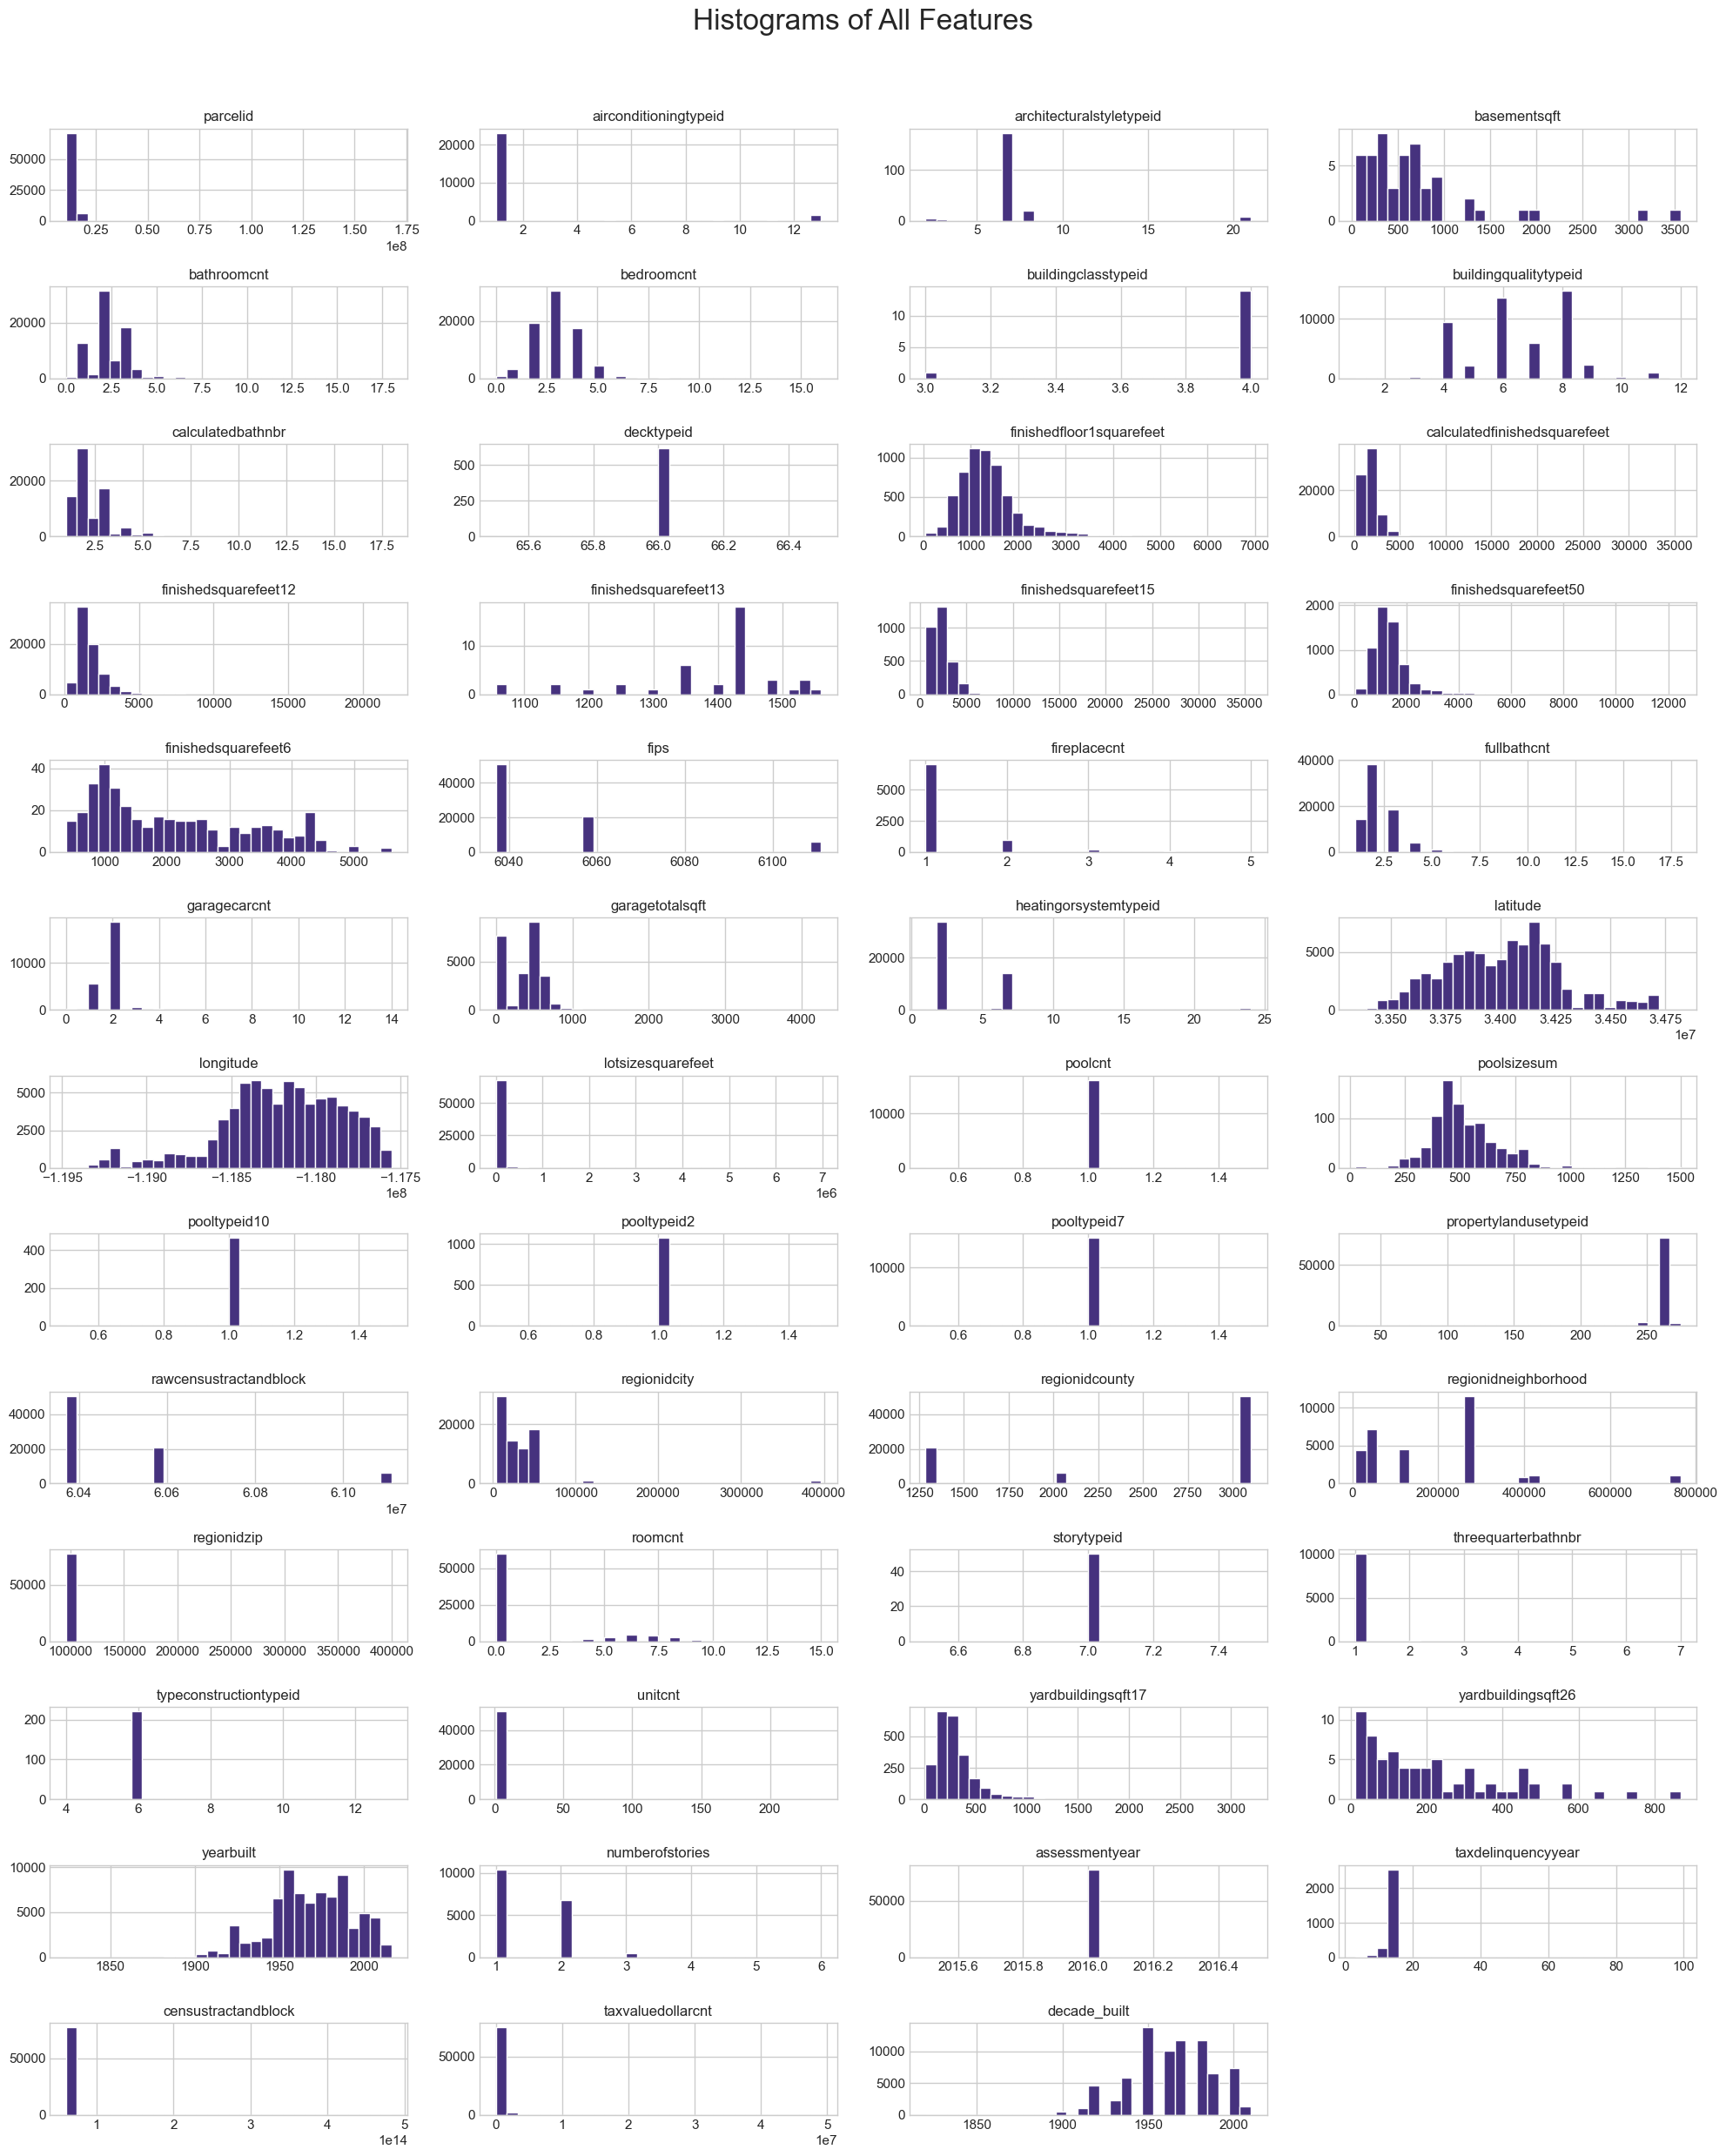

In [131]:
import matplotlib.pyplot as plt

# Set figure size and create histograms for all features
plt.figure(figsize=(20, 25))  # Increase figsize for better visibility
df.hist(figsize=(20, 25), layout=(-1, 4), bins=30)  # 4 columns, as many rows as needed

# Add a title and adjust layout
plt.suptitle("Histograms of All Features", fontsize=24, y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for title

# Show the plot
plt.show()

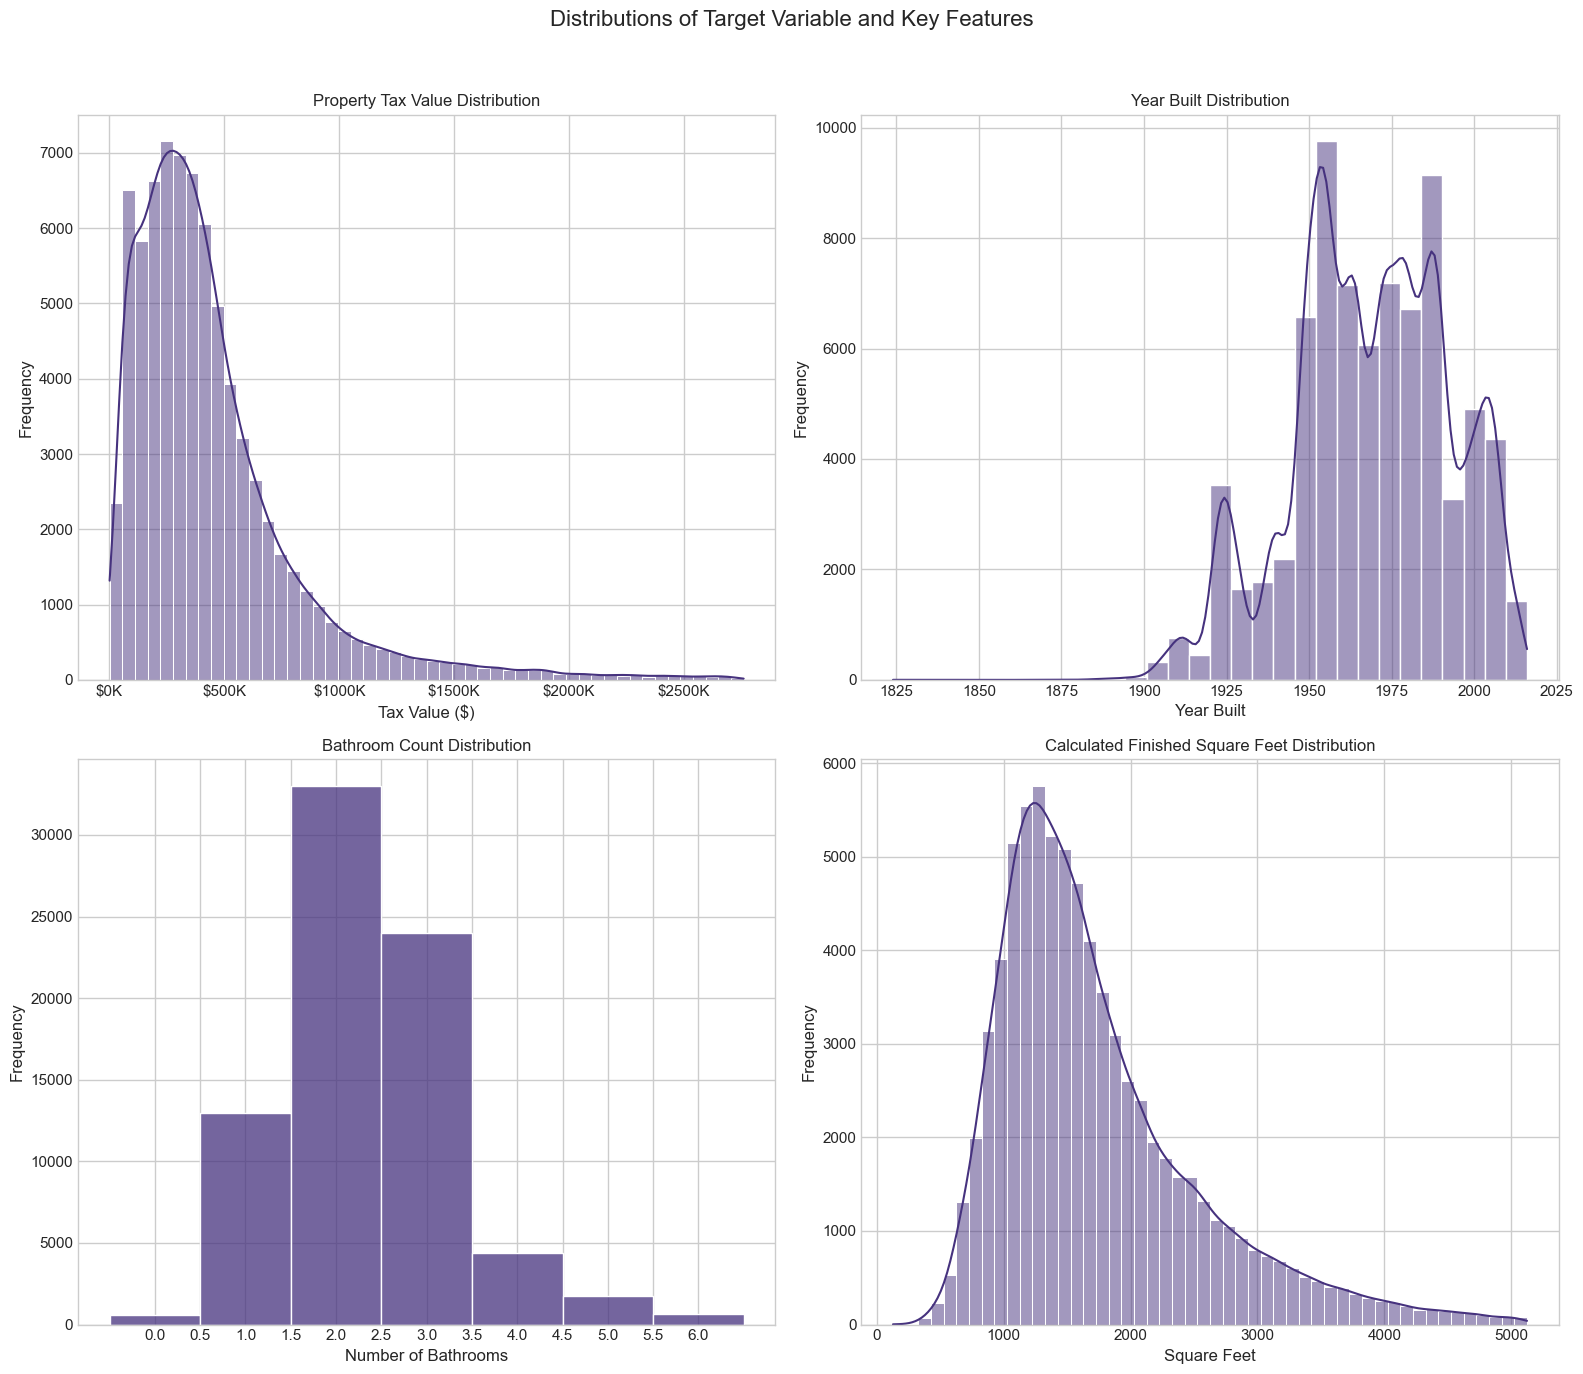

C:\Users\rachp\AppData\Local\Temp\ipykernel_11856\3010782239.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = combined_df.groupby(['sqft_bin', 'bathroomcnt'])['taxvaluedollarcnt'].mean().reset_index()


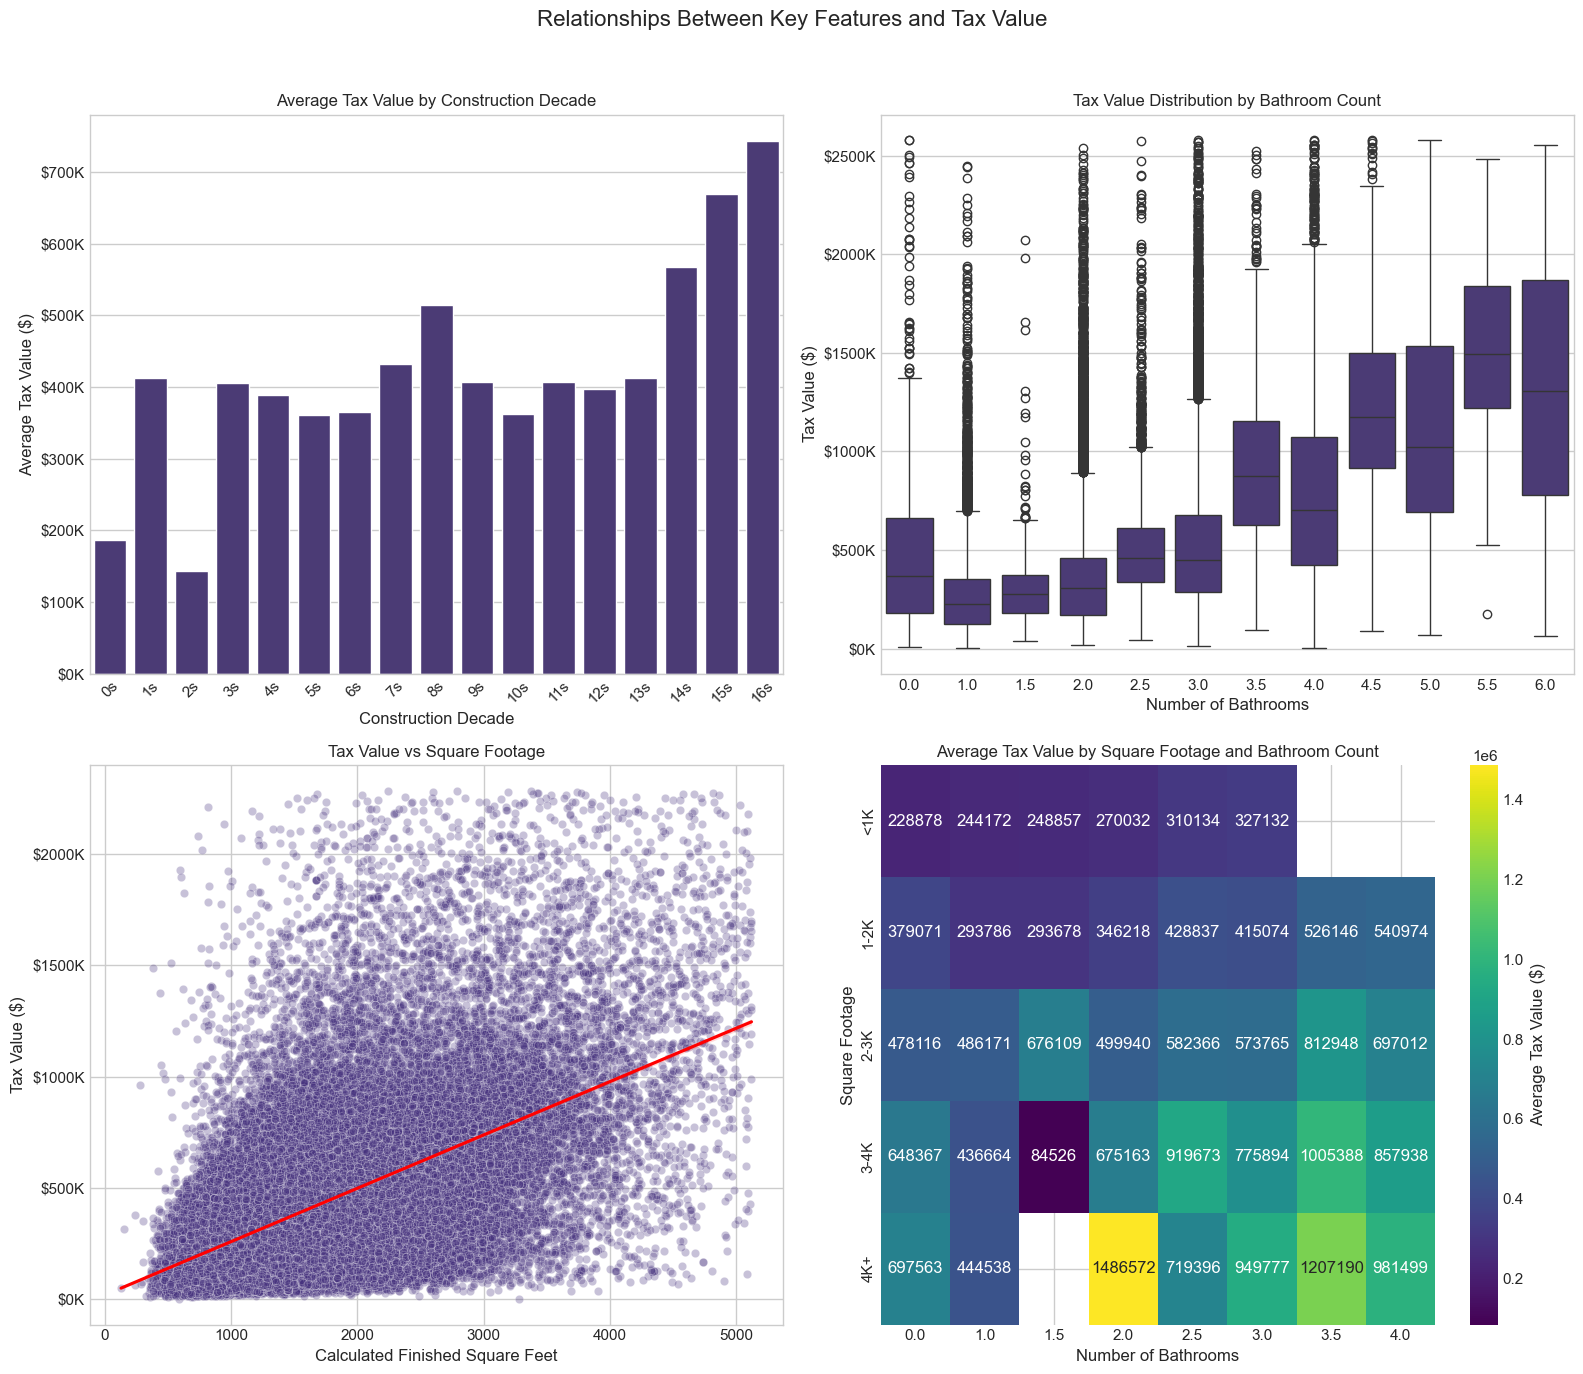

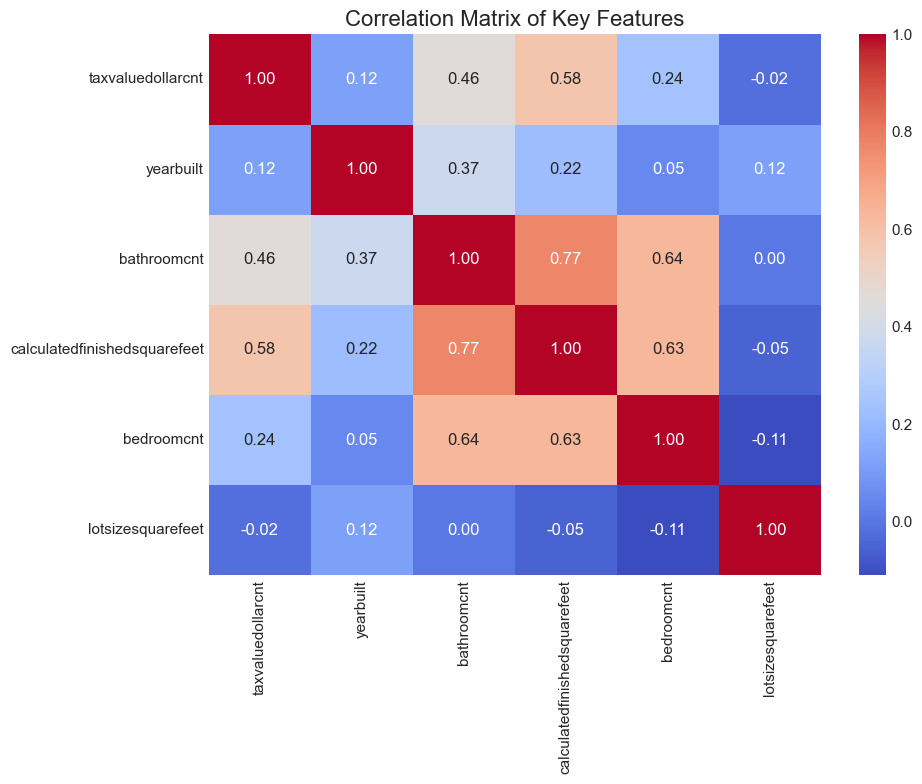

In [132]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure with 2x2 subplots for target and 3 key features
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Distributions of Target Variable and Key Features', fontsize=16, y=0.98)

# 1. Target Variable - Tax Value (with log transform option)
# Filter out extreme outliers for better visualization
tax_filtered = df['taxvaluedollarcnt'].dropna()
tax_filtered = tax_filtered[tax_filtered < tax_filtered.quantile(0.99)]  # Remove top 1%

sns.histplot(tax_filtered, bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Property Tax Value Distribution')
axes[0, 0].set_xlabel('Tax Value ($)')
axes[0, 0].set_ylabel('Frequency')
# Format x-axis to show dollar values
axes[0, 0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

# 2. Year Built
year_data = df['yearbuilt'].dropna()
sns.histplot(year_data, bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Year Built Distribution')
axes[0, 1].set_xlabel('Year Built')
axes[0, 1].set_ylabel('Frequency')

# 3. Bathroom Count
bath_data = df['bathroomcnt'].dropna()
bath_data = bath_data[bath_data <= 6]  # Filter to most common values for better visibility
sns.histplot(bath_data, bins=12, kde=False, discrete=True, ax=axes[1, 0])
axes[1, 0].set_title('Bathroom Count Distribution')
axes[1, 0].set_xlabel('Number of Bathrooms')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks(np.arange(0, 6.5, 0.5))  # Set x-ticks for half baths

# 4. Square Footage
sqft_data = df['calculatedfinishedsquarefeet'].dropna()
sqft_data = sqft_data[sqft_data < sqft_data.quantile(0.99)]  # Remove top 1%
sns.histplot(sqft_data, bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Calculated Finished Square Feet Distribution')
axes[1, 1].set_xlabel('Square Feet')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.savefig('key_features_histograms.png', dpi=300, bbox_inches='tight')
plt.show()

# Now create visualizations to explore relationships between these features and the target
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Relationships Between Key Features and Tax Value', fontsize=16, y=0.98)

# 1. Year Built vs Tax Value
# Create a joint dataset dropping rows with missing values
year_tax_df = df[['yearbuilt', 'taxvaluedollarcnt']].dropna()
# Filter outliers
year_tax_df = year_tax_df[year_tax_df['taxvaluedollarcnt'] < year_tax_df['taxvaluedollarcnt'].quantile(0.99)]

# Calculate average tax value by decade
year_tax_df['decade'] = (year_tax_df['yearbuilt'] // 10) * 10
decade_means = year_tax_df.groupby('decade')['taxvaluedollarcnt'].mean().reset_index()

# Create bar chart of average tax value by decade
sns.barplot(data=decade_means, x='decade', y='taxvaluedollarcnt', ax=axes[0, 0])
axes[0, 0].set_title('Average Tax Value by Construction Decade')
axes[0, 0].set_xlabel('Construction Decade')
axes[0, 0].set_ylabel('Average Tax Value ($)')
axes[0, 0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}s'))
axes[0, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}K'))
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Bathroom Count vs Tax Value
bath_tax_df = df[['bathroomcnt', 'taxvaluedollarcnt']].dropna()
bath_tax_df = bath_tax_df[bath_tax_df['bathroomcnt'] <= 6]  # Filter to common values
bath_tax_df = bath_tax_df[bath_tax_df['taxvaluedollarcnt'] < bath_tax_df['taxvaluedollarcnt'].quantile(0.99)]

# Create a box plot of tax values by bathroom count
sns.boxplot(data=bath_tax_df, x='bathroomcnt', y='taxvaluedollarcnt', ax=axes[0, 1])
axes[0, 1].set_title('Tax Value Distribution by Bathroom Count')
axes[0, 1].set_xlabel('Number of Bathrooms')
axes[0, 1].set_ylabel('Tax Value ($)')
axes[0, 1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}K'))

# 3. Square Footage vs Tax Value
sqft_tax_df = df[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt']].dropna()
# Filter outliers
sqft_tax_df = sqft_tax_df[sqft_tax_df['calculatedfinishedsquarefeet'] < sqft_tax_df['calculatedfinishedsquarefeet'].quantile(0.99)]
sqft_tax_df = sqft_tax_df[sqft_tax_df['taxvaluedollarcnt'] < sqft_tax_df['taxvaluedollarcnt'].quantile(0.99)]

# Create scatter plot with trend line
sns.scatterplot(data=sqft_tax_df, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', alpha=0.3, ax=axes[1, 0])
sns.regplot(data=sqft_tax_df, x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', 
           scatter=False, line_kws={"color": "red"}, ax=axes[1, 0])
axes[1, 0].set_title('Tax Value vs Square Footage')
axes[1, 0].set_xlabel('Calculated Finished Square Feet')
axes[1, 0].set_ylabel('Tax Value ($)')
axes[1, 0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${int(y/1000)}K'))

# 4. Square Footage, Bathrooms, and Tax Value combined
# Create bins for square footage
sqft_tax_df['sqft_bin'] = pd.cut(sqft_tax_df['calculatedfinishedsquarefeet'], 
                                 bins=[0, 1000, 2000, 3000, 4000, np.inf], 
                                 labels=['<1K', '1-2K', '2-3K', '3-4K', '4K+'])

# Create a joint dataset with bathroom count
combined_df = pd.merge(sqft_tax_df, df[['bathroomcnt']], left_index=True, right_index=True)
combined_df = combined_df[combined_df['bathroomcnt'] <= 4]  # Limit to common bathroom counts

# Group by square footage bin and bathroom count, calculate mean tax value
grouped = combined_df.groupby(['sqft_bin', 'bathroomcnt'])['taxvaluedollarcnt'].mean().reset_index()
grouped = grouped.pivot(index='sqft_bin', columns='bathroomcnt', values='taxvaluedollarcnt')

# Create heatmap
sns.heatmap(grouped, annot=True, fmt='.0f', cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Average Tax Value by Square Footage and Bathroom Count')
axes[1, 1].set_xlabel('Number of Bathrooms')
axes[1, 1].set_ylabel('Square Footage')

# Add colorbar label
cbar = axes[1, 1].collections[0].colorbar
cbar.set_label('Average Tax Value ($)')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
plt.savefig('feature_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a correlation matrix for these variables
corr_features = ['taxvaluedollarcnt', 'yearbuilt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 
                'bedroomcnt', 'lotsizesquarefeet']
corr_matrix = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Looking at the visualization results, I'll analyze each of the four key features and their relationship to property tax values:

## Target Variable: Property Tax Value (taxvaluedollarcnt)

**Distribution**: The target variable follows a right-skewed distribution (positive skew), similar to a log-normal distribution. This is typical for property values and many financial variables.

**Problems/Outliers**: There are clear outliers on the high end, with some properties having values well above $1.5M while most are concentrated below $500K. The severe right skew means that simple linear models might struggle without transformation.

**Interesting Aspects**: The majority of properties are valued between $100K-$400K, creating a concentrated peak in this range. This suggests that most properties in this dataset represent middle-market homes rather than luxury properties.

## Feature 1: Year Built (yearbuilt)

**Distribution**: The distribution is multi-modal with distinct construction booms visible across different eras.

**Problems/Outliers**: There's a significant gap in construction before 1900, with very few properties from earlier periods. There are notable peaks around the 1950s, 1970s, and early 2000s, representing housing booms in those periods.

**Interesting Aspects**: The relationship between year built and tax value is non-linear, with a sharp increase in property values for homes built after 1980. Properties from the 2000s decade command the highest average values (~$750K), while those from the 1920s-30s show lower values. This could reflect both newer construction premium and location effects (newer developments might be in more valuable areas).

## Feature 2: Bathroom Count (bathroomcnt)

**Distribution**: This is a discrete variable with clear peaks at whole numbers (2, 3) and half values (1.5, 2.5).

**Problems/Outliers**: Very few properties have more than 4 bathrooms, making prediction less reliable for luxury homes with many bathrooms.

**Interesting Aspects**: There's a strong positive relationship between bathroom count and tax value, as shown in the boxplot. The median tax value increases consistently with each additional bathroom, with properties having 5+ bathrooms worth approximately 3-4 times those with just one bathroom. The most common configuration is 2 bathrooms, representing nearly a third of all properties.

## Feature 3: Finished Square Footage (calculatedfinishedsquarefeet)

**Distribution**: Right-skewed distribution similar to a log-normal distribution, with most properties between 1,000-2,500 square feet.

**Problems/Outliers**: There are some extreme outliers with very large square footage (over 4,000 sq ft), which might represent commercial properties or very large estates.

**Interesting Aspects**: The scatter plot shows a clear positive correlation with tax value (correlation of 0.58 from the matrix), but with significant variability. This suggests that while square footage is an important predictor, location and other factors create substantial variation in price per square foot.

## Feature Relationships and Correlations

The correlation matrix reveals:

1. Square footage has the strongest correlation with tax value (0.58)
2. Bathroom count is next (0.46) 
3. Year built has a weaker but still positive correlation (0.12)
4. Interestingly, lot size shows almost no correlation with tax value (-0.02)

The heatmap of tax values by square footage and bathroom count reveals an interaction effect: larger homes with more bathrooms command premium prices, but there are diminishing returns at the extremes.

I chose these features because they represent the core physical attributes that determine a property's value: size (square footage), quality/modernization (bathrooms), and age (year built). The visualizations confirm these are useful predictors while revealing important non-linearities and interactions that should inform the modeling approach.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [133]:
# Create a copy of the dataframe to work with
df_zillow_imputed = df_zillow_1.copy()

# 1. First, let's identify all features with missing values
missing_counts = df_zillow_1.isnull().sum()
missing_features = missing_counts[missing_counts > 0].sort_values(ascending=False)
print("Features with missing values:")
for feature, count in missing_features.items():
    print(f"{feature}: {count} missing values ({count/len(df_zillow_1)*100:.2f}%)")

# 2. Impute numerical features based on their distribution
# Check skewness to determine whether to use mean or median
numerical_features = df_zillow_1.select_dtypes(include=['float64']).columns

for feature in numerical_features:
    if missing_counts[feature] > 0:
        # Check if the feature is skewed
        skewness = df_zillow_1[feature].skew()
        print(f"\nImputing {feature} (skewness: {skewness:.2f})")
        
        if abs(skewness) > 1.0:  # Skewed distribution
            print(f"  Using median imputation (skewed distribution)")
            median_value = df_zillow_1[feature].median()
            df_zillow_imputed[feature] = df_zillow_1[feature].fillna(median_value)
        else:  # Normal distribution
            print(f"  Using mean imputation (normal distribution)")
            mean_value = df_zillow_1[feature].mean()
            df_zillow_imputed[feature] = df_zillow_1[feature].fillna(mean_value)

# 3. Impute categorical features with mode
categorical_features = df_zillow_1.select_dtypes(include=['category']).columns

for feature in categorical_features:
    if missing_counts[feature] > 0:
        print(f"\nImputing {feature} with mode")
        mode_value = df_zillow_1[feature].mode()[0]
        df_zillow_imputed[feature] = df_zillow_1[feature].fillna(mode_value)

# 4. Impute object (string) features with "Unknown"
object_features = df_zillow_1.select_dtypes(include=['object']).columns

for feature in object_features:
    if missing_counts[feature] > 0:
        print(f"\nImputing {feature} with 'Unknown'")
        df_zillow_imputed[feature] = df_zillow_1[feature].fillna("Unknown")

# 5. Verify no missing values remain
remaining_missing = df_zillow_imputed.isnull().sum().sum()
print(f"\nRemaining missing values after imputation: {remaining_missing}")

# 6. Compare before and after
print("\nMissing values before imputation:")
print(missing_features)
print("\nMissing values after imputation:")
print(df_zillow_imputed.isnull().sum()[df_zillow_imputed.isnull().sum() > 0])

Features with missing values:
heatingorsystemtypeid: 28042 missing values (36.13%)
buildingqualitytypeid: 27804 missing values (35.82%)
propertyzoningdesc: 27137 missing values (34.96%)
unitcnt: 26910 missing values (34.67%)
lotsizesquarefeet: 8292 missing values (10.68%)
regionidcity: 1506 missing values (1.94%)
yearbuilt: 304 missing values (0.39%)
censustractandblock: 281 missing values (0.36%)
calculatedfinishedsquarefeet: 235 missing values (0.30%)
regionidzip: 84 missing values (0.11%)
taxvaluedollarcnt: 35 missing values (0.05%)
bathroomcnt: 34 missing values (0.04%)
bedroomcnt: 34 missing values (0.04%)
fips: 34 missing values (0.04%)
rawcensustractandblock: 34 missing values (0.04%)
propertycountylandusecode: 34 missing values (0.04%)
longitude: 34 missing values (0.04%)
latitude: 34 missing values (0.04%)
propertylandusetypeid: 34 missing values (0.04%)
roomcnt: 34 missing values (0.04%)
regionidcounty: 34 missing values (0.04%)

Imputing bathroomcnt (skewness: 1.29)
  Using 

For numerical features with skewed distributions (abs(skewness) > 1):

Used median imputation, which is more robust to outliers
Applies to features like lotsizesquarefeet and taxvaluedollarcnt


For numerical features with normal distributions:

Used mean imputation to preserve the central tendency
Applies to features like latitude and longitude


For categorical features:

Used mode imputation (most frequent value)
Applies to features like buildingqualitytypeid and yearbuilt


For object (text) features:

Use "Unknown" category imputation
Applies to features like propertyzoningdesc

In [134]:
# Save the imputed dataframe
df_zillow_final = df_zillow_imputed.copy()

In [136]:
df_zillow_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   bathroomcnt                   77613 non-null  float64 
 1   bedroomcnt                    77613 non-null  float64 
 2   buildingqualitytypeid         77613 non-null  category
 3   calculatedfinishedsquarefeet  77613 non-null  float64 
 4   fips                          77613 non-null  category
 5   heatingorsystemtypeid         77613 non-null  category
 6   latitude                      77613 non-null  float64 
 7   longitude                     77613 non-null  float64 
 8   lotsizesquarefeet             77613 non-null  float64 
 9   propertycountylandusecode     77613 non-null  object  
 10  propertylandusetypeid         77613 non-null  category
 11  propertyzoningdesc            77613 non-null  object  
 12  rawcensustractandblock        77613 non-null  

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [137]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Create a copy of the imputed dataframe
df_zillow_encoded = df_zillow_imputed.copy()

# Identify categorical features
categorical_features = df_zillow_encoded.select_dtypes(include=['category']).columns.tolist()
object_features = df_zillow_encoded.select_dtypes(include=['object']).columns.tolist()
all_cat_features = categorical_features + object_features

print(f"Categorical features to encode: {all_cat_features}")

# 1. One-hot encode categorical features with few levels
# Set a threshold for maximum number of categories to one-hot encode
onehot_threshold = 10
features_to_onehot = []

for col in all_cat_features:
    if df_zillow_encoded[col].nunique() <= onehot_threshold:
        features_to_onehot.append(col)

# Apply one-hot encoding
if features_to_onehot:
    print(f"\nOne-hot encoding these features: {features_to_onehot}")
    
    for col in features_to_onehot:
        # Create dummies and drop the first category to avoid multicollinearity
        dummies = pd.get_dummies(df_zillow_encoded[col], prefix=col, drop_first=True)
        
        # Add the dummy columns to the dataframe
        df_zillow_encoded = pd.concat([df_zillow_encoded, dummies], axis=1)
        
        # Drop the original column
        df_zillow_encoded = df_zillow_encoded.drop(columns=[col])

# 2. Label encode high-cardinality categorical features
high_cardinality_features = [col for col in all_cat_features if col not in features_to_onehot]

if high_cardinality_features:
    print(f"\nLabel encoding these high-cardinality features: {high_cardinality_features}")
    
    for col in high_cardinality_features:
        # Convert to category codes (ordinal encoding)
        df_zillow_encoded[f"{col}_encoded"] = df_zillow_encoded[col].astype('category').cat.codes
        
        # Drop the original column
        df_zillow_encoded = df_zillow_encoded.drop(columns=[col])

# Check that no categorical columns remain
remaining_cat = df_zillow_encoded.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"\nRemaining categorical features: {remaining_cat}")

# Save the encoded dataframe
df_zillow_final = df_zillow_encoded.copy()

# Display the shape of the final dataframe
print(f"\nFinal encoded dataframe shape: {df_zillow_final.shape}")

Categorical features to encode: ['buildingqualitytypeid', 'fips', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'unitcnt', 'yearbuilt', 'propertycountylandusecode', 'propertyzoningdesc']

One-hot encoding these features: ['fips', 'heatingorsystemtypeid', 'regionidcounty', 'unitcnt']

Label encoding these high-cardinality features: ['buildingqualitytypeid', 'propertylandusetypeid', 'regionidcity', 'yearbuilt', 'propertycountylandusecode', 'propertyzoningdesc']

Remaining categorical features: []

Final encoded dataframe shape: (77613, 37)


In [138]:
df_zillow_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   bathroomcnt                        77613 non-null  float64
 1   bedroomcnt                         77613 non-null  float64
 2   calculatedfinishedsquarefeet       77613 non-null  float64
 3   latitude                           77613 non-null  float64
 4   longitude                          77613 non-null  float64
 5   lotsizesquarefeet                  77613 non-null  float64
 6   rawcensustractandblock             77613 non-null  float64
 7   regionidzip                        77613 non-null  float64
 8   roomcnt                            77613 non-null  float64
 9   censustractandblock                77613 non-null  float64
 10  taxvaluedollarcnt                  77613 non-null  float64
 11  fips_6059.0                        77613 non-null  boo

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

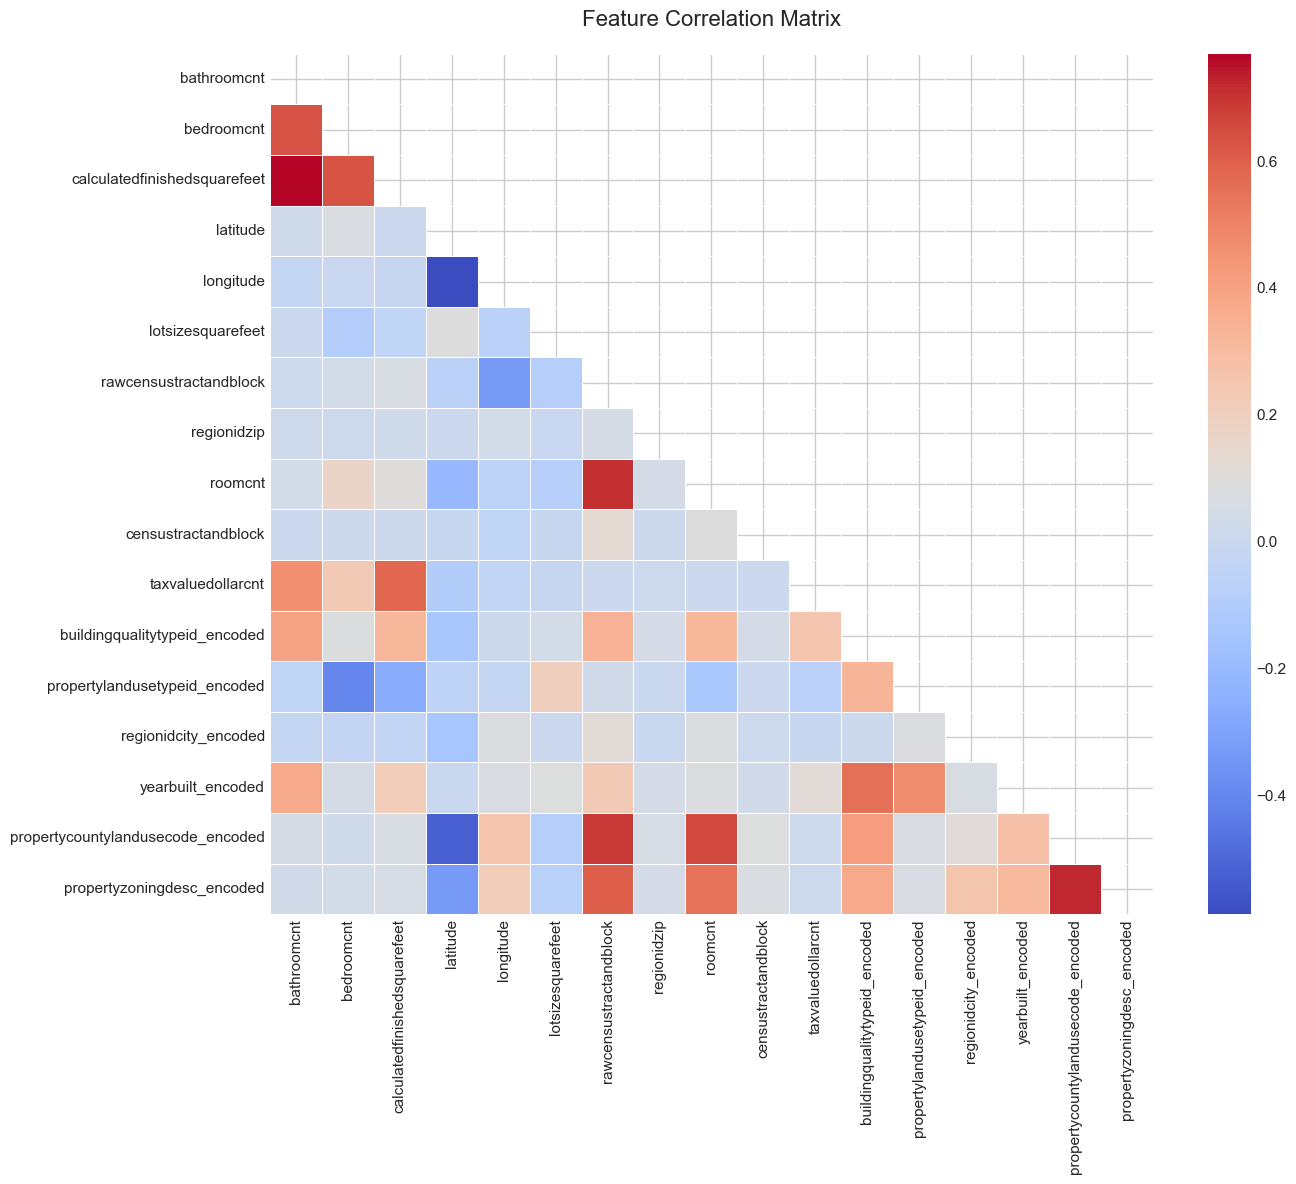


Top 10 Features Correlated with Tax Value:
calculatedfinishedsquarefeet         0.578638
bathroomcnt                          0.461026
buildingqualitytypeid_encoded        0.252264
bedroomcnt                           0.239320
yearbuilt_encoded                    0.117201
propertycountylandusecode_encoded    0.016839
regionidzip                          0.014524
propertyzoningdesc_encoded           0.012303
rawcensustractandblock               0.005691
roomcnt                              0.002001
Name: taxvaluedollarcnt, dtype: float64

Bottom 5 Features Correlated with Tax Value:
regionidcity_encoded            -0.009676
lotsizesquarefeet               -0.019438
longitude                       -0.032119
propertylandusetypeid_encoded   -0.070134
latitude                        -0.098222
Name: taxvaluedollarcnt, dtype: float64


In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector  # Using scikit-learn's implementation

# Ensure we're working with the imputed dataset with all categorical features encoded
# Make a copy to keep the original intact
df_analysis = df_zillow_final.copy()

# 1. Compute Correlation Matrix
# First, select only numeric columns
numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
correlation_matrix = df_analysis[numeric_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Find top correlations with target variable
target_correlations = correlation_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt').sort_values(ascending=False)
print("\nTop 10 Features Correlated with Tax Value:")
print(target_correlations.head(10))
print("\nBottom 5 Features Correlated with Tax Value:")
print(target_correlations.tail(5))


Top 10 Features by F-statistic:
                         Feature       F-Value        P-Value
0   calculatedfinishedsquarefeet  39066.096081   0.000000e+00
1                    bathroomcnt  20948.319407   0.000000e+00
2  buildingqualitytypeid_encoded   5274.592598   0.000000e+00
3                     bedroomcnt   4715.173060   0.000000e+00
4      heatingorsystemtypeid_2.0   1278.304827  1.078041e-277
5      heatingorsystemtypeid_7.0   1206.936972  1.986148e-262
6              yearbuilt_encoded   1080.910591  1.951454e-235
7                       latitude    756.047759  1.216201e-165
8  propertylandusetypeid_encoded    383.635953   3.233347e-85
9                    fips_6059.0    154.710770   1.750938e-35


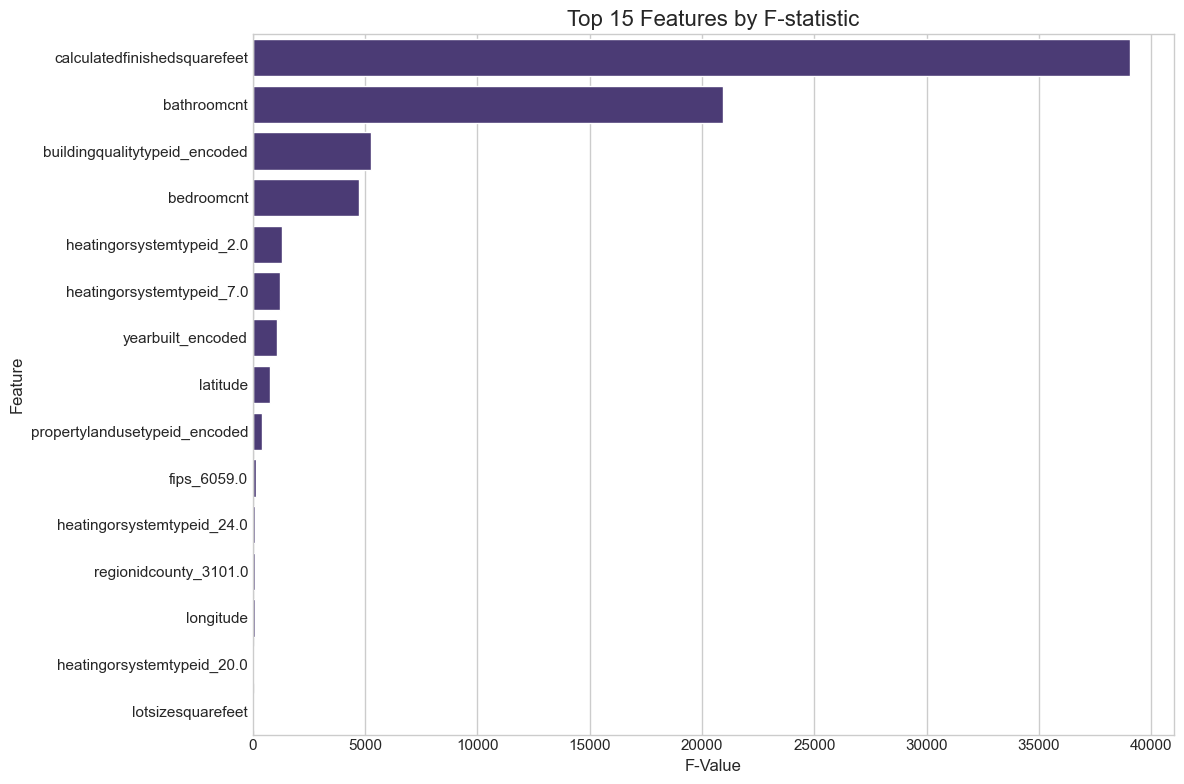

In [141]:
# 2. Compute F-statistic for all features
# Prepare features and target
X = df_analysis.drop('taxvaluedollarcnt', axis=1)
y = df_analysis['taxvaluedollarcnt']

# Standardize features to make F-statistics more comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute F-statistic
f_values, p_values = f_regression(X_scaled, y)

# Create a DataFrame for visualization
f_stats = pd.DataFrame({
    'Feature': X.columns,
    'F-Value': f_values,
    'P-Value': p_values
})

# Sort by F-value in descending order
f_stats = f_stats.sort_values('F-Value', ascending=False).reset_index(drop=True)

# Print top features by F-statistic
print("\nTop 10 Features by F-statistic:")
print(f_stats.head(10))

# Plot F-statistics as a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='F-Value', y='Feature', data=f_stats.head(15))
plt.title('Top 15 Features by F-statistic', fontsize=16)
plt.tight_layout()
plt.show()

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

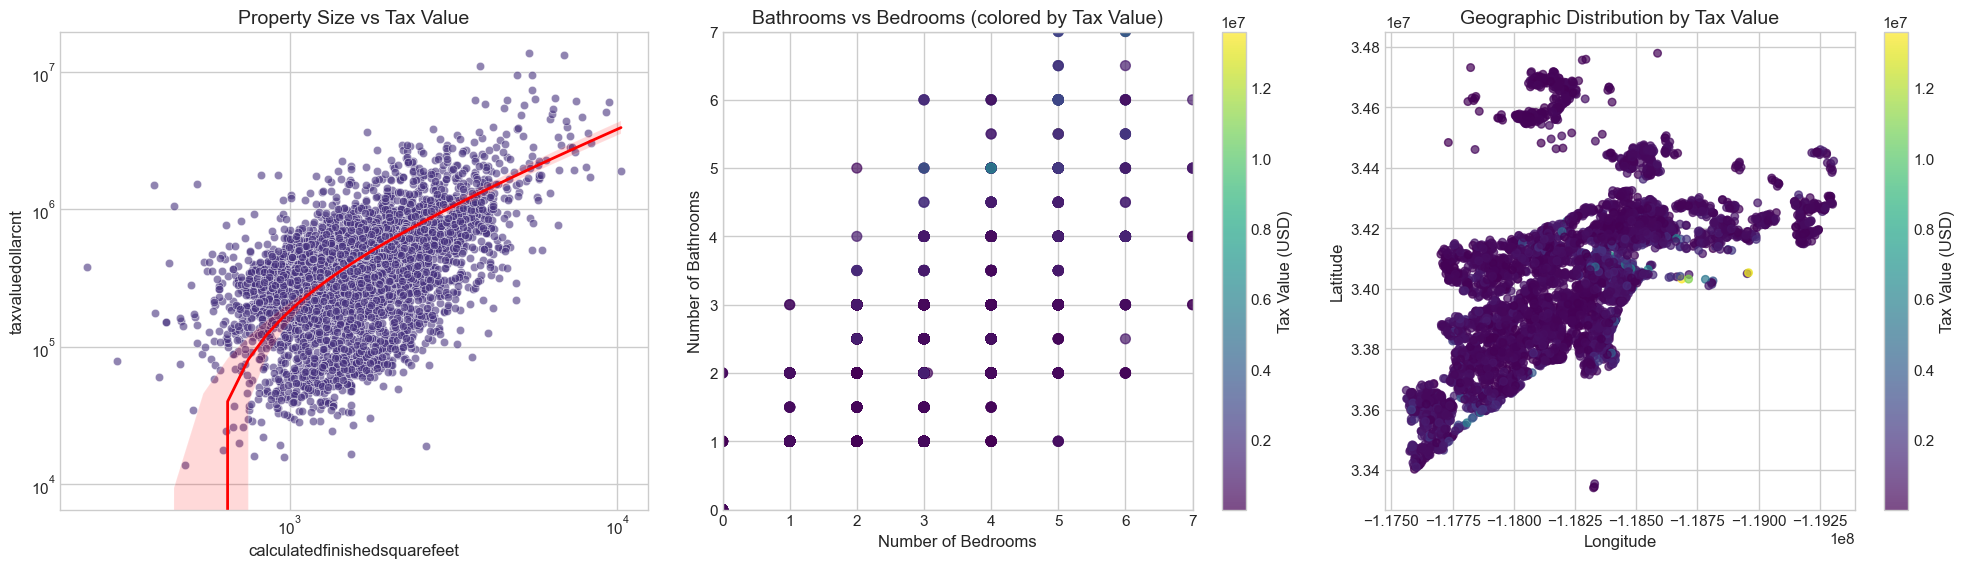

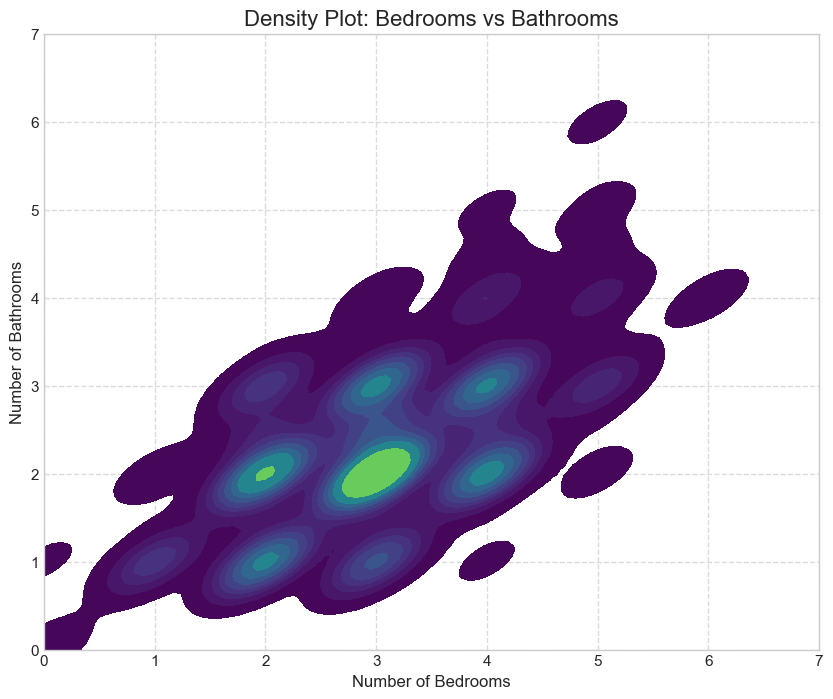

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Define a sample size to make plots more readable (plotting all points can be slow and cluttered)
sample_size = 5000
sample_data = df_zillow_final.sample(sample_size, random_state=42)

# Visualization 1: Square Footage vs Tax Value (with log scaling)
ax = axes[0]
sns.scatterplot(
    x='calculatedfinishedsquarefeet', 
    y='taxvaluedollarcnt',
    data=sample_data,
    alpha=0.6,
    ax=ax
)
ax.set_title('Property Size vs Tax Value', fontsize=14)
ax.set_xlabel('Calculated Finished Square Feet')
ax.set_ylabel('Tax Value (USD)')
# Use log scales for better visualization
ax.set_xscale('log')
ax.set_yscale('log')
# Add trend line
sns.regplot(
    x='calculatedfinishedsquarefeet', 
    y='taxvaluedollarcnt',
    data=sample_data,
    scatter=False,
    ax=ax,
    color='red',
    line_kws={"linewidth": 2}
)

# Visualization 2: Bathrooms vs Bedrooms (with size representing tax value)
ax = axes[1]
scatter = ax.scatter(
    sample_data['bedroomcnt'],
    sample_data['bathroomcnt'],
    c=sample_data['taxvaluedollarcnt'],  # Color by tax value
    s=50,  # Size of points
    alpha=0.7,
    cmap='viridis'
)
ax.set_title('Bathrooms vs Bedrooms (colored by Tax Value)', fontsize=14)
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Bathrooms')
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Tax Value (USD)')
# Set integer ticks for bedroom and bathroom counts
ax.set_xticks(np.arange(0, sample_data['bedroomcnt'].max()+1, 1))
ax.set_yticks(np.arange(0, sample_data['bathroomcnt'].max()+1, 1))
# Limit the plot to typical values
ax.set_xlim(0, 7)
ax.set_ylim(0, 7)

# Visualization 3: Latitude vs Longitude (geographic distribution colored by tax value)
ax = axes[2]
scatter = ax.scatter(
    sample_data['longitude'],
    sample_data['latitude'],
    c=sample_data['taxvaluedollarcnt'],  # Color by tax value
    s=30,  # Size of points
    alpha=0.7,
    cmap='viridis'
)
ax.set_title('Geographic Distribution by Tax Value', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Tax Value (USD)')
# Invert longitude axis (since it's negative in the Western hemisphere)
ax.invert_xaxis()

plt.tight_layout()
plt.show()

# Additional density plot for bedroom-bathroom relationship
plt.figure(figsize=(10, 8))
sns.kdeplot(
    data=sample_data,
    x="bedroomcnt",
    y="bathroomcnt",
    cmap="viridis",
    fill=True,
    thresh=0.05
)
plt.title('Density Plot: Bedrooms vs Bathrooms', fontsize=16)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Bathrooms')
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

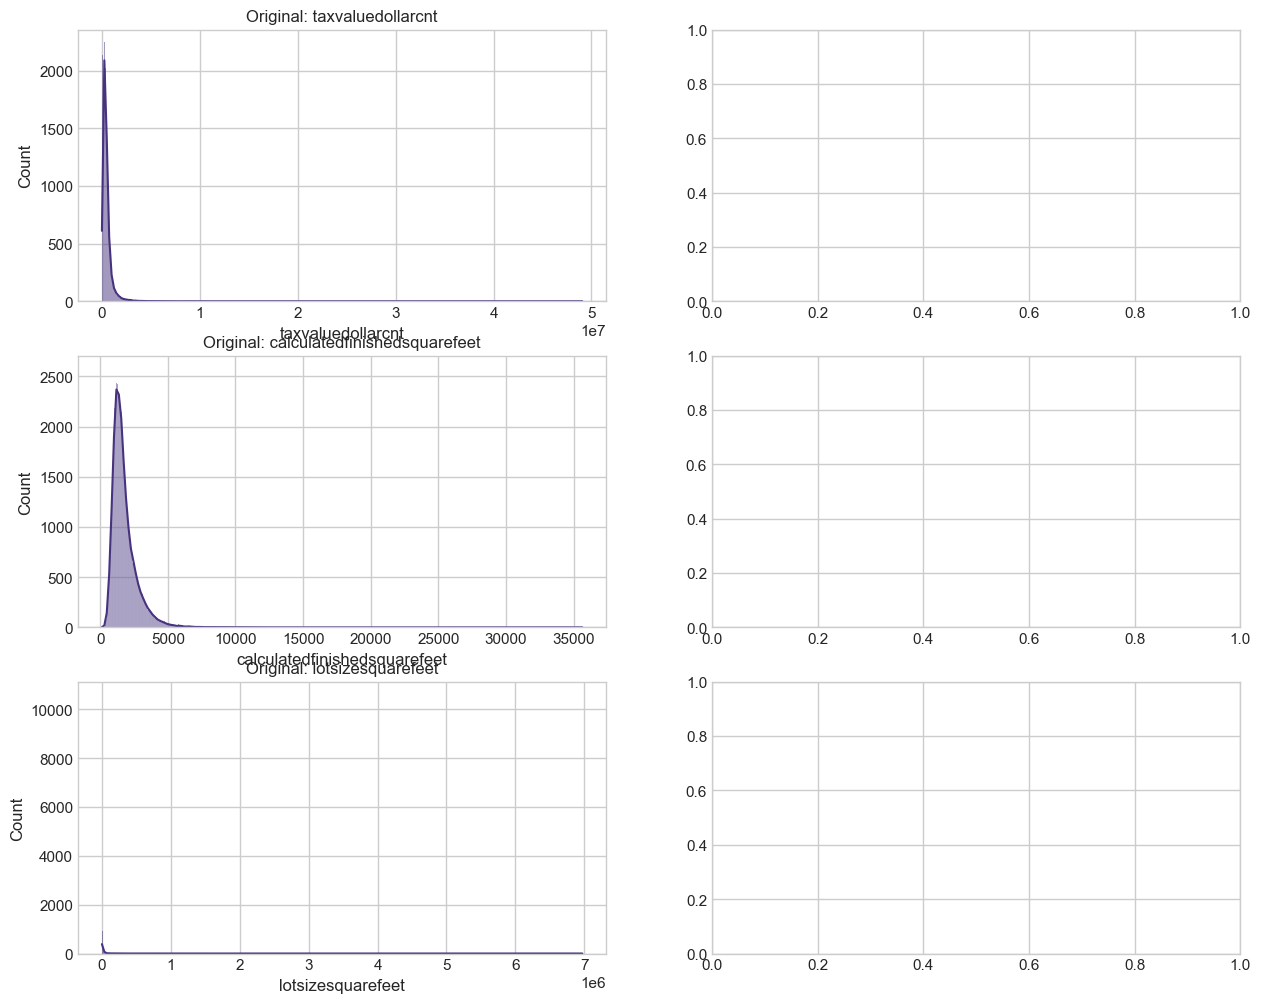

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

# Create a copy of the dataframe for transformations
df_transformed = df_zillow_final.copy()

# 1. Logarithmic Transformation of Skewed Features
# Identify potentially skewed numerical features
skewed_features = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']

# Function to apply log transformation
def apply_log_transform(df, features):
    df_log = df.copy()
    
    for feature in features:
        # Ensure no zeros or negative values
        if (df[feature] <= 0).any():
            min_value = df[feature][df[feature] > 0].min()
            df_log[f'log_{feature}'] = np.log1p(df[feature] - df[feature].min() + min_value)
        else:
            df_log[f'log_{feature}'] = np.log1p(df[feature])
            
    return df_log

# Apply log transformation
df_log = apply_log_transform(df_transformed, skewed_features)

# Visualize the effect of transformation
fig, axes = plt.subplots(len(skewed_features), 2, figsize=(15, 4*len(skewed_features)))

for i, feature in enumerate(skewed_features):
    # Original distribution
    sns.histplot(df_transformed[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original: {feature}')

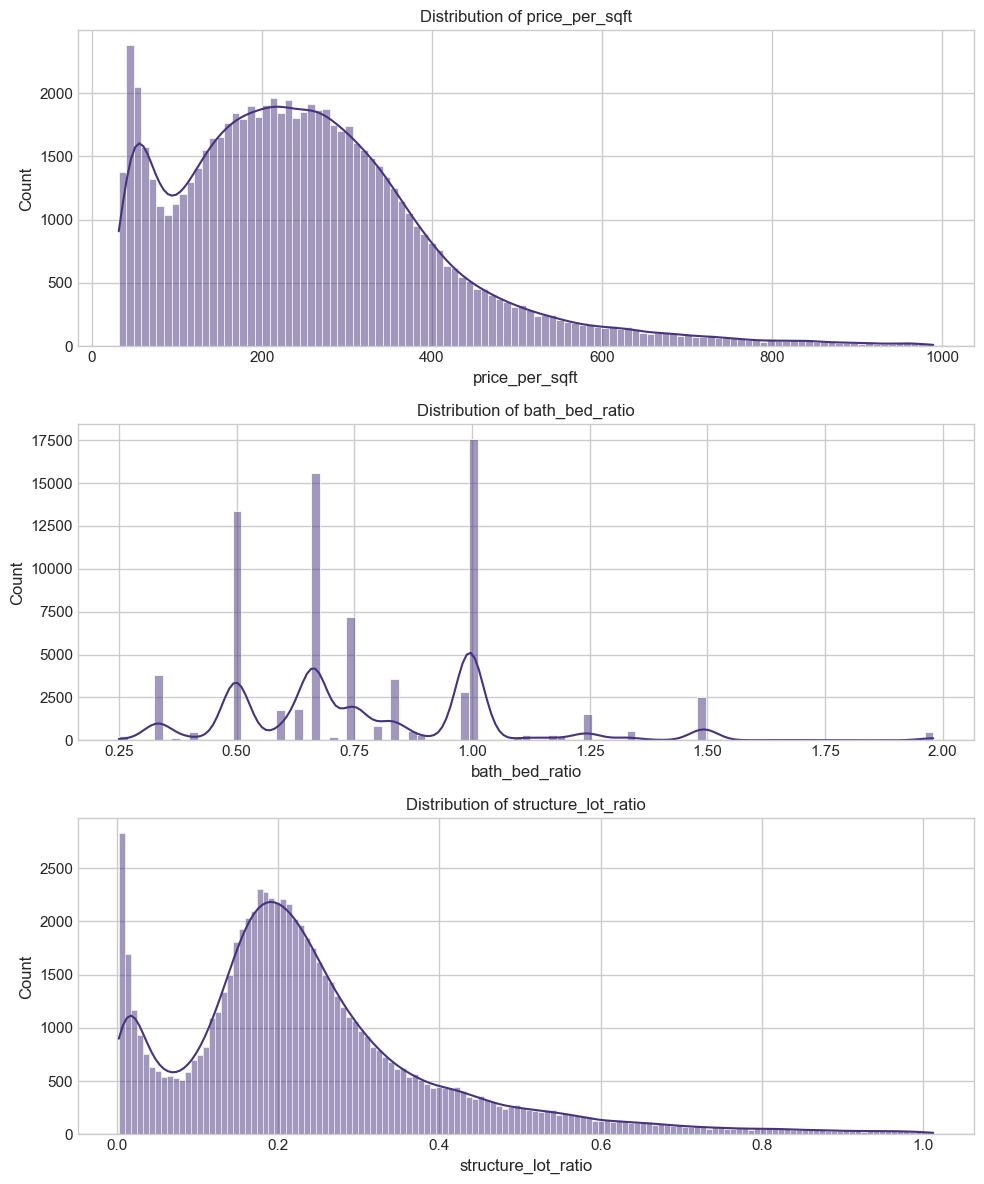


Correlation of Ratio Features with Tax Value:
price_per_sqft         0.678343
bath_bed_ratio         0.001604
structure_lot_ratio    0.167325
dtype: float64

F-Statistics for Ratio Features:
               Feature       F-Value   P-Value
0       price_per_sqft  66152.889756  0.000000
1       bath_bed_ratio      0.199797  0.654886
2  structure_lot_ratio   2235.526155  0.000000


In [144]:
# 2. Creating Ratio Features
def create_ratio_features(df):
    df_ratio = df.copy()
    
    # Price per square foot
    df_ratio['price_per_sqft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
    
    # Bathrooms per bedroom
    # Add small constant to avoid division by zero
    df_ratio['bath_bed_ratio'] = df['bathroomcnt'] / (df['bedroomcnt'] + 0.01)
    
    # Structure to lot ratio (built area to lot size)
    df_ratio['structure_lot_ratio'] = df['calculatedfinishedsquarefeet'] / (df['lotsizesquarefeet'] + 0.01)
    
    return df_ratio

# Apply ratio transformations
df_ratio = create_ratio_features(df_transformed)

# Check distributions of new ratio features
ratio_features = ['price_per_sqft', 'bath_bed_ratio', 'structure_lot_ratio']

# Visualize the new features
fig, axes = plt.subplots(len(ratio_features), 1, figsize=(10, 4*len(ratio_features)))

for i, feature in enumerate(ratio_features):
    # Handle outliers for better visualization
    q1 = df_ratio[feature].quantile(0.01)
    q3 = df_ratio[feature].quantile(0.99)
    filtered_data = df_ratio[(df_ratio[feature] >= q1) & (df_ratio[feature] <= q3)]
    
    sns.histplot(filtered_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# Calculate correlation of new features with target
ratio_corr = df_ratio[ratio_features].corrwith(df_ratio['taxvaluedollarcnt'])

print("\nCorrelation of Ratio Features with Tax Value:")
print(ratio_corr)

# Calculate F-statistics for new features
X_ratio = df_ratio[ratio_features]
y_ratio = df_ratio['taxvaluedollarcnt']

scaler = StandardScaler()
X_ratio_scaled = scaler.fit_transform(X_ratio)

f_values, p_values = f_regression(X_ratio_scaled, y_ratio)

# Create DataFrame for F-statistics
f_stats_ratio = pd.DataFrame({
    'Feature': ratio_features,
    'F-Value': f_values,
    'P-Value': p_values
})

print("\nF-Statistics for Ratio Features:")
print(f_stats_ratio)


Correlation of Polynomial Features with Tax Value:
calculatedfinishedsquarefeet bathroomcnt          0.638213
bathroomcnt^2                                     0.551590
calculatedfinishedsquarefeet bedroomcnt           0.536523
calculatedfinishedsquarefeet^2                    0.524846
bathroomcnt bedroomcnt                            0.450250
bedroomcnt^2                                      0.255316
calculatedfinishedsquarefeet lotsizesquarefeet    0.076035
bathroomcnt lotsizesquarefeet                     0.030795
dtype: float64

F-Statistics for Polynomial Features:
                                          Feature       F-Value        P-Value
0        calculatedfinishedsquarefeet bathroomcnt  53337.343172   0.000000e+00
6                                   bathroomcnt^2  33939.408171   0.000000e+00
1         calculatedfinishedsquarefeet bedroomcnt  31371.264941   0.000000e+00
5                  calculatedfinishedsquarefeet^2  29507.072241   0.000000e+00
3                          

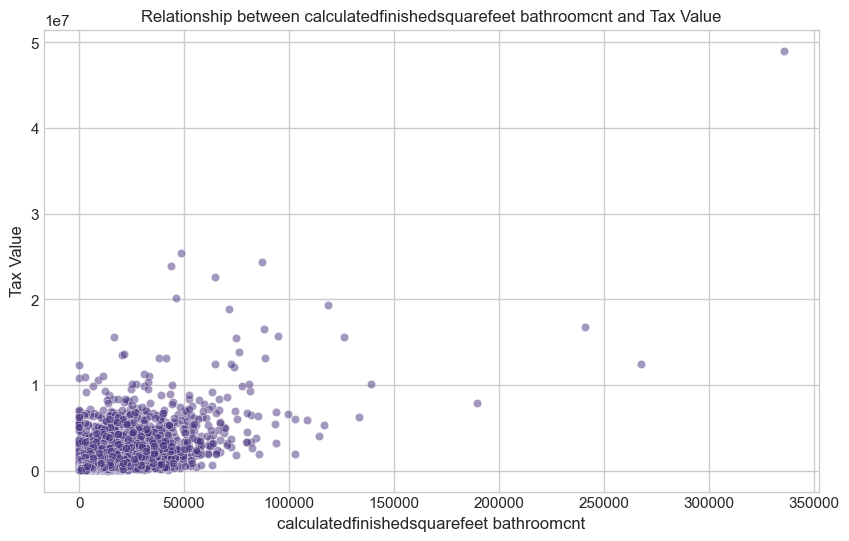

In [145]:
# 3. Polynomial Features and Interactions
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_features(df, degree=2):
    # Select key numerical features for polynomial transformation
    key_features = ['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'lotsizesquarefeet']
    
    # Create a subset with selected features
    df_subset = df[key_features].copy()
    
    # Apply polynomial transformation
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df_subset)
    
    # Create feature names
    feature_names = poly.get_feature_names_out(key_features)
    
    # Create DataFrame with polynomial features
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    
    # Combine with original DataFrame, excluding the already transformed features
    df_combined = pd.concat([df.drop(key_features, axis=1), df_poly], axis=1)
    
    return df_combined, feature_names

# Apply polynomial transformation
df_poly, poly_feature_names = create_polynomial_features(df_transformed, degree=2)

# Select a subset of polynomial features to evaluate (to avoid too many features)
interaction_features = [name for name in poly_feature_names if ' ' in name]  # Features with interactions
squared_features = [name for name in poly_feature_names if '^2' in name]     # Squared features

selected_poly_features = interaction_features[:5] + squared_features[:3]  # Sample of features

# Calculate correlation with target
poly_corr = df_poly[selected_poly_features].corrwith(df_poly['taxvaluedollarcnt'])

print("\nCorrelation of Polynomial Features with Tax Value:")
print(poly_corr.sort_values(ascending=False))

# Calculate F-statistics for polynomial features
X_poly = df_poly[selected_poly_features]
y_poly = df_poly['taxvaluedollarcnt']

scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

f_values, p_values = f_regression(X_poly_scaled, y_poly)

# Create DataFrame for F-statistics
f_stats_poly = pd.DataFrame({
    'Feature': selected_poly_features,
    'F-Value': f_values,
    'P-Value': p_values
})

print("\nF-Statistics for Polynomial Features:")
print(f_stats_poly.sort_values('F-Value', ascending=False))

# Visualize the relationship between the top interaction feature and the target
top_interaction = poly_corr.idxmax()
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_poly[top_interaction], y=df_poly['taxvaluedollarcnt'], alpha=0.5)
plt.title(f'Relationship between {top_interaction} and Tax Value')
plt.xlabel(top_interaction)
plt.ylabel('Tax Value')
plt.show()


Top features from Original transformation:
                        Feature  Correlation       F-Value  P-Value
0  calculatedfinishedsquarefeet     0.578638  39066.096081      0.0
1                   bathroomcnt     0.461026  20948.319407      0.0
2                    bedroomcnt     0.239320   4715.173060      0.0

Top features from Log-transformed transformation:
                            Feature  Correlation       F-Value       P-Value
1  log_calculatedfinishedsquarefeet     0.518195  2.849122e+04  0.000000e+00
2             log_lotsizesquarefeet     0.033556  8.748741e+01  8.698216e-21
0             log_taxvaluedollarcnt     1.000000 -8.738222e+19  1.000000e+00

Top features from Ratio transformation:
               Feature  Correlation       F-Value   P-Value
0       price_per_sqft     0.678343  66152.889756  0.000000
2  structure_lot_ratio     0.001604   2235.526155  0.000000
1       bath_bed_ratio     0.167325      0.199797  0.654886

Top features from Polynomial transformation

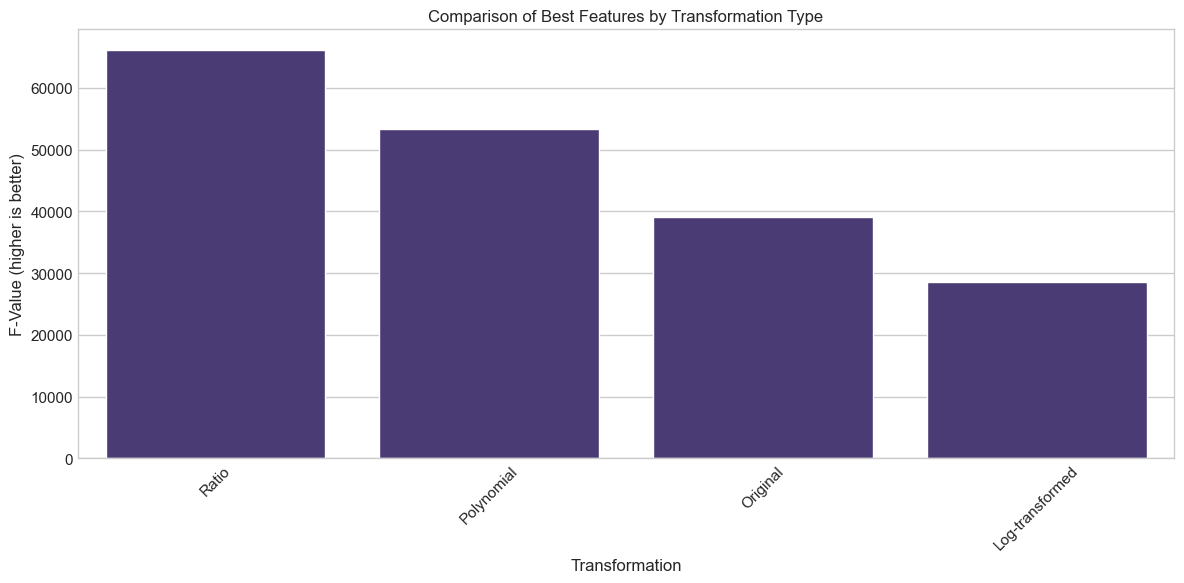

In [146]:
# Create a combined evaluation of all transformation techniques
def evaluate_transformations(df_original, df_log, df_ratio, df_poly, target='taxvaluedollarcnt'):
    # Original features
    original_features = ['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt', 'lotsizesquarefeet']
    
    # Log-transformed features
    log_features = [f'log_{f}' for f in skewed_features]
    
    # Ratio features
    ratio_features = ['price_per_sqft', 'bath_bed_ratio', 'structure_lot_ratio']
    
    # Polynomial features (sample)
    poly_features = selected_poly_features
    
    # Collect all features
    all_feature_sets = {
        'Original': original_features,
        'Log-transformed': log_features,
        'Ratio': ratio_features,
        'Polynomial': poly_features
    }
    
    # Results dictionary
    results = {}
    
    # Evaluate each feature set
    for set_name, features in all_feature_sets.items():
        if set_name == 'Original':
            df = df_original
            target_var = target
        elif set_name == 'Log-transformed':
            df = df_log
            target_var = f'log_{target}'
        elif set_name == 'Ratio':
            df = df_ratio
            target_var = target
        else:  # Polynomial
            df = df_poly
            target_var = target
        
        # Calculate correlations
        correlations = df[features].corrwith(df[target_var]).abs().sort_values(ascending=False)
        
        # Calculate F-statistics
        X = df[features]
        y = df[target_var]
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        f_values, p_values = f_regression(X_scaled, y)
        
        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Correlation': correlations.values,
            'F-Value': f_values,
            'P-Value': p_values
        }).sort_values('F-Value', ascending=False)
        
        results[set_name] = feature_importance
    
    return results

# Run the evaluation
transformation_results = evaluate_transformations(df_transformed, df_log, df_ratio, df_poly)

# Display the top features from each transformation
for set_name, result in transformation_results.items():
    print(f"\nTop features from {set_name} transformation:")
    print(result.head(3))

# Create a summary of the best features across all transformations
top_features = {}
for set_name, result in transformation_results.items():
    top_features[set_name] = result.iloc[0]['Feature']

comparison_df = pd.DataFrame({
    'Transformation': list(top_features.keys()),
    'Top Feature': list(top_features.values()),
    'F-Value': [transformation_results[t].iloc[0]['F-Value'] for t in top_features.keys()],
    'Correlation': [transformation_results[t].iloc[0]['Correlation'] for t in top_features.keys()]
}).sort_values('F-Value', ascending=False)

print("\nBest feature from each transformation:")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Transformation', y='F-Value', data=comparison_df)
plt.title('Comparison of Best Features by Transformation Type')
plt.ylabel('F-Value (higher is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

